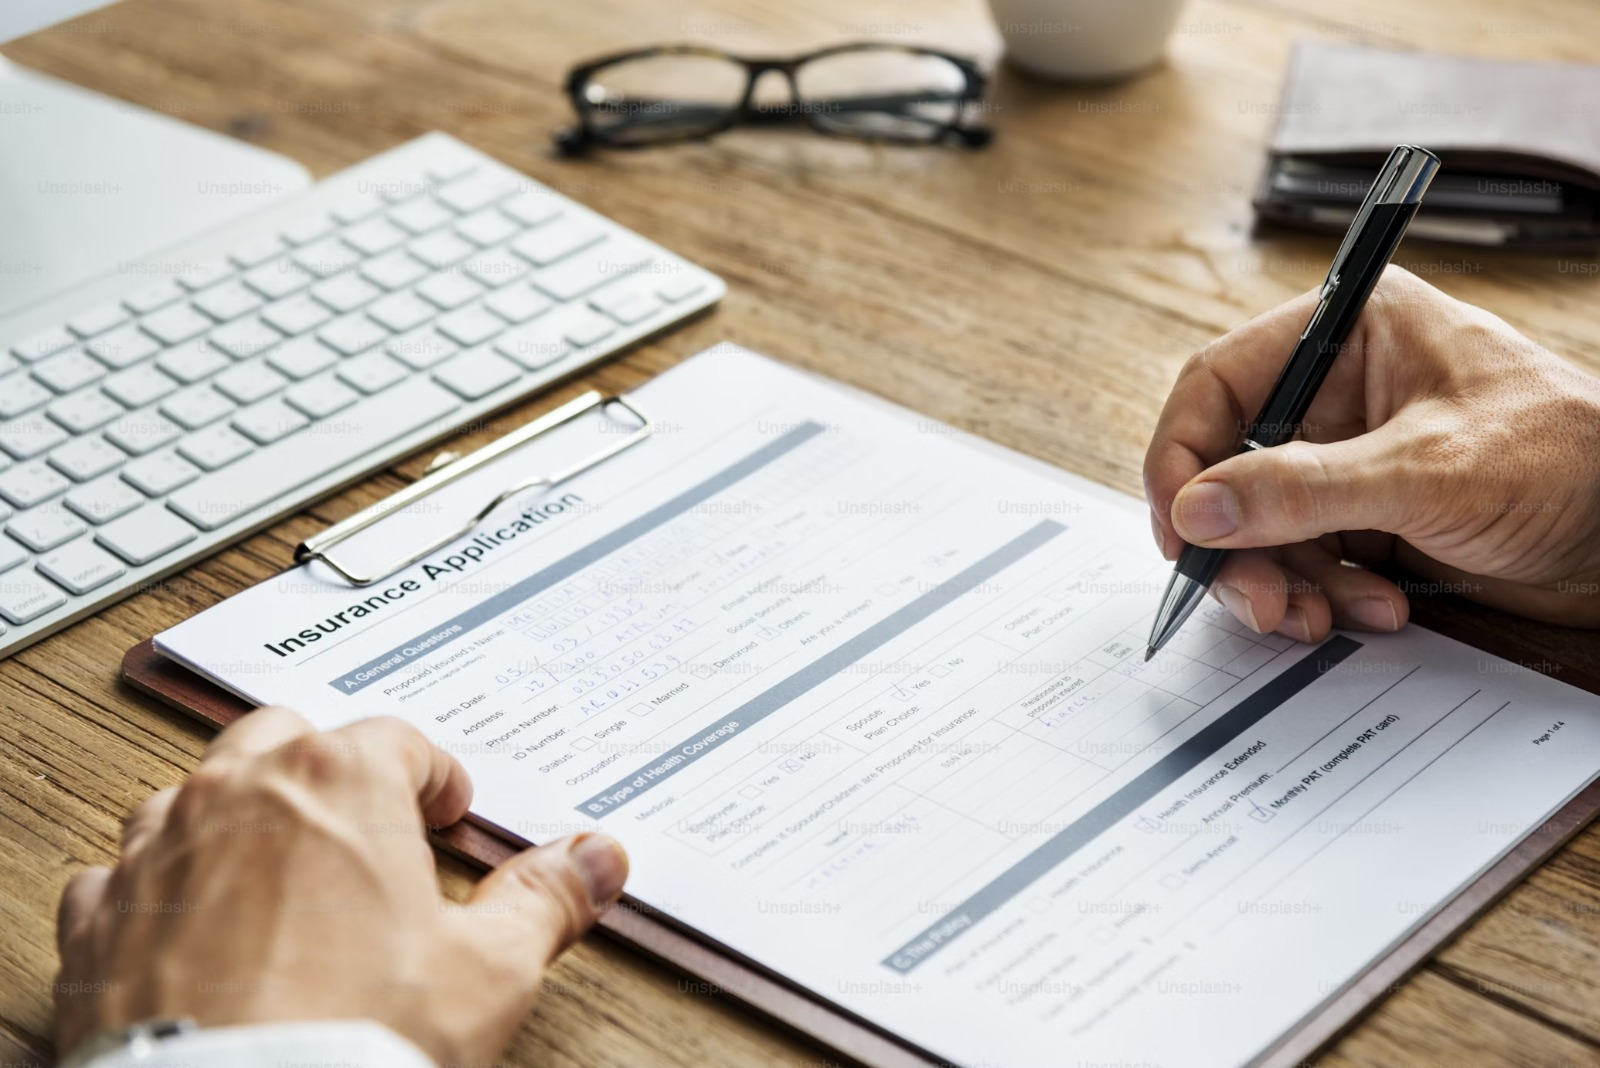

In this project, I worked with a medical insurance cost dataset to explore and predict the factors influencing insurance charges. The raw dataset was initially cleaned and preprocessed using SQLite to ensure data quality and consistency. The cleaned data was then imported into a pandas DataFrame for further analysis. To develop a predictive model, I implemented a Ridge Regression approach, which achieved an accuracy of 81.5%. This notebook outlines the entire workflow, from data cleaning and transformation to model development and evaluation, showcasing a comprehensive approach to solving a real-world data science problem.

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import rain_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

We now connect to our database which we can find in my google drive.

In [2]:
database = "/content/drive/MyDrive/Datasets/SQL databases/insurance.db"
connection = sql.connect(database)

In [3]:
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('insurance_data',)]

In [4]:
query = '''SELECT age,
                  gender,
                  bmi,
                  bloodpressure,
                  diabetic,
                  children,
                  smoker,
                  region,
                  claim
            FROM insurance_data'''
df = pd.read_sql_query(query, connection)

In [5]:
df.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1335 non-null   float64
 1   gender         1340 non-null   object 
 2   bmi            1340 non-null   float64
 3   bloodpressure  1340 non-null   int64  
 4   diabetic       1340 non-null   object 
 5   children       1340 non-null   int64  
 6   smoker         1340 non-null   object 
 7   region         1340 non-null   object 
 8   claim          1340 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 94.3+ KB


Now notice that in our age column there's 5 missing values, so I will plot a box and whisker to see the age distribution so that I can see what method of imputation I should use

In [7]:
df.describe()

,age,bmi,bloodpressure,children,claim
count,1335.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,38.078652,30.668955,94.157463,1.093284,13252.745642
std,11.102924,6.106735,11.434712,1.205334,12109.609288
min,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,47.000000,34.700000,99.000000,2.000000,16604.305000
max,60.000000,53.100000,140.000000,5.000000,63770.430000


![7093ffce-ddb0-4ac7-8bd8-45b75701c889](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAACT8AAAYgCAYAAAC9QqsuAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAB7CAAAewgFu0HU+AAEAAElEQVR4nOzdeZyVZf0//hczLMMAghuIGoEGigshftwXVLTSxDWXLNPwl/oxyNJM3M1MSdvMrVLINA2XNJeyT7mA5EfBIEUTdxBFVFQQhmHYZn5/+OV8ZmRgZmCGYeD5fDx4eJ/7vq7rft9n5hzPec/7uu5WVVVVVQEAAAAAAAAAAGhhipo7AAAAAAAAAAAAgFWh+AkAAAAAAAAAAGiRFD8BAAAAAAAAAAAtkuInAAAAAAAAAACgRVL8BAAAAAAAAAAAtEiKnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwBgha699tpss8022WabbXLttdc2dziN4oADDihc09tvv90oYw4fPrww5r333tsoY9bm7bffLpzngAMOaLLzrC+WPZfbbLNNc4cCAAAANDF5rvqR52qZ1vc817r4+k7W3esCaAqtmzsAAFqGE088MRMmTFjh8VatWqV9+/bZcMMNs+2222a//fbLIYccko4dO67BKFlbnX322XnooYeSJAcddFCuu+66Ovv89a9/zfe+973C4+OPPz4//OEP6+z3+9//PldccUWSZJNNNsmTTz65ilGztllZ8qaoqCgdO3bMJptskh122CGDBg3KgQcemNatfdwFAACgJnkuVoc8F41BngsAGpeVnwBoFFVVVSkvL8+MGTPy6KOP5qKLLsoXv/jFPProo80dGmuBXXbZpbA9ceLEevV55plnajz+17/+Va9+1dtVPy/rtsrKysydOzdvvPFGHnjggZx55pn58pe/nMmTJzd3aDWMHz++MFvrxBNPbO5wAAAAqIU8Fysjz0VTk+cCgIZTIgxAg+24447p169fjX2VlZWZN29eXnrppbz22mtJkg8++CDDhg3L9ddfn/333785QmUtUT0589FHH+W1117L5z73uZX2+XQS6PXXX89HH32UjTbaqN79JIXWXQceeGC6detWeLx06dJ8+OGHmThxYj766KMkybRp03LSSSflD3/4Q7bffvvmChUAAIC1mDwXDSXPRWOT5wKA1af4CYAGGzhwYIYNG7bC4xMnTsxZZ52Vd999N0uXLs0ll1ySvffeO23atFmDUbI22XrrrbPxxhvnww8/TPLJbLeVJYXmzJmTV199NUmy+eab55133klVVVUmTpyYgw46aIX9liWOlllTSaERI0ZkxIgRa+RcfOIb3/hGdtttt+X2L1q0KDfffHN+9atfFWbqDh8+PA888EBatWrVDJECAACwNpPnoqHkuWhs8lysyLBhw1b6/ygA/o/b3gHQ6Hbeeedcc801hcfvvfdeJkyY0IwRsTb4r//6r8J2XUt7/+tf/0pVVVWS5OSTTy58mf/0EuG19VumS5cu6d2796qGSwvVtm3bnHHGGfnmN79Z2PfKK6/kySefbMaoAAAAaKnkuaiNPBdrgjwXANSf4icAmkT//v2z5ZZbFh4vWyKc9Vf12Wn1SQotM2jQoEJyp65+1ZNG//Vf/2UG1Hrs1FNPTVHR/33U/d///d9mjAYAAICWTJ6LT5PnYk2S5wKAurntHQBNZtNNN83bb7+dJFmwYEG9+owbNy5//etfM2nSpMyaNStLlizJxhtvnO222y6DBg3K4MGDV7is+GmnnZYxY8YkSbbddtvcfffdadu27QrP9eyzz+ZrX/talixZkiS55ppr8qUvfakBV7i8F154IU8++WQmTZqU1157LR999FEWL16cDTbYID169Mhuu+2W4447LptvvnmdYx1wwAGZMWNGkuTRRx/NlltumXfffTejR4/OY489lnfeeSdLlizJZpttlr322itDhgzJFltsUe9Yn3766dx9992ZNGlSPvjgg3Tu3Dk9evTIl7/85Rx11FFp3779Kj8PtameFHr33Xfz1ltv5TOf+UytbZcldzbbbLNsueWWGTBgQF555ZW89NJLKSsrS8eOHWvtN3HixFrPV5fVfV6HDx+e++67L0ly5ZVX5qijjqq1XVVVVR599NE8/PDDeeGFFzJr1qwsWLAg7dq1y0YbbZQtt9wyO+64Y/bZZ5/suuuuNZIaDbVw4cKcddZZeeSRR5IkG220UW6++eZsv/32y7WdOXNm7r333jz55JOZPn165syZk9LS0my++ebZY489cuyxx6ZXr14Nfg7mzp2b++67L3//+98zffr0fPjhh1m6dGmeeeaZbLDBBqt8bfWx4YYbplevXnn99deTpPBetDpeffXV3HvvvXnqqacyc+bMzJ8/P126dEmvXr2yzz775JhjjsmGG25Ya99rr7021113XY19EyZMyDbbbLNc2y222CKPPfbYasdbH4sXL87TTz+dp556Ks8//3ymTp2ajz/+OK1atUqXLl3Sp0+f7L333jnmmGPSoUOHeo9bUVGR0aNH529/+1umTp2aBQsWpGvXrunXr1+OOeaY7LHHHklqf59bmfLy8vz5z3/OE088kZdffjkfffRRioqKsummm2bnnXfOYYcdVhgbAACgMclzyXNVJ88lzyXPtfbluT6tvLw89913X/7yl7/kzTffzNy5c7PJJptkwIABOe6447LrrruutP/48ePzjW98I0my66675rbbbkuSPP744/nTn/6UF198MbNmzUppaWl23HHHnHjiiRk4cGCNMSorK/PYY4/l7rvvzquvvppZs2alc+fOGTBgQIYMGZL+/fuvNIbqz/XQoUPdAg9gJRQ/AdBkPvjgg8L2JptsstK2H374Yc4+++w89dRTyx1755138s477+SRRx7Jb37zm/z0pz/NjjvuuFy7K6+8MocddlhmzZqVl156KT//+c8zfPjwWs9XVlaW73//+4WE0FFHHbXaCaGvfOUref7552s99uGHH+bDDz/Mv//974wcOTJnnnlmvvWtbzVo/EceeSTDhw/PvHnzauyfOnVqpk6dmnvuuSfXXHNN9ttvv5WOs2TJklx88cX505/+VGP/rFmzMmvWrEycODF33HFHrr322gbFV5c+ffqkc+fO+fjjj5N8kvipLSk0f/78TJkyJcn/LSH+X//1Xxk9enSWLl2aiRMnLvclMklmzJiRd955p/C4vkmhxnpe6/LBBx9k6NCh+fe//73csQULFmTGjBmZMWNGxo8fn5tvvjm/+93vsueee67SuebNm5czzjijsAz/FltskVGjRqVnz5412lVWVubaa6/NyJEjs3DhwhrHPv7443z88ceZMmVKbr311vx//9//l+9+97v1nmU4ceLEnH322Zk5c+YqXUNjqJ54KisrW+VxlixZkhEjRuSOO+7I0qVLaxxb9rqZMGFCbrrpppx//vk58sgjV/lca9LMmTNzxBFHZM6cObUef++99/Lee+9l3LhxufHGG/Pzn/88e+21V53jvvzyyxk6dGimT59eY/9bb72Vt956K3/5y19y3HHH5aKLLmpQvA8//HB+/OMfZ9asWcsde/PNN/Pmm2/m3nvvzf7775+rr746nTp1atD4AAAAKyPP9X/kueS55LnWPHmuhnnjjTcydOjQQsHYMsvegx966KEce+yxufTSS1NcXFyvMRcsWJALLrggf/nLX2rsX7RoUcaNG5dx48bVKFD66KOPcsYZZyz3Opk1a1b+53/+J3//+99z4YUX5utf//pqXCkAyyh+AqBJPP/883nrrbcKj5d9ua/NBx98kK9+9as1/lDeo0eP9OvXL23bts3rr7+e5557Lkkybdq0fOMb38jNN9+cnXfeucY4G220Ua688sp861vfSlVVVW655Zbss88+tf6x/rLLLivE99nPfjYXXnjhal1vksKX37Zt26Z3797p0aNHOnXqlKqqqsyaNSvPPfdcZs+encWLF+enP/1pktQ7MfTUU0/lkksuydKlS7P55punf//+6dixY95+++1MmDAhS5YsSUVFRb773e/mwQcfXOFMsyQ599xz89BDDxUeb7DBBtltt93SpUuXzJw5M+PHj89rr72WU089NQcccMBqPCM1FRUVZcCAAXn88ceTfJIUqm3m2KRJkwpfvJf9jKv/rP/1r3/VmhSqvhR4p06d0rdv3zpjaszndWWWLl2aU089Nf/5z38K+/r06ZPevXunU6dOWbRoUSGZWVthR0PMmjUr3/rWtwqJtT59+uTmm29Ot27dlovpe9/7Xv7nf/6nsK9bt27p169fNtpoo8yfPz+TJ0/O9OnTs2TJkvz617/ORx99lB/96Ed1xvDmm2/miiuuyLx589KhQ4fssssu6dq1az7++OM6l3RvTHPnzi1sr2gWZV0qKyszbNiwGjPUunTpkl133TWdO3cuvGYWL16cuXPnZvjw4Zk7d25OOumkGuP069cvX/va1/Lee+8VZil27do1Bx100HLn7NKly3L7Pj2j7uWXX16l66muvLy8UPjUuXPnfO5zn8vmm2+e0tLSLF68OG+//Xaee+65LFy4MHPmzMmpp56a2267LQMGDFjhmG+++WZOPvnkfPTRR4V9ffr0Sd++fVNUVJQpU6bkpZdeyp133tmglaRuueWWjBgxIlVVVUk++Xn2798/m222WSorK/Pqq6/mhRdeSFVVVR5//PGceOKJ+eMf/9joM3sBAID1kzyXPNenyXPJc8lzrV15rurmzZuXb33rW3n77bfTtm3b7LrrrunevXvmzJmT8ePHF57Lu+66KwsXLsxVV11Vr3GXFT61bt06AwYMSI8ePVJRUZGnn366UCB73XXXpVevXjnwwAMzZMiQTJkyJe3atcsuu+yS7t27Z+7cuXn66afz8ccfp6qqKpdffnm233777LTTTo36HACsjxQ/AdDoJk+enO9+97uFxwcddNByM3GqO++88woJodLS0lx++eX58pe/XKPN888/n+9973t56623Ul5enrPPPjsPPPDAcksK77PPPvnGN76R3//+96mqqsq5556bBx54IBtttFGhzUMPPZT7778/SdK6dev89Kc/bdAf4VfkoIMOyv7775/ddtstJSUlyx1funRp7r///vzoRz9KeXl5Yfnx+iQaLrvssrRr1y6XXnppDjvssBqzkl599dWccsopee+997JgwYLccMMNufLKK2sd589//nONhNDXv/71nHPOOTXiff/993POOefk6aefzh133NGQp6BOu+66ayEptKLkQPX9y5KJm2++eTbffPO88847NZI/K+o3YMCAei2l3VjPa10ef/zxQkJo0003zfXXX5/Pf/7ztbZ99dVXc//9969SEmP69OkZMmRIIeG500475Te/+U06d+68XNvrrruukBDadNNNc/HFF+eggw5absbbww8/nIsuuijz5s3LXXfdlT322COHHHLISuO4+eabs2TJknzta1/L2WefXeP1tXjx4nrPplods2fPztSpUwuP67qd2oqMHDmyRkLo1FNPzbBhw2rcamDWrFkZPnx4/vnPfyZJrrrqqvTv37/Gz3jgwIEZOHBgxo8fX0gK9ezZMxdffPEqxdUYSkpKcuKJJ+awww7LDjvsUOtrpqysLNdff31GjRqVJUuW5LzzzsvDDz9ca9uqqqpccMEFhcKnLl265Kc//Wn22WefGu2eeuqpnH322fnd736X1q3r/jry1FNP5Sc/+UmqqqrSpk2bfOc738mJJ564XGHTlClT8v3vfz+vvfZapkyZkp/85Ce59NJLG/CMAAAALE+eS55rReS55LnkudaePFd1d9xxRxYvXpy99torP/nJT7LpppsWjlVUVOQnP/lJ4f3g/vvvz7777ptDDz10pWM+++yzWbRoUXbaaadcffXVNd7rKioqcu655+Zvf/tbkk+Ku5599tlMmTIlBx10UH74wx9m4403LrT/+OOP8+1vfzvPPPNMqqqq8otf/CK33nprYz4FAOulVb/BLgDrrbFjx+ayyy6r8e/SSy/N2WefncGDB+eYY47JjBkzknySKLn66qtXONbTTz+dJ554ovD4F7/4xXIJoSTZcccdc8sttxRuYzRz5swVfiH4/ve/X7i/+KxZs2rMdnv77bdr/DF82LBh6devX/0vfiUuvfTSDBw4sNaEUJIUFxfnqKOOyo9//OMkn3w5Hj16dL3GXrx4ca655pocfvjhy31p7927dy677LLC47/97W+FZc6rq6yszC9/+cvC46OOOioXXXTRcvF27do1v/nNb7LNNttk8eLF9YqvvqrPjJw+fXree++95dosS/p06dIlvXv3LuxfttrMCy+8kIqKihX2S+q/FHhjPK/1MXHixML2mWeeucKE0LLzfv/732/w7+VLL72UE044oZAQ2nffffO73/2u1oTQ22+/nd/85jdJPnme77jjjnzhC1+odanvgw8+uMZMrOuuu66w+s6KLFmyJMccc0wuvvji5RKubdq0qVfCbnX99re/TWVlZeHxHnvs0eAxysrKcsMNNxQeDxkyJGeffXaNhFDySVLtxhtvLNymYMmSJfnZz362ipGvOVtssUUuvPDC9OvXb4U/k44dO+bcc8/N8ccfn+STWcnjxo2rte24ceMKr8OioqLccMMNyxU+JZ/8LH7zm9+kqKiozveYysrKXHrppYWf5S9+8Yuceuqpta7o1Ldv39xyyy2F20/cc889effdd1c6PgAAgDxX7eS56ibPJc8lz7V2Wrx4cfr27Zsbb7yxRuFT8slkwEsuuSSHHXZYYd/Pf/7zGs9vbRYtWpRevXpl1KhRyxV5lpSU5Mc//nFhlatp06bltttuy+67755f/epXNQqfkk9WYP/JT35SKJybMGHCaq+SBoDiJwBWwfPPP5/bb7+9xr8//vGPeeihh/LKK68k+b9ZP9ddd91Kbzt05513FrYPOOCAld5vfsstt8xpp51WeDx69Ohav5y2bds2P//5zwvJjkcffTR//OMfs3Tp0pxzzjmFe97vsssuOfXUUxt07Y3hi1/8YkpLS5N8sqJJfey3337Zd999V3h84MCBhS9y5eXly93LPPmkMGHZkuUlJSX5wQ9+sMLxSkpKcu6559YrtobYfvvtC9eeLD8rbuHChXn++eeTfJIEqp6kWJZQWrx48XL3Sf/www8zbdq0wuP6JoUa43mtj7KyssL2hhtuuEpjrMwzzzyTr3/964UvyYMHD84NN9ywwtferbfeWlhy/YwzzkiPHj1WOv7uu++evffeO0ny+uuv58UXX1xp+3bt2uWcc85p6GU0ikWLFuXGG2/M7373u8K+3r1713pbgLo8+OCDKS8vT5JssskmOfPMM1fYtm3btjVmt40fPz5vvPFGg8+5tjr66KML2yt637rnnnsK24cccshyt2yobscdd8zhhx9e53kfe+yxwmv7wAMPrHX59Oo23XTTwlLsixcvzsMPP1znOQAAgPWbPNfqkeeS52ps8lz/R55r1Z177rlp167dCo+fd955hcKvGTNm5Mknn6xzzO9///s1XvPVdezYcblbWJ533nkrLI7bYostCre6q6qqygsvvFDn+QFYObe9A6BJzJo1K8OGDcuhhx6aCy+8sNZZOcknX5yWqf7H9RU5+uijCzMxZs2alTfeeCNbb731cu0+97nP5dxzz80Pf/jDJMmIESMyefLkTJo0KUmywQYb5KqrrmqymTkvvfRSpkyZkhkzZqSsrCyLFi2qcXxZsuOVV15JZWVlnXF86UtfWunxVq1aZZtttikkBWbMmFGYFbhM9ed64MCBdSYn9txzz3Tr1q3WWWurqri4OAMGDCgsm/yvf/2rxgzIyZMnF56r6rPnktQopPjXv/5VY4ZT9dlwpaWl2WGHHeoVT2M8r/Wx2WabFbbvvvvu7L///o22JPYjjzySs846KwsXLkySnHjiibngggtqnd22zNixYwvbgwcPrtd5dt9998LPbeLEidl+++1X2HavvfZa4Wu+sdx6662F5cyTT2Z8fvjhh/nXv/5VuO1akrRv3z5XXHHFKr3Wn3766cL2l7/85RXOdl2mX79+6dOnTyE5Pn78+Gy11VYNPm9thg0blmHDhjXKWLVZvHhxnnvuubz88suZNWtW5s+fX0gcJsn8+fML21OmTKl1jOqvw+qz51bksMMOy7333rvSNtVnTNe1/Pgyu+++e2F74sSJ+eY3v1mvfgAAACsizyXPVRt5LnmuxiLP1bg222yzGvmh2my00UYZOHBg/vGPfyT55PpqW8F8mZKSkuWKmz6tT58+he3Pfvaz2XbbbVfavnfv3oWiybfffnulbQGom+InABps6NChtX45KS8vz4wZM/LEE0/k5ptvzkcffZQHHnggU6ZMye23377cl8T33nsvH374YeHxsuWeV2ajjTZKz549CzNNXnzxxVqTQklywgkn5Iknnsjjjz+eioqKGn9k/+EPf5jNN9+8XtfbEPfdd19+/etf15idtTKLFy/OvHnz6vwCXZ9ExLJldZOaM7CWqV6w0L9//zrHa9WqVT7/+c/n73//e51tG2KXXXapkRSqrnpy59NJod69e6dLly6ZM2dOjXafHqd///5p3bp+H3Ea43mtjy996Uu57rrrUllZmTFjxuTQQw/N0UcfnX333Te9e/deaQJnZe6+++5ccsklhSKVM888M2ecccZK+8yePbvw+9mmTZsaS32vzGuvvVbYXjazckVWljBqLI888kidbXr06JGrr756lZf8r/6aWTYTqy4DBgwoJIXqmjm4NqioqMivf/3rjB49OrNnz65Xn9ravffeezWScStb8n6ZHXfcMa1atVrp8vLVZ7/+/e9/X+61X5tls56Tun9XAQAA5LlWTJ6rbvJc8lyNQZ6rcX3+85+v1+9h//79C8VPK5rst0zPnj3Tpk2blbap/t73uc99rs7zV2+/qq9HAP6P4icAGk1paWl69+6d3r1759BDD80xxxyT9957L6+++mpGjBiRK6+8skb76n8oLykpyUYbbVSv82yxxRaFpFBdf6y/4oorcthhh9W4Z/aRRx6ZQw45pL6XVS9VVVU5//zz61zFpDbz58+vMynUsWPHOsep/uVryZIlyx2v/nx37969XrHVt11DVF+q+9VXX82cOXMKiZdlyZ327dtnu+22q9GvVatW2WmnnfL444/nueeey+LFiwvXXD0pVN+lwJPGeV7rY+utt84555yTq666KlVVVXnjjTdy9dVX5+qrr07nzp2z0047ZZdddsmgQYPSq1eveo353nvv5cILLyw8vvTSS/PVr361zn7VXwuLFy/O7bff3uDrmTt37kqP1/e13JiKiorSoUOHbLrpptl+++0zaNCgHHjggXUmJVam+mtmiy22qFef6u3qW0zUXD7++OOcdNJJdSZ3Pq36KlDLfHoWYvVk6op07NgxnTp1Wunv0/vvv1/Y/utf/9qgOJO6f1cBAABWRJ5Lnqs+5LnkuZqCPNfqqW8xaPV21Z+f2nTq1KnO8aqvgFaf9tULG1f19QjA/1H8BECT6NatW4YOHZqLLrooSfLAAw/krLPOKtxXPqn5B/QV3bO9NtXvq13bH+Gra9++fTp06FDji/CBBx5Y73PV11133VUjIbTPPvvk0EMPzXbbbZfNNtssJSUlhXuIJ8kBBxyQGTNmJPlkGeO6rOqMqeqW3dM9qf/z3ZCfS33tuOOOKSkpSUVFRaqqqvKvf/0rBx54YJYsWVJY5aV///61fpkfMGBAYYbj888/nwEDBmTevHl5+eWXC20akhRqjOe1voYMGZIddtghN9xwQ55++unCajcff/xxxowZkzFjxuTqq6/OHnvskfPOO6/O2XqtWrVKUVFR4ffn9ddfr1cc1VfFWVXVb4dWm7qWzW4Mt956a3bbbbcmPceqvGYa8v7U3C677LJC4VObNm1yxBFHZP/998/WW2+dTTfdNCUlJYWkzdtvv51BgwYlSa0rNVW/1ob8/EtLS1eaZFzdWW91/a4CAADUhzyXPNeKyHPJczUGea7GVd+fWfXnoa7ra+jra02+HgH4hOInAJrM3nvvXdhesmRJnnnmmRoz0Tp06FDYXrBgQb3Hrf5FrfoYtbniiiuWW5r70ksvzYABAxp11s6oUaMK28OGDcvQoUNX2r45vixW/7Ja3+e7IT+X+mrbtm369euXCRMmJEkhKfTiiy8WfrafXgp8mer7//Wvf2XAgAGZOHFiITHSrl27et1uq7nsuuuu2XXXXfPBBx9kwoQJmTRpUiZNmpQpU6YUruGpp57Ksccem1GjRmXnnXde4Vhdu3bNd7/73Zx77rmprKzMbbfdliQ1ZsnVpvrvQceOHTNx4sRGuLJ1U2lpaSGJVt/XQkPen5rTe++9l7/85S9JPplNePPNN2f33XdfYfu63rOqX2tFRUW946jreW3fvn3hZ3DfffctN1MWAABgTZHnWjF5Lnkuea6137qc5/q0+uamqj8PLen6AKhdUXMHAMC6q/rstySFGWDLVE/KVFRU1Lm0bG3jbLjhhits98gjj+Suu+5K8smSs5/97GeTfLIccl1fnBti5syZhcTTBhtskNNOO22l7cvKyvLxxx832vnrq/rzXde97Jd59913mySWXXfdtbD9zDPP1PhvkhUmQ3bYYYe0a9duhf0+//nP15h5uLbaZJNNcsghh+TCCy/MvffemyeffDLnn39+YVn0ioqKXHLJJXWOc9hhh+UnP/lJioo++Uh322235fLLL19pn4033riwXVZW1iSJv3VF9dfMO++8U68+9X1/am5PPfVUYVbmvvvuu9LCp6Tu669+rQsWLKjXe9z8+fPrXFq++u9r9ZnNAAAAa5o8V+3kueS55LlahnU5z/Vp9b2+6u8dLen6AKid4icAmsynZ1gs++K6TLdu3Wp8QV22FPTKfPTRRzVmuK1oFZD33nsvF1xwQeHxGWeckRtvvLGw5O2jjz6a0aNH13m++nj//fcL21tttVWd916fOHFirbeNamp9+/YtbD/77LN1tq+qqspzzz3XJLFUn9k2ZcqUzJ8/v5DcadOmTfr3719rv2Wz6ZJk0qRJWbp0aY0ZXSuaSbe222ijjXLSSSflhhtuKOx79dVX89Zbb9XZ97DDDsuIESPqnRjq2rVrunfvXnhcn9fd+qr6a6a+z1P1drW9P60tS15Xf9/q06dPne2rJ19rs9lmm9VIEtXnveOFF16o872w+gzXSZMm1TkmAABAU5Hnqp08lzzXp8lzrZ3W5TzXp02ePLle7aq/d1htHKDlU/wEQJP5z3/+U+Nxt27dlmtT/V7m9913X51j3nfffYVlk7t27ZqtttpquTZVVVUZPnx45syZkyTZaaed8t///d/Zeuut84Mf/KDQbsSIEfW+f/zKVP+SV5/ZRX/84x9X+5yrovpz/cQTTxSenxV5+umnm2xG3E477VRIni1L7CwrbNhuu+1Wet/5ZbPlysrK8u9//zsvvPBC4Vj1mXYt0c4771yYFZckH3zwQb36HX744cslhn784x+vsP1+++1X2L7jjjtWKdb1QfXVkP7yl79k4cKFK23//PPP5+WXXy48rv6aW2bZjM4kWbx4cSNEuWqqJ+nret9asGBB7r///jrHrP76e/DBB+ts/8ADD9TZpvrv6p/+9Kc6fwYAAABNRZ6rdvJc8lwrIs+1dlmX81yfNnPmzIwfP36lbT766KOMHTu28Li26wOgZVH8BECTueWWWwrbrVq1qvW2Sscdd1xh+x//+EfGjRu3wvFmzJiRX//61zX61ja7ZNSoUfnf//3fJJ/c6/3qq69OcXFxkuRrX/ta9t9//ySfJHDOOeecLFq0qGEX9ilbbrllIY66ZjH99a9/zeOPP75a51tVe++9d2Em1IIFC3L11VevsO3ChQszYsSIJoulpKQkO+ywQ+HxHXfcUVgiva5ZbdWXCr/55psLX6xXNpOuudV3qfu5c+dm/vz5hcfVZ4zW5fDDD8+VV15ZSAzdeuutK0wMDRkypPCa+Mc//pF777233udZn249Nnjw4JSWlib55Lqvu+66FbZdtGhRjZmIu+22W61J6+pJv+qzade0z3zmM4XtJ554IkuXLl1h2xEjRtQrQXn00UcXth966KGVzrz9z3/+kz//+c91jvnFL36xxq0cLr300nrPKJ4/f37Ky8vr1RYAAKAu8lzLk+f6hDxX7eS51i7rcp6rNj/5yU9W+n541VVXFQrAtthii+y1115rKjQAmojiJwAa3dy5c3PxxRfXSH4ceuih2WSTTZZru/vuu2ffffctPP7Od76Thx9+eLl2L7zwQr75zW9m7ty5SZLu3bvnG9/4xnLtpkyZkl/84heFxxdddFGNP/InyRVXXFGI5T//+U9++ctfNuwCP2WjjTYqJCMqKyvzne98J2+88UaNNpWVlbn99tvzgx/8IMXFxTVmxawpxcXFOfPMMwuP77nnnvz4xz9ebpbPrFmzcvrpp+ell16qc2nz1bHLLrsUtqv/rtSVFBowYEAh8VG93w477LDSmXTN6bvf/W5OO+20/O1vf1vhrMn33nsvZ599diHJ1bNnz/To0aNB5zniiCPqlRjq0aNH/vu//7vw+Pzzz89PfvKTFSavlixZkn/+858555xzcuSRRzYoppasY8eOOeOMMwqPf/vb3+aXv/zlcomTDz74IGeccUah2Kd169Y5++yzax1zyy23LPyezpgxo97LcF977bXZZpttCv9W1+67716I480338y5555beH9dpqysLBdddFFGjx5dSI6tzL777ltI2lZWVub0008vJOirGz9+fE499dQsXbq0zveY4uLiXHrppYUk5r333ptTTz11pbOZp0yZkquvvjr77bdf3n777TrjBgAAWBl5Lnmu+pDnqkmea+2zLue5Pq1Nmzb5z3/+kzPOOGO5CX0LFy7M5ZdfXmN1vu9+97vL3coUgJandXMHAEDLM3bs2MyePXu5/QsWLMiMGTPy3HPPpaKiorC/Z8+eOe+881Y43pVXXpmvfvWrmT59esrLy/Pd7343v/zlL9OvX7+0adMmr7/+ep577rnCah+lpaX52c9+lg022KDGOBUVFTW+VH/5y1/OEUccsdz5Ntpoo1xxxRU59dRTkyS/+93vsu+++9Y6Y6++zjzzzAwZMiSVlZV58cUXc9hhh2WnnXbKZz7zmZSXl+df//pXYSbR9773vdx1112ZMWPGKp9vVR155JEZO3ZsIfF266235v77789uu+2WLl26FJYEXrRoUbbccssMGjQov//975skll122SW//e1va+xr1apVBgwYsNJ+HTt2zDbbbJMpU6bU2F9XMqk5VVVVZcyYMRkzZkzatGmT3r17p2fPnunUqVPmz5+fd955J88++2xhqfvi4uJccMEFq3SuZb/z5513XiorK3PrrbemVatWOf/882u0Gzp0aGbMmJH77rsvVVVVGTVqVG677bbssMMO6dGjR0pKSjJ//vzMmDEjL7/8cmEFneozutYHp5xySiZOnFhIQN5444354x//mN122y2dO3eu8ZpZ5pxzzsnnP//5WscrLi7OoEGD8tBDDyVJvvGNb2SfffZJ9+7dCwU+nTt3zumnn96k19W5c+cMGTIk119/fZJPblM3bty49OvXL926dcusWbMyYcKElJeXp3Xr1rnkkkty7rnnrnTMVq1a5Yorrshxxx2XOXPmZPbs2fnmN7+ZbbfdNn379k2SvPTSS4XX7pAhQ/I///M/hffCFSWZ9txzz1x66aW59NJLs3Tp0jzxxBMZN25cPve5z2WbbbZJhw4dUlFRkVmzZuWll16q9wxUAACARJ6rNvJcDSfPJc/VEqyrea5P++pXv5pHH30048aNywEHHJBdd9013bt3z5w5czJ+/PjCymzJJ8Wshx122BqND4CmofgJgAZ7/vnn8/zzz9er7QEHHJDLLrtspcsab7LJJvnjH/+Ys88+O08//XSSZNq0aZk2bdpybT/72c/mpz/9afr167fcsSuvvLKwGsjmm2+eH/7whys858CBA3PiiSfmtttuS2VlZc4999w88MAD6dy5c72u69P22GOPXHzxxbn88suzZMmSLF68OBMmTMiECRMKbYqKivLf//3fOe2003LXXXet0nkaw9VXX52SkpLC7JaPP/44f//732u02WqrrXLdddflr3/9a5PFMWDAgBQXF9e43Vbv3r3rlXTYeeedl0sKVZ9ht7bp0KFDYXvx4sV58cUX8+KLL9baduONN85ll11WY6ZoQ306MbQssVc9MdSqVauMGDEi22+/fa699tp8/PHHWbx4cf7973/n3//+d63j1idpt64pKirKddddlyuvvDJ//OMfs3Tp0syZMyf/8z//s1zbTp065fzzz89RRx210jHPOuusjB8/PrNmzcqCBQuWe/1tscUWayQp9O1vfzszZswo3H5uzpw5eeKJJ2q02WCDDXLllVdm2223rdeYPXv2zO9///t8+9vfLqy69NJLL+Wll16q0e64447LWWedVUiOJZ8kfFfk2GOPTY8ePXLJJZdk2rRpqaqqyquvvppXX311hX169+69yu/pAADA+kOea3nyXA0nzyXP1RKsy3mu6jbYYIPcdNNN+fa3v52pU6eu8BakRx99dC677LI1GhsATUfxEwCNpm3btunUqVN69OiR/v3759BDD61xv/uV2WSTTfL73/8+TzzxRB5++OFMnDgxs2bNypIlS7Lxxhunb9++OfDAA3PYYYfVukT1Y489ltGjRyf55Evc1VdfnU6dOq30nOecc07Gjx+fV155Je+++24uuuii/OpXv2r4hf8/X/3qVzNgwIDccsstGT9+fN5///2UlJSkW7du2X333XP00Udnu+22W+XxG0ubNm0yYsSIHH744bnrrrsyadKkfPjhh+ncuXN69OiRgw8+OEcffXSNREZT6NixY/r27ZsXXnihsG/ZLbPqsvPOO+cPf/hD4XFxcXG9+zaHG2+8MS+++GKeeuqpTJ48Oa+//nrefffdLFiwIG3bts1GG22UPn36ZODAgRk8ePBKi0Dqqz6JoSQ58cQTc+SRR+b+++/P//7v/xZWzlm0aFE6dOiQbt26pXfv3tl1110zcODAdO/efbVja2lat26diy66KMcff3z+9Kc/5amnnsq7776b+fPnp3PnzunZs2cGDhyYY445JhtuuGGd422xxRa5//7784c//CFPPvlkpk2blvnz52fJkiVr4Gr+T3FxcX7yk5/kS1/6Uu68885Mnjw5c+fOzQYbbJDu3btn0KBBOfroo9OtW7cG3T5u2223zUMPPZTRo0fnb3/7W6ZNm5YFCxZk0003Tb9+/XLsscdmjz32SJLCLR6Kiorq/L3ffffd89e//jWPPPJIxowZk+eeey4ffPBBysrKUlJSkk022SRbbbVVdtppp+y7776F1aYAAABWhTyXPFdDyHPJc7UU62qe69O23nrr3HPPPfnTn/6Uhx9+ONOnT8/cuXOzySabZMCAATn22GNXa4U8ANY+raqWra0KAACwhkybNi1f/OIXk3wyC3fZbQoAAAAAAAAaoqi5AwAAANY/1W83sOOOOzZjJAAAAAAAQEum+AkAAFij3nrrrYwaNarw+NBDD23GaAAAAAAAgJZM8RMAANBohgwZkieeeCJLliyp9fiYMWNywgknZN68eUmSvn37Zu+9916TIQIAAAAAAOuQVlVVVVXNHQQAALBu2GabbZIknTt3znbbbZfu3bunTZs2mT17diZPnpx333230LZDhw754x//WOgDAAAAAADQUIqfAACARlPfQqaePXvmmmuuybbbbtvEEQEAAAAAAOsyxU8AAECjefXVV/PII4/k3//+d955553Mnj07H3/8cdq2bZuNNtoo/fr1y3777Zcvf/nLKS4ubu5wAQAAAACAFk7xEwAAAAAAAAAA0CIVNXcAAAAAAAAAAAAAq0LxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwAAAAAAAAAAoEVq3dwBrEsWLVqUOXPmFB63a9cuxcXFzRcQAAAA0OItXbo0CxcuLDzu0qVL2rZt24wRsb6Q6wIAAAAaW1PkuhQ/NaI5c+bkrbfeau4wAAAAgHVc165dmzsE1gNyXQAAAMCasLq5Lre9AwAAAAAAAAAAWiTFTwAAAAAAAAAAQIvktneNqF27djUef+Yzn0lpaWkzRQMAAACsC8rLy2vceuzT+QdoKnJdAAAAQGNrilyX4qdGVFxcXONxaWlpOnbs2EzRAAAAAOuiT+cfoKnIdQEAAABNrTFyXW57BwAAAAAAAAAAtEiKnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAALDaKioqmjsEAGA9pPgJAAAAAAAAWC3z5s3LpZdemnnz5jV3KADAekbxEwAAAAAAALBaRo4cmYqKiowaNaq5QwEA1jOKnwAAAAAAAIBVNmXKlEybNi1JMnXq1EyZMqV5AwIA1iuKnwAAAAAAAIBVUllZmdtuu63Gvttuuy2VlZXNFBEAsL5R/AQAAAAAAACskgcffDDl5eU19pWXl+fBBx9spogAgPWN4icAAAAAAACgwebNm5cxY8bUemzs2LGZN2/emg0IAFgvKX4CAAAAAAAAGmzkyJGpqqqq9VhlZWVGjRq1hiMCANZHip8AAAAAAACABnnxxRczbdq0lbaZOnVqpkyZsmYCAgDWW4qfAAAAAAAAgHqrrKzMH/7wh3q1ve2221JZWdnEEQEA67PWzR0AAC1TZWVlysvLmzsMAEhpaWmKiszrAAAAgDXlwQcfrHd+uLy8PA8++GAOP/zwJo4KAFhfKX4CoMGeffbZ3HPPPSkrK2vuUAAgHTt2zFe+8pX079+/uUMBAACAdd68efMyZsyYBvUZO3ZsDjjggHTq1KlpggIA1mumRwPQYKNHj1b4BMBao6ysLKNHj27uMAAAAGC9MHLkyFRVVTWoT2VlZUaNGtVEEQEA6zvFTwAAAAAAAECdKioqMm3atFXqO3Xq1FRUVDRuQAAAUfwEwCo4/vjj07Fjx+YOAwCSfHLbu+OPP765wwAAAIB1XklJSXr27LlKfXv16pWSkpLGDQgAIEnr5g4AgJanf//+6devX8rLy5s7FGiR5s+fnyuvvLLGvvPOOy8dOnRopoigZSstLU1RkXkdAAAAsCaccsopufjiixt067uioqIMGTKkCaMCANZnip8AWCVFRUVWf4JG1KFDB68pAAAAANZ6nTp1yn777ZfHH3+83n0GDhyYTp06NWFUAMD6zPRoAAAAAAAAoN4GDx6cdu3a1attu3btMnjw4CaOCABYnyl+AgAAAAAAAAAAWiTFTwAAAAAAAEC9Pfjgg1m4cGG92i5cuDAPPvhgE0cEAKzPFD8BAAAAAAAA9TJv3ryMGTOmQX3Gjh2befPmNU1AAMB6T/ETAAAAAAAAUC8jR45MVVVVg/pUVlZm1KhRTRQRALC+U/wEAAAAAAAA1KmioiLTpk1bpb5Tp05NRUVF4wYEABDFTwAAAAAAAEA9lJSUpGfPnqvUt1evXikpKWncgAAAovgJAAAAAAAAqKdTTjklrVq1alCfoqKiDBkypIkiAgDWd4qfAAAAAAAAgHrp1KlT9ttvvwb1GThwYDp16tQ0AQEA6z3FTwAAAAAAAEC9DR48OKWlpfVq26FDhwwePLiJIwIA1meKnwAAAAAAAIB6Kyoqyoknnlivtl//+tdTVORPkgBA0/FJAwAAAAAAAGiQvn37pmfPnitt06tXr/Tt23fNBAQArLcUPwEAAAAAAAANdsopp6RVq1a1HisqKsqQIUPWcEQAwPpI8RMAAAAAAADQYJ06dcp+++1X67GBAwemU6dOazYgAGC9pPgJAAAAAAAAWCWDBw9OaWlpjX0dOnTI4MGDmykiAGB9o/gJAAAAAAAAWCVFRUU58cQTa+z7xje+kaIif4YEANYMnzoAAAAAAACAVda3b9/07NkzSdKrV69ss802zRsQALBeUfwEAAAAAAAArJZTTjklJSUlGTJkSHOHAgCsZ1o3dwAAAAAAAABAy9apU6dceumlKSkpae5QAID1jJWfAAAAAAAAgNWm8AkAaA6KnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAFhtFRUVzR0CALAeUvwEAAAAAAAArJZ58+bl0ksvzbx585o7FABgPaP4CQAAAAAAAFgtI0eOTEVFRUaNGtXcoQAA6xnFTwAAAAAAAMAqmzJlSqZNm5YkmTp1aqZMmdK8AQEA6xXFTwAAAAAAAMAqqayszG233VZj32233ZbKyspmiggAWN8ofgIAAAAAAABWyYMPPpjy8vIa+8rLy/Pggw82U0QAwPpG8RMAAAAAAADQYPPmzcuYMWNqPTZ27NjMmzdvzQYEAKyXFD8BAAAAAAAADTZy5MhUVVXVeqyysjKjRo1awxEBAOuj1s0dAAAAAAC0BCeeeGImTJhQ7/aPPvpottxyy5W2efPNNzN69OiMGzcuM2fOTGVlZbp27Zo999wzxx57bPr27bu6YQMANIkXX3wx06ZNW2mbqVOnZsqUKT7TAABNyspPAAAAANAM7rzzzhx22GEZNWpUXn311ZSVlaW8vDzTpk3LHXfckaOPPjrXXXddc4cJALCcysrK/OEPf6hX29tuuy2VlZVNHBEAsD5boys/vfjii3nwwQfz1FNP5d13301ZWVk23HDDbLrppunfv3923XXXHHTQQSkuLl7hGGbDAQAAANDcrr/++jrbbLzxxis8dv/99+fiiy9OkhQVFeWQQw7JHnvskdatW2fSpEm57777smjRolx77bVp27ZtTj311EaLHQBgdT344IMpLy+vV9vy8vI8+OCDOfzww5s4KgBgfbVGip/Kysry4x//OPfdd99y9/19//338/777+c///lPbr/99jzzzDPZYIMNah3nzjvvzBVXXJGKiooa+6dNm5Zp06blzjvvzBlnnJGhQ4c22bUAAAAAwIEHHrjKfT/66KNcdtllST4pfLruuusyaNCgwvEjjjgiRx11VE4++eQsWLAg11xzTQ488MBstdVWqx03AMDqmjdvXsaMGdOgPmPHjs0BBxyQTp06NU1QAMB6rcmLn+bMmZNTTjklL7zwQpKkW7du+cIXvpBtttkmnTp1yvz58/Pmm2/mySefzH/+858VjmM2HAAAAADrgpEjR6asrCxJ8rWvfa1G4dMy/fv3z5lnnpkRI0ZkyZIluf766/Ozn/1sTYcKALCckSNHLrfYQV0qKyszatSonHnmmU0UFQCwPmvy4qezzz67UPg0ZMiQfPe73027du2Wa3fWWWflvffeS2lp6XLHzIYDAAAAYF3x8MMPF7ZPOumkFbY75phj8qtf/Srl5eV57LHHUlFRkZKSkjURIgBArSoqKjJt2rRV6jt16lSfZwCAJlHUlIPfe++9+ec//5kk+epXv5pzzz231sKnZbp165bWrZevx2rIbLgkhdlwAAAAALA2ee211zJjxowkydZbb53PfOYzK2zbsWPH7LzzzkmS8vLyTJgwYY3ECACwIiUlJenZs+cq9e3Vq5fCJwCgSTRp8dNNN92UJCktLc33v//9VR6nIbPhlq0ctWw2HAAAAAA0ttNOOy377LNPdthhh+yyyy758pe/nAsvvDBPP/30Svu98sorhe0dd9yxzvNUb1O9LwBAcznllFPSqlWrBvUpKirKkCFDmigiAGB912TFTxMnTswbb7yRJBk0aFA6duy4SuOYDQcAAADA2mbMmDF5//33s3jx4sydOzevvfZa7r777px00kk56aST8v7779fab1m+LEm23HLLOs9Tvc3UqVNXP3AAgNXUqVOn7Lfffg3qM3DgwHTq1KlpAgIA1nvL32OukTzzzDOF7c9//vNJkr///e+5++678+KLL+bjjz9Oly5dst122+WLX/xiDj/88Fpvebcqs+HGjRtX6Lvvvvuu7qUAAAAAQJKkc+fO2XPPPbPDDjukW7duKS4uznvvvZennnoqTzzxRKqqqvL000/n+OOPz5133plNN920Rv958+YVtjfccMM6z9elS5da+wIANKfBgwdn/PjxKS8vr7Nthw4dMnjw4DUQFQCwvmqy4qcXXnihsL3xxhtn2LBh+fvf/16jzaxZszJ27NiMHTs2t9xyS2644YblVnYyGw4AAACAtcFZZ52V7bffPm3btl3u2De/+c08//zz+c53vpN33nknM2bMyPnnn5+bbrqpRrvqfyBs165dnecsKSkpbM+fP381ol99M2fOTJs2bZo1BgBg7fGFL3whf/7zn+tsd9BBB2X69OlNHxAA0CIsXry40cdssuKnWbNmFbZ/9atfZerUqWnTpk2OOOKI7LzzzmndunVeeuml3HPPPZkzZ05eeeWVnHTSSbn33ntXOKOtpc2GkxACAGpT24y46dOnp7S0tBmiAQDWdk2REGLV7LTTTis9vuOOO+bmm2/OEUcckUWLFuWJJ57I5MmT069fvzUUYdNaunRpWrVq1dxhAABriS233DKbbbZZ3n333RW22WyzzbLllltmyZIlazAyAGBttnTp0kYfs8mKnz7++OPC9tSpU9O5c+fccsst2W677Qr7Bw8enJNPPjknn3xyXnvttcyYMSM///nPc9lllxXatOTZcBJCAEBtavtQt3TpUkkgAKBWTZEQoulsvfXWOfzww3P33XcnScaMGVOj+Kl6wfvChQvrHK+ioqKw3aFDh0aMtOGKi4vTunWTpRMBgBbosMMOy0033ZSqqqrljrVq1SqHHXaYzw8AQA21fW5YXU32aePTwf7gBz+oUfi0zKabbpqf/exnOfzww5Mk9913X37wgx+kY8eOTRXaGiMhBADUpri4uNZ9PjcAALVpioQQTWu33XYrFD+9/vrrNY516tSpsD179uw6x5ozZ06tfZtD9+7d14mcHQDQuPbbb788/vjjte6v7W+DAMD6raysLHPnzm3UMZvsL2zVZ6KVlpbmsMMOW2HbbbfdNv3798+zzz6bRYsWZeLEiRk4cGCh7zItbTachBAAUJuysrLl9vXo0cPnBgCgVk2REKJpbbTRRoXtefPm1Ti21VZbFbbffvvtOseq3qZXr16NEB0AQOMaPHhwxo8fX+NuLh06dMjgwYObMSoAYH1S1FQDb7DBBoXtPn36pG3btittv8MOOxS233rrrcJ2S54NBwAAAMD6p3oO69P5qT59+hS2n3/++TrHqt6md+/ejRAdAEDjKioqyn777Vdj33777Zeioib7MyQAQA1N9qmj+iy2+qxiUL1N9dUQzIYDAAAAoCUZP358YfvT+anPfe5z2XzzzZN8cku8leW75s+fn4kTJyZJ2rdvn1133bUJogUAWD2VlZUZM2ZMjX2PP/54KisrmycgAGC902TFT9tuu21hu7Zbu3xa9TbVZ8SZDQcAAABASzF16tTcf//9hcf777//cm0OPvjgwvYtt9yywrHuuuuuwu1jDjjggLRv377xAgUAaCQPPvhgjVveJUl5eXkefPDBZooIAFjfNFnx07777ptWrVolSV555ZUsWrRope1feOGFwnb1GXFmwwEAAADQ3G699dZMmjRppW1efPHFnHLKKVm4cGGSZO+9987nP//55dqdcsop6dChQ5Lk9ttvz6OPPrpcm+eeey7XXHNNkqR169b59re/vbqXAADQ6ObNm7fcqk/LjB07NvPmzVuzAQEA66XWTTXwZpttll122SUTJkxIeXl5HnjggXzlK1+pte1LL72UZ599NknSoUOHDBgwoMbxgw8+OCNHjkzyyWy4Cy+8sNZxzIYDAAAAoCk8/fTT+fGPf5wePXpkjz32SJ8+fdKlS5cUFRXl/fffz9NPP52xY8cWbu+yxRZb5Iorrqh1rI033jgXXXRRhg8fnsrKygwdOjSHHHJI9tprrxQVFWXSpEn585//XCiiGjZsWLbeeus1dq0AAPU1cuTIVFVV1XqssrIyo0aNyplnnrmGowIA1jdNVvyUJGeddVaOP/74JMlVV12V7bbbLtttt12NNh988EG+//3vFx6feOKJKSkpqdHmlFNOyejRozN//vzcfvvt2WOPPTJo0KAabcyGAwAAAKCpTZ8+PdOnT19pm7333jtXXHFFunXrtsI2Rx55ZBYsWJARI0Zk4cKFeeihh/LQQw/VaFNcXJzTTz89p59+eqPEDgDQmF588cVMmzZtpW2mTp2aKVOmpG/fvmsmKABgvdSkxU877bRTvvWtb+Wmm27Kxx9/nGOPPTZHHnlkdt5557Ru3TpTpkzJPffckzlz5iRJdthhh5xxxhnLjWM2HAAAAADNafjw4dl///0zefLkvPTSS/nwww8ze/bsLF68OB07dswWW2yRnXbaKYMHD671Vne1OeGEE7Lnnntm9OjRGTduXGbOnJmqqqp07do1u+++e4477rjlJhICAKwNKisr84c//KFebW+77bZcfvnlKSoqauKoAID1VauqFa1F2Yh+8Ytf5KabbsrSpUtX2GbvvffOz3/+83Tu3HmFbe64447CbLjaLJsN953vfGe1Y14VZWVlefnllwuPt9lmm3Ts2LFZYgEA1l5lZWXL3cb38ssv97kBAKiVfAPNxe8eALAi999/fx5//PF6t99///1z+OGHN2FEAEBL0RT5hiZd+WmZ733vezn44INzzz335Mknn8x7772XJUuWZOONN85OO+2Uww8/PAMHDqxzHLPhAAAAAAAAoPnMmzcvY8aMaVCfsWPH5oADDkinTp2aJigAYL22RoqfkmTbbbddboWDVdGzZ88MHz48w4cPb4SoAAAAAAAAgPoaOXJkGnpjmcrKyowaNSpnnnlmE0UFAKzP3FwXAAAAAAAAqFNFRUWmTZu2Sn2nTp2aioqKxg0IACCKnwAAAAAAAIB6KCkpSc+ePVepb69evVJSUtK4AQEARPETAAAAAAAAUE+nnHJKWrVq1aA+RUVFGTJkSBNFBACs7xQ/AQAAAAAAAPXSqVOn7Lfffg3qM3DgwHTq1KlpAgIA1nuKnwAAAAAAAIB6Gzx4cEpLS+vVtkOHDhk8eHATRwQArM8UPwEAAAAAAAD1VlRUlBNPPLFebb/+9a+nqMifJAGApuOTBgAAAAAAANAgffv2Tc+ePVfaplevXunbt++aCQgAWG8pfgIAAAAAAAAa7JRTTlnp8SFDhqyhSACA9ZniJwAAAAAAAAAAoEVS/AQAAAAAAAA02MiRI1d6fNSoUWsoEgBgfab4CQAAAAAAAGiQF198MdOmTVtpm6lTp2bKlClrJiAAYL2l+AkAAAAAAACot8rKyvzhD3+oV9vbbrstlZWVTRwRALA+U/wEAAAAAAAA1NuDDz6Y8vLyerUtLy/Pgw8+2MQRAQDrM8VPAAAAAAAAQL3MmzcvY8aMaVCfsWPHZt68eU0TEACw3lP8BAAAAAAAANTLyJEjU1VV1aA+lZWVGTVqVBNFBACs7xQ/AQAAAAAAAHWqqKjItGnTVqnv1KlTU1FR0bgBAQBE8RMAAAAAAABQDyUlJenZs+cq9e3Vq1dKSkoaNyAAgCh+AgAAAAAAAOrplFNOWaV+Q4YMaeRIAAA+ofgJAAAAAAAAAABokRQ/AQAAAAAAAPUycuTIVeo3atSoRo4EAOATrZs7AAAAAAAAgOZUWVmZ8vLy5g4D1noVFRWZNm3aKvWdOnVqPvjgg5SUlDRuULCOKS0tTVGRNUwAGkLxEwAAAAAAsN569tlnc88996SsrKy5Q4F13uWXX97cIcBar2PHjvnKV76S/v37N3coAC2GklEAAAAAAGC9NXr0aIVPAKw1ysrKMnr06OYOA6BFUfwEAAAAAAAAAAC0SIqfAAAAAACA9dbxxx+fjh07NncYAJDkk9veHX/88c0dBkCL0rq5AwAAAAAAAGgu/fv3T79+/VJeXt7coUCL8be//S3//Oc/691+7733zpe+9KUmjAjWHaWlpSkqsoYJQEMofgIAAAAAANZrRUVFVn+CBjjqqKMyadKkehUNdujQIUcddZRiDgCgyfiUAQAAAAAAANRbUVFRTjzxxHq1/frXv67wCQBoUj5pAAAAAAAAAA3St2/f9OzZc6VtevXqlb59+66ZgACA9ZbiJwAAAAAAAKDBTjnllJUeHzJkyBqKBABYnyl+AgAAAAAAABqsU6dO2XvvvWs9tv/++6dTp05rOCIAYH2k+AkAAAAAAABYJV/4wheW21daWprBgwc3QzQAwPpI8RMAAAAAAACwSoqKlv9z4zHHHFPrfgCApuBTBwAAAAAAANBoevfu3dwhAADrEcVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwAAAAAAAAAAoEVS/AQAAAAAAAAAALRIip8AAAAAAAAAAIAWSfETAAAAAAAAAADQIil+AgAAAAAAAAAAWqTWzR0AAAAAAKwLhg8fnvvuu6/weOjQoRk2bFitbe+9996cd9559R57ZWMBAAAArM+s/AQAAAAAq2ns2LE1Cp8AAAAAWDOs/AQAAAAAq6GsrCyXXHJJkqS0tDTl5eUN6n/iiSdm9913X2mbXr16rXJ8AAAAAOsyxU8AAAAAsBquuuqqzJw5M927d8+XvvSl/O53v2tQ/+222y4HHnhgE0UHAAAAsG5z2zsAAAAAWEVPPfVU7rrrriTJJZdckg4dOjRzRAAAAADrF8VPAAAAALAKFixYkIsuuihVVVU55JBDsv/++zd3SAAAAADrHcVPAAAAALAKfvazn+Wtt95Kly5dcsEFFzR3OAAAAADrpdbNHQAAAAAAtDSTJk3K7bffniT5wQ9+kE022WSVx7rjjjty00035d13301lZWU23HDDbLvtttl3331z5JFHpn379o0VNgAAAMA6x8pPAAAAANAACxcuzPnnn5/KysrsscceOfroo1drvOeffz5vvPFGysvLU1FRkZkzZ+bxxx/PD3/4wxxwwAF5/PHHGylyAAAAgHWPlZ8AAAAAoAGuueaaTJ06NSUlJbnssstWeZzi4uL0798///Vf/5WePXumtLQ08+bNywsvvJC//e1vmTNnTj766KP893//d37605/m0EMPbcSraLiZM2emTZs2zRoDALD2KS8vX27f9OnTU1pa2gzRAABru8WLFzf6mIqfAAAAAKCeJk+enFtuuSVJMmzYsPTo0WOVxtl5553z2GOPZbPNNlvu2DHHHJNzzjknF110Uf7617+mqqoq559/fgYMGJDNN998dcJfLUuXLk2rVq2a7fwAwNpp6dKlte5bsmRJM0QDAKztavvssLoUPwEAAABAPSxatCgXXHBBli5dmu233z7f/OY3V3msz372sys93rFjx/z0pz/NBx98kAkTJmThwoW56aabcskll6zyOVdXcXFxWreWTgQAaiouLq51n88NAEBtqqqqGn1MnzoAAAAAoB5uvPHGvPLKKykuLs6PfvSjWv/Q15iKi4vz3e9+NyeccEKSZMyYMc1a/NS9e/d07Nix2c4PAKydysrKltvXo0cPnxsAgFqVlZVl7ty5jTpmUaOOBgAAAADroJdeeik33XRTkuTkk0/O9ttvv0bOu9NOO6Vdu3ZJknfeeScLFixYI+cFAAAAaCms/AQAAAAAdbj33nuzePHiFBUVpU2bNrnhhhtqbffMM8/U2F7WrlevXjn44IMbfN6ioqJ07tw577//fpJk7ty5ad++/SpcAQAAAMC6SfETAAAAANShqqoqSVJZWZlf//rX9eozfvz4jB8/PkkyaNCgVSp+qqysrLEU/AYbbNDgMQAAAADWZW57BwAAAABrqWeffTYVFRVJks0228yqTwAAAACfYuUnAAAAAKjDBRdckAsuuKDOdtdee22uu+66JMnQoUMzbNiwVT5nZWVlfvWrXxUe77fffqs8FgAAAMC6yspPAAAAALAG/fvf/86dd96ZhQsXrrBNeXl5fvCDH+Spp55KkrRt2zbf+ta31lSIAAAAAC2GlZ8AAAAAYA368MMPc/HFF2fEiBHZa6+9sv3226d79+5p37595s2blxdffDF/+ctfMmfOnCRJq1atcvnll2fLLbds3sABAAAA1kKKnwAAAACgGZSXl+cf//hH/vGPf6ywzaabbprLL7/cLe8AAAAAVkDxEwAAAACsQXvssUduuOGGTJ48OZMnT87MmTMzZ86czJs3LyUlJdl4442z3XbbZb/99svBBx+cdu3aNXfIAAAAAGstxU8AAAAA0EiGDRuWYcOGrbRNhw4dMmjQoAwaNGgNRQUAAACw7ipq7gAAAAAAAAAAAABWheInAAAAAAAAAACgRVL8BAAAAAAAAAAAtEiKnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwAAAAAAAAAAoEVS/AQAAAAAAAAAALRIip8AAAAAAAAAAIAWqXVzBwBrSmVlZcrLy5s7DADI/Pnz67UPAJpDaWlpiorMlQIAAAAAWgbFT6w3ysvLc+GFFzZ3GABQqyuvvLK5QwCAJMnll1+ejh07NncYAAAAAAD1YionAAAAAAAAAADQIil+AgAAAAAAAAAAWqQmve3diSeemAkTJtS7/aOPPpott9xypW3efPPNjB49OuPGjcvMmTNTWVmZrl27Zs8998yxxx6bvn37rm7YAAAAAAAAAABAC9CkxU+N7c4778wVV1yRioqKGvunTZuWadOm5c4778wZZ5yRoUOHNlOEtDSf/fKJKWpX0txhAAAANIvKhRV58y+3NXcYAAAAAACrbI0VP11//fV1ttl4441XeOz+++/PxRdfnCQpKirKIYcckj322COtW7fOpEmTct9992XRokW59tpr07Zt25x66qmNFjvrrqJ2JWldUtrcYQAAADSLJc0dAAAAAADAalpjxU8HHnjgKvf96KOPctlllyX5pPDpuuuuy6BBgwrHjzjiiBx11FE5+eSTs2DBglxzzTU58MADs9VWW6123AAAAAAAAAAAwNqpqLkDqI+RI0emrKwsSfK1r32tRuHTMv3798+ZZ56ZJFmyZEm9VpoCAAAAAAAAAABarhZR/PTwww8Xtk866aQVtjvmmGNSWvrJLcwee+yxVFRUNHlsAAAAAAAAAABA81jri59ee+21zJgxI0my9dZb5zOf+cwK23bs2DE777xzkqS8vDwTJkxYIzECAAAAAAAAAABrXus1daLTTjstL774YmbPnp327duna9eu2WmnnXLooYdm9913X2G/V155pbC944471nmeHXfcMePGjSv03XfffVc/eAAAAAAAAAAAYK2zxoqfxowZU9hevHhx5s6dm9deey133313dt9991x99dXp2rXrcv3eeOONwvaWW25Z53mqt5k6derqBQ0AAAAAAAAAAKy1mrz4qXPnztlzzz2zww47pFu3bikuLs57772Xp556Kk888USqqqry9NNP5/jjj8+dd96ZTTfdtEb/efPmFbY33HDDOs/XpUuXWvsCAAAAAAAAAADrliYtfjrrrLOy/fbbp23btssd++Y3v5nnn38+3/nOd/LOO+9kxowZOf/883PTTTfVaFdeXl7YbteuXZ3nLCkpKWzPnz9/NaJffTNnzkybNm2aNQb+T/XfJQAAAGo3ffr0lJaWNncYVLN48eLmDgEAAAAA1lpNWvy00047rfT4jjvumJtvvjlHHHFEFi1alCeeeCKTJ09Ov379mjKsNWbp0qVp1apVc4fB/7N06dLmDgEAAGCtt3Tp0ixZsqS5w6Aa32cBAAAAYMWa/LZ3ddl6661z+OGH5+67706SjBkzpkbxU/XZpgsXLqxzvIqKisJ2hw4dGjHShisuLk7r1s3+FPP/FBcXN3cIAAAAaz3fZdc+VVVVzR0CAAAAAKy11ops5m677VYofnr99ddrHOvUqVNhe/bs2XWONWfOnFr7Nofu3bunY8eOzRoD/6esrKy5QwAAAFjr9ejRw3fZtUxZWVnmzp3b3GEAAAAAwFqpqLkDSJKNNtqosD1v3rwax7baaqvC9ttvv13nWNXb9OrVqxGiAwAAAAAAAAAA1kZrRfFT9RWdPr1aU58+fQrbzz//fJ1jVW/Tu3fvRogOAAAAAAAAAABYG60VxU/jx48vbH96tabPfe5z2XzzzZN8cku8la3+NH/+/EycODFJ0r59++y6665NEC0AAAAAAAAAALA2aPbip6lTp+b+++8vPN5///2Xa3PwwQcXtm+55ZYVjnXXXXelvLw8SXLAAQekffv2jRcoAAAAAAAAAACwVmmy4qdbb701kyZNWmmbF198MaecckoWLlyYJNl7773z+c9/frl2p5xySjp06JAkuf322/Poo48u1+a5557LNddckyRp3bp1vv3tb6/uJQAAAAAAAAAAAGux1k018NNPP50f//jH6dGjR/bYY4/06dMnXbp0SVFRUd5///08/fTTGTt2bCorK5MkW2yxRa644opax9p4441z0UUXZfjw4amsrMzQoUNzyCGHZK+99kpRUVEmTZqUP//5z4UiqmHDhmXrrbduqksDAAAAAAAAAADWAk1W/LTM9OnTM3369JW22XvvvXPFFVekW7duK2xz5JFHZsGCBRkxYkQWLlyYhx56KA899FCNNsXFxTn99NNz+umnN0rsAAAAAAAAAADA2qvJip+GDx+e/fffP5MnT85LL72UDz/8MLNnz87ixYvTsWPHbLHFFtlpp50yePDgWm91V5sTTjghe+65Z0aPHp1x48Zl5syZqaqqSteuXbP77rvnuOOOy3bbbddUlwQAAAAAAAAAAKxFmqz4qUePHunRo0eOOeaYRh23Z8+eGT58eIYPH96o4wIAAAAAAAAAAC1LUXMHAAAAAAAAAAAAsCoUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SK2bOwAAAAAAWBcMHz489913X+Hx0KFDM2zYsDr7vfnmmxk9enTGjRuXmTNnprKyMl27ds2ee+6ZY489Nn379m3KsAEAAABaNMVPAAAAALCaxo4dW6Pwqb7uvPPOXHHFFamoqKixf9q0aZk2bVruvPPOnHHGGRk6dGhjhQoAAACwTlH8BAAAAACroaysLJdcckmSpLS0NOXl5fXqd//99+fiiy9OkhQVFeWQQw7JHnvskdatW2fSpEm57777smjRolx77bVp27ZtTj311Ca7BgAAAICWSvETAAAAAKyGq666KjNnzkz37t3zpS99Kb/73e/q7PPRRx/lsssuS/JJ4dN1112XQYMGFY4fccQROeqoo3LyySdnwYIFueaaa3LggQdmq622arLrAAAAAGiJipo7AAAAAABoqZ566qncddddSZJLLrkkHTp0qFe/kSNHpqysLEnyta99rUbh0zL9+/fPmWeemSRZsmRJrr/++kaKGgAAAGDdofgJAAAAAFbBggULctFFF6WqqiqHHHJI9t9//3r3ffjhhwvbJ5100grbHXPMMSktLU2SPPbYY6moqFj1gAEAAADWQYqfAAAAAGAV/OxnP8tbb72VLl265IILLqh3v9deey0zZsxIkmy99db5zGc+s8K2HTt2zM4775wkKS8vz4QJE1YvaAAAAIB1jOInAAAAAGigSZMm5fbbb0+S/OAHP8gmm2xS776vvPJKYXvHHXess331NtX7AgAAAKD4CQAAAAAaZOHChTn//PNTWVmZPfbYI0cffXSD+r/xxhuF7S233LLO9tXbTJ06tUHnAgAAAFjXKX4CAAAAgAa45pprMnXq1JSUlOSyyy5rcP958+YVtjfccMM623fp0qXWvgAAAAAkrZs7AAAAAABoKSZPnpxbbrklSTJs2LD06NGjwWOUl5cXttu1a1dn+5KSksL2/PnzG3y+xjJz5sy0adOm2c4PAKydqn+2WWb69OkpLS1thmgAgLXd4sWLG31MxU8AAAAAUA+LFi3KBRdckKVLl2b77bfPN7/5zeYOaY1aunRpWrVq1dxhAABrmaVLl9a6b8mSJc0QDQCwtqvts8PqUvwEAAAAAPVw44035pVXXklxcXF+9KMfpbi4eJXGqb4KwsKFC+tsX1FRUdju0KHDKp2zMRQXF6d1a+lEAKCm2j4T+dwAAKxIVVVVo4/pUwcAAAAA1OGll17KTTfdlCQ5+eSTs/3226/yWJ06dSpsz549u872c+bMqbXvmta9e/d07Nix2c4PAKydysrKltvXo0cPnxsAgFqVlZVl7ty5jTqm4icAAAAAqMO9996bxYsXp6ioKG3atMkNN9xQa7tnnnmmxvaydr169crBBx+cJNlqq60Kbd5+++06z129Ta9evVYpfgAAAIB1leInAAAAAKjDsiXZKysr8+tf/7pefcaPH5/x48cnSQYNGlQofurTp0+hzfPPP1/nONXb9O7du94xAwAAAKwPipo7AAAAAABYn3zuc5/L5ptvniR5/fXXV7r60/z58zNx4sQkSfv27bPrrruukRgBAAAAWgrFTwAAAABQhwsuuCAvv/xynf+GDh1a6DN06NDC/k/fJm/ZKlBJcsstt6zwvHfddVfKy8uTJAcccEDat2/fuBcGAAAA0MIpfgIAAACANeyUU05Jhw4dkiS33357Hn300eXaPPfcc7nmmmuSJK1bt863v/3tNRojAAAAQEvQurkDAAAAAID1zcYbb5yLLroow4cPT2VlZYYOHZpDDjkke+21V4qKijJp0qT8+c9/zsKFC5Mkw4YNy9Zbb93MUQMAAACsfRQ/AQAAAEAzOPLII7NgwYKMGDEiCxcuzEMPPZSHHnqoRpvi4uKcfvrpOf3005spSgAAAIC1m+InAAAAAGgmJ5xwQvbcc8+MHj0648aNy8yZM1NVVZWuXbtm9913z3HHHZftttuuucMEAAAAWGspfgIAAACARjJs2LAMGzasQX169uyZ4cOHZ/jw4U0UFQAAAMC6q6i5AwAAAAAAAAAAAFgVip8AAAAAAAAAAIAWSfETAAAAAAAAAADQIil+AgAAAAAAAAAAWiTFTwAAAAAAAAAAQIuk+AkAAAAAAAAAAGiRFD8BAAAAAAAAAAAtkuInAAAAAAAAAACgRVL8BAAAAAAAAAAAtEiKnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwAAAAAAAAAAoEVS/AQAAAAAAAAAALRIip8AAAAAAAAAAIAWSfETAAAAAAAAAADQIil+AgAAAAAAAAAAWiTFTwAAAAAAAAAAQIuk+AkAAAAAAAAAAGiRFD8BAAAAAAAAAAAtkuInAAAAAAAAAACgRVL8BAAAAAAAAAAAtEiKnwAAAAAAAAAAgBZJ8RMAAAAAAAAAANAiKX4CAAAAAAAAAABaJMVPAAAAAAAAAABAi6T4CQAAAAAAAAAAaJEUPwEAAAAAAAAAAC2S4icAAAAAAAAAAKBFUvwEAAAAAAAAAAC0SIqfAAAAAAAAAACAFknxEwAAAAAAAAAA0CIpfgIAAAAAAAAAAFokxU8AAAAAAAAAAECLpPgJAAAAAAAAAABokRQ/AQAAAAAAAAAALZLiJwAAAAAAAAAAoEVS/AQAAAAAAAAAALRIip8AAAAAAAAAAIAWSfETAAAAAAAAAADQIil+AgAAAAAAAAAAWqTWzR0AAAAAALQEkydPzvPPP5/nn38+r776ambPnp3Zs2dn8eLF2WCDDbL11ltnt912y5FHHpkttthiheOMHz8+3/jGN+p93iOPPDIjRoxojEsAAAAAWOcofgIAAACAejjppJNSXl5e67EPP/wwH374YSZMmJDf/OY3GTp0aE477bQ1HCEAAADA+kfxEwAAAADU08Ybb5x+/fplm222yZZbbplOnTplyZIlmTFjRsaMGZNJkyZl0aJF+fnPf57Fixdn6NChKx3vkEMOyZe//OWVtunevXtjXgIAAADAOkXxEwAAAADUw5133pnevXunVatWtR4/7bTT8uc//znDhw9PVVVVbrzxxhxzzDHp1q3bCsfcaqutcuCBBzZVyAAAAADrvKLmDgAAAAAAWoI+ffqssPBpmSOOOCL77bdfkmTJkiUZN27cGogMAAAAYP2l+AkAAAAAGlHv3r0L2x988EEzRgIAAACw7lP8BAAAAACN6M033yxsb7LJJs0YCQAAAMC6r3VzBwAAAAAA64rHHnssjzzySJKkXbt2hVvgrcjf//73PPLII3nrrbeyePHidO7cOX369Mmee+6Zr3zlK+nSpUvTBw0AAADQgil+AgAAAIAGeuaZZ/Lxxx8nSRYtWpR33303Tz75ZP75z38mSVq3bp0f/vCHda789Morr9R4PGvWrMyaNStPPvlkrr/++lxwwQX5yle+0jQXAQAAALAOUPwEAAAAAA109dVX57nnnltuf6tWrbLLLrvkO9/5TnbZZZcV9m/VqlW222677Lbbbtlqq63SqVOnlJeX5+WXX87DDz+c9957L+Xl5bngggvy0Ucf5dRTT23Ky6mXmTNnpk2bNs0dBgCwlikvL19u3/Tp01NaWtoM0QAAa7vFixc3+piKnwAAAACgkXTr1i177bVXPvvZz66wTa9evfLwww+nV69etR4/++yz89Of/jS///3vkyQ///nPs+uuu6Z///5NEXK9LV26NK1atWrWGACAtc/SpUtr3bdkyZJmiAYAWNvV9tlhdSl+AgAAAIAGuuuuuwrb5eXlmT59eh599NH87ne/yy9+8YvCf/fcc8/l+nbt2nWlY7dt2zbnn39+5syZk/vvvz9VVVW54YYb8tvf/rbRr6MhiouL07q1dOLaoqqqKgsWLGjuMAAgixYtqnVfcXFxM0QDADW1b9/eRJ61TFVVVaOPKVsBAAAAAKuhtLQ02267bbbddtscdthhOeGEE/L+++/n1FNPzZ/+9Kdss802qzTuWWedlQceeCBVVVV56qmnUlFRkZKSkkaOvv66d++ejh07Ntv5qamsrCwXXnhhc4cBALW67bbbmjsEAEiSXH755b7LrmXKysoyd+7cRh2zqFFHAwAAAID12Gc+85mcffbZSZLFixfn17/+9SqPtdlmmxVun7do0aK8/fbbjRIjAAAAwLpE8RMAAAAANKJ99923sD1hwoTVGmvDDTcsbDf2rEgAAACAdYHiJwAAAABoRNWX0//4449Xa6zZs2cXtjfYYIPVGgsAAABgXdS6uQMAAAAAgHXJtGnTCtsbbbTRKo/z3nvv5c0330yStG3bNltsscXqhsY67rNfPjFF7UqaOwwAAIBmUbmwIm/+5bbmDoNmoPgJAAAAABrR6NGjC9sDBgxY5XF++ctfpqqqKkmy2267pX379qsdG+u2onYlaV1S2txhAAAANIslzR0AzcZt7wAAAACgDn/84x/z9NNPF4qRarN06dL89re/zR133FHYd8IJJ9Ro8+abb+amm25KWVnZCsdZvHhxrrrqqtx7772FfWecccZqRA8AAACw7mrWlZ+GDx+e++67r/B46NChGTZsWJ393nzzzYwePTrjxo3LzJkzU1lZma5du2bPPffMsccem759+zZl2AAAAACsZ5577rlceuml6d69e/bcc8/06dMnG2+8cdq0aZN58+bllVdeyaOPPpoZM2YU+px22mnZdddda4xTXl6en/70p/nVr36V3XffPTvuuGO23HLLdOjQIeXl5XnllVfy8MMPZ+bMmYU+3/ve91ZrBSkAAACAdVmzFT+NHTu2RuFTfd1555254oorUlFRUWP/tGnTMm3atNx5550544wzMnTo0MYKFQAAAACSJDNnzsyf/vSnlbbp1KlTzjrrrOVWfapu0aJFeeKJJ/LEE0+ssE3Hjh1z3nnn5Stf+coqxwsAAACwrmuW4qeysrJccsklSZLS0tKUl5fXq9/999+fiy++OElSVFSUQw45JHvssUdat26dSZMm5b777suiRYty7bXXpm3btjn11FOb7BoAAAAAWH9ceOGFGTRoUJ555plMmTIl06dPz+zZs7NkyZKUlpZm4403zjbbbJN99tknX/rSl9KpU6dax9l6661z880357nnnsvkyZMzY8aMzJ49O3Pnzk2bNm2y4YYbZtttt81ee+2Vww8/PB07dlzDVwoAAADQsjRL8dNVV12VmTNnpnv37vnSl76U3/3ud3X2+eijj3LZZZcl+aTw6brrrsugQYMKx4844ogcddRROfnkk7NgwYJcc801OfDAA7PVVls12XUAAAAAsH7o2LFjDjrooBx00EGrNU7btm2zzz77ZJ999mmkyAAAAADWb0Vr+oRPPfVU7rrrriTJJZdckg4dOtSr38iRI1NWVpYk+drXvlaj8GmZ/v3758wzz0ySLFmyJNdff30jRQ0AAAAAAAAAAKxt1mjx04IFC3LRRRelqqoqhxxySPbff/9693344YcL2yeddNIK2x1zzDEpLS1Nkjz22GOpqKhY9YABAAAAAAAAAIC11hotfvrZz36Wt956K126dMkFF1xQ736vvfZaZsyYkSTZeuut85nPfGaFbTt27Jidd945SVJeXp4JEyasXtAAAAAAAAAAAMBaaY0VP02aNCm33357kuQHP/hBNtlkk3r3feWVVwrbO+64Y53tq7ep3hcAAAAAAAAAAFh3rJHip4ULF+b8889PZWVl9thjjxx99NEN6v/GG28Utrfccss621dvM3Xq1AadCwAAAAAAAAAAaBlar4mTXHPNNZk6dWpKSkpy2WWXNbj/vHnzCtsbbrhhne27dOlSa981bebMmWnTpk2znZ+aysvLmzsEAACAtd706dNTWlra3GFQzeLFi5s7BAAAAABYazV58dPkyZNzyy23JEmGDRuWHj16NHiM6kUr7dq1q7N9SUlJYXv+/PkNPl9jWbp0aVq1atVs56empUuXNncIAAAAa72lS5dmyZIlzR0G1fg+CwAAAAAr1qTFT4sWLcoFF1yQpUuXZvvtt883v/nNpjzdWqe4uDitW6+RxbWoh+Li4uYOAQAAYK3nu+zap6qqqrlDAAAAAIC1VpNmM2+88ca88sorKS4uzo9+9KNVLj6pvtz+woUL62xfUVFR2O7QocMqnbMxdO/ePR07dmy281NTWVlZc4cAAACw1uvRo4fvsmuZsrKyzJ07t7nDAAAAAIC1UlFTDfzSSy/lpptuSpKcfPLJ2X777Vd5rE6dOhW2Z8+eXWf7OXPm1NoXAAAAAAAAAABYdzTZyk/33ntvFi9enKKiorRp0yY33HBDre2eeeaZGtvL2vXq1SsHH3xwkmSrrbYqtHn77bfrPHf1Nr169Vql+AEAAAAAAAAAgLVbkxU/VVVVJUkqKyvz61//ul59xo8fn/HjxydJBg0aVCh+6tOnT6HN888/X+c41dv07t273jEDAAAAAAAAAAAtR5Pd9q4xfe5zn8vmm2+eJHn99ddXuvrT/PnzM3HixCRJ+/bts+uuu66RGAEAAAAAAAAAgDWryYqfLrjggrz88st1/hs6dGihz9ChQwv7P32bvGWrQCXJLbfcssLz3nXXXSkvL0+SHHDAAWnfvn3jXhgAAAAAAAAAALBWaBErPyXJKaeckg4dOiRJbr/99jz66KPLtXnuuedyzTXXJElat26db3/722s0RgAAAAAAAAAAYM1p3dwB1NfGG2+ciy66KMOHD09lZWWGDh2aQw45JHvttVeKiooyadKk/PnPf87ChQuTJMOGDcvWW2/dzFGztlu6cEFzhwAAANBsfCcCAAAAAFq6FlP8lCRHHnlkFixYkBEjRmThwoV56KGH8tBDD9VoU1xcnNNPPz2nn356M0VJSzL9L39o7hAAAAAAAAAAAFhFLar4KUlOOOGE7Lnnnhk9enTGjRuXmTNnpqqqKl27ds3uu++e4447Ltttt11zhwkAAAAAAAAAADSxZi9+GjZsWIYNG9agPj179szw4cMzfPjwJooKAAAAAAAAAABY2xU1dwAAAAAAAAAAAACrotlXfoLm1OPLX09xu/bNHQYAAECzWLpwQab/5Q/NHQYAAAAAwCpT/MR6rbhd+7QuKW3uMAAAAAAAAAAAWAVuewcAAAAAAAAAALRIip8AAAAAAAAAAIAWSfETAAAAAAAAAADQIil+AgAAAAAAAAAAWiTFTwAAAAAAAAAAQIuk+AkAAAAAAAAAAGiRFD8BAAAAAAAAAPz/7N17nFVl2T/+zwCCwKAoAoqEogEGioinRE1DfSo1S0stzSx70vIrqZlFPHms1BIzH+3sERVBzVOW9ShSmakIeMAjHkAEUZEzDAzMML8/+LGbkWFmwBlmNr7fr1ev7rXWve59rT17b/e+uO57AUVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARalNcwcAAAAAAMXg2WefzZQpUzJlypS88sormT9/fubPn5+VK1dmiy22yM4775x99903Rx99dLbffvsGjfnuu+9m7NixGT9+fGbNmpXly5ena9eu2WuvvfKFL3whe++9dxNfFQAAAEBxU/wEAAAAAA1w8sknp6ysrNZjc+fOzdy5czNhwoT87ne/yxlnnJHTTjutzvEeeuihjBgxIgsXLqyx/80338ybb76Zu+++O8cff3wuuOCCtG7dutGug01XZfmy5g4BAACg2fhN9OGl+AkAAAAAGqhLly4ZOHBg+vXrl549e6ZTp06pqKjIrFmz8ve//z2TJ0/OihUr8otf/CIrV67MGWecUes4jz/+eM4666ysXLkySXLwwQdn6NChad++fV544YXceeedWbx4ccaOHZuSkpJcdNFFG/MyKVIz/nxLc4cAAAAAG53iJwAAAABogLFjx6ZPnz4pKSmp9fhpp52We+65J8OHD09VVVV+85vf5Nhjj0337t1r9FuxYkVGjBhRKHw677zz8pWvfKVw/Kijjsrxxx+fk046KXPmzMmYMWPy6U9/Ovvtt1/TXRwAAABAkWrV3AEAAAAAQDHo27fvOguf1vj85z+fgw8+OElSUVGRRx55ZK0+d955Z2bNmpUk+eQnP1mj8GmN3r175/zzzy9sX3XVVR8gcgAAAIBNl+InAAAAAGhEffr0KbTfe++9tY7/5S9/KbS//vWvr3OcQw89NNtvv32S5KmnnioUTAEAAADwH257BwAAAACN6I033ii0t9lmmxrHlixZkkmTJiVJOnbsmL322mud47Rq1SoHHnhgxowZkyT55z//mS9/+ctNEDGbil5HfCWt27Vv7jAAAACaRWX5ssz48y3NHQbNQPETAAAAADSShx9+OA899FCSpF27doVb4K3x2muvZdWqVUmS/v37p3Xr1nWOt9tuuxWKn6ZOndr4AbNJad2ufdps3qG5wwAAAICNSvETAAAAAKynJ598MgsXLkySrFixIm+//XYeffTR/Otf/0qStGnTJhdddNFaKz9Nmzat0O7Zs2e9j1O9T/VzAQAAAFhN8RMAAAAArKfLL788zzzzzFr7S0pKsvfee+c73/lO9t5777WOL1q0qNDeaqut6n2czp0713ouAAAAAKspfgIAAACARtK9e/fsv//+2WGHHWo9XlZWVmi3bdu23vE233zzQnvp0qUfPMAPYPbs2dlss82aNQb+o/prCQAAgNrNmDEjHTq4PXhLsnLlykYfU/ETAAAAAKyn22+/vdAuKyvLjBkzMm7cuNxwww258sorC/8/ZMiQZoyycVVWVqakpKS5w+D/V1lZ2dwhAAAAtHiVlZWpqKho7jCopil+zyp+AgAAAIAPoEOHDtlll12yyy675KijjsoJJ5yQd999N6eeemr++Mc/pl+/fjX6rrFixYp6x16+fHmh3bFjx8YNfD21bt06bdpIJ7YUrVu3bu4QAAAAWjy/ZVueqqqqRh/TXxgAAAAAGslHPvKRnHPOOfnBD36QlStX5re//W2uvPLKwvEtttii0J4/f3694y1YsKDWc5vDdtttl9LS0maNgf9YsmRJc4cAAADQ4vXq1ctv2RZmyZIlWbRoUaOO2apRRwMAAACAD7lPfOIThfaECRNqHOvdu3ehPXPmzHrHqt6n+rkAAAAArKb4CQAAAAAaUfUZpQsXLqxxbOedd06rVqtTci+88EIqKyvrHGvKlCmFdp8+fRoxSgAAAIBNg+InAAAAAGhE06dPL7S33nrrGsdKS0szePDgJMnSpUszadKkdY6zatWq/Otf/ypsV19RCgAAAIDVFD8BAAAAQCMaM2ZMob2m0Km6ww8/vNC+/vrr1znOQw89VLjt3aBBg9KzZ89GjBIAAABg06D4CQAAAADqcdttt+Xxxx9PVVXVOvtUVlbm97//fUaPHl3Yd8IJJ6zV74tf/GJ69OiRJBk/fnxuvfXWtfpMnz49F198cWH7zDPP/CDhAwAAAGyy2jR3AAAAAADQ0j3zzDO58MILs91222XIkCHp27dvunTpks022yyLFy/O1KlTM27cuMyaNatwzmmnnZZ99tlnrbHatWuXn/70pzn11FOzcuXKXHzxxXnkkUcydOjQtG/fPi+88ELuuOOOLF68OEly3HHHZciQIRvtWgEAAACKieInAAAAAGig2bNn549//GOdfTp16pTvfve7ta76tMaQIUNy5ZVXZsSIEVm0aFHGjx+f8ePHr9XvuOOOy4UXXvhBwwYAAADYZCl+AgAAAIB6/OhHP8ohhxySJ598Mi+++GJmzJiR+fPnp6KiIh06dEiXLl3Sr1+/HHjggfn0pz+dTp061TvmYYcdlt133z233XZbxo8fn1mzZqW8vDxdu3bNnnvumS9+8Yu1rhwFAAAAwH8ofgIAAACAepSWluawww7LYYcd1qjjduvWLWeeeWbOPPPMRh0XAAAA4MOiVXMHAAAAAAAAAAAAsCEUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlNo0dwAAAAAAAHxwq8qXp6K5gwAAAGgmq8qXN3cINJMmLX569tlnM2XKlEyZMiWvvPJK5s+fn/nz52flypXZYostsvPOO2fffffN0Ucfne23375BY7777rsZO3Zsxo8fn1mzZmX58uXp2rVr9tprr3zhC1/I3nvv3ZSXBAAAAADQIr3x55ubOwQAAADY6Jq0+Onkk09OWVlZrcfmzp2buXPnZsKECfnd736XM844I6eddlqd4z300EMZMWJEFi5cWGP/m2++mTfffDN33313jj/++FxwwQVp3bp1o10HAAAAAAAAAADQ8jT5be+6dOmSgQMHpl+/funZs2c6deqUioqKzJo1K3//+98zefLkrFixIr/4xS+ycuXKnHHGGbWO8/jjj+ess87KypUrkyQHH3xwhg4dmvbt2+eFF17InXfemcWLF2fs2LEpKSnJRRdd1NSXBgAAAAAAAAAANKMmLX4aO3Zs+vTpk5KSklqPn3baabnnnnsyfPjwVFVV5Te/+U2OPfbYdO/evUa/FStWZMSIEYXCp/POOy9f+cpXCsePOuqoHH/88TnppJMyZ86cjBkzJp/+9Kez3377Nd3FAQAAAAAAAAAAzapJi5/69u1bb5/Pf/7z+etf/5rx48enoqIijzzySL74xS/W6HPnnXdm1qxZSZJPfvKTNQqf1ujdu3fOP//8DBs2LEly1VVXKX4CAAAAADZJHTp0yE9+8pPmDgMAsnTp0lx66aU19v3whz9Mx44dmykiAPiPDh06NHcIbARNftu7hujTp0/Gjx+fJHnvvffWOv6Xv/yl0P7617++znEOPfTQbL/99pk1a1aeeuqpzJo1K9tvv33jBwwAAAAA0IxatWqV0tLS5g4DAGrVsWNH/50CADaaVs0dQJK88cYbhfY222xT49iSJUsyadKkJKu/KO21117rHKdVq1Y58MADC9v//Oc/GzlSAAAAAAAAAACgpWj24qeHH344Dz30UJKkXbt2Ofjgg2scf+2117Jq1aokSf/+/dO6des6x9ttt90K7alTpzZusAAAAAAAAAAAQIux0W579+STT2bhwoVJkhUrVuTtt9/Oo48+mn/961+rA2nTJhdddNFaKz9Nmzat0O7Zs2e9j1O9T/VzAQAAAAAAAACATctGK366/PLL88wzz6y1v6SkJHvvvXe+853vZO+9917r+KJFiwrtrbbaqt7H6dy5c63nNofZs2dns802a9YY+I+ysrLmDgEAAKDFmzFjRjp06NDcYVDNypUrmzsEAAAAAGixNlrx07p07949+++/f3bYYYdaj1cvWGnbtm29422++eaF9tKlSz94gB9AZWVlSkpKmjUG/qOysrK5QwAAAGjxKisrU1FR0dxhUI3fsy3HkiVL8uijj+aJJ57ICy+8kOnTp2fx4sVp165dunXrloEDB+bII4/MgQceWGdO6K677soPf/jDBj/uGWeckWHDhjXGJQAAAABscjZa8dPtt99eaJeVlWXGjBkZN25cbrjhhlx55ZWF/x8yZMjGCqnJtW7dOm3aNHt9Gf+/1q1bN3cIAAAALZ7fsi1PVVVVc4dAUshdlZeXr3WsoqIi06ZNy7Rp03Lvvfdmr732yuWXX54ePXo0Q6QAAAAAHy7Nks3s0KFDdtlll+yyyy456qijcsIJJ+Tdd9/Nqaeemj/+8Y/p169fjb5rrFixot6xly9fXmh37NixcQNfT9ttt11KS0ubNQb+Y8mSJc0dAgAAQIvXq1cvv2VbmCVLlmTRokXNHcaH3rRp0wqFT927d8+QIUMyYMCAdOnSJeXl5Xn66adz3333paysLBMnTsxJJ52U22+/PV26dKlz3JNOOikf//jH6+zTu3fvRrsOAAAAgE1Ns0/l/MhHPpJzzjknP/jBD7Jy5cr89re/zZVXXlk4vsUWWxTa8+fPr3e8BQsW1HouAAAAAGyokpKSHHDAATnllFOy3377pVWrVjWOH3300Tn11FPzjW98I9OmTcvMmTMzcuTIXHrppXWO279//xx66KFNGToAAADAJq1V/V2a3ic+8YlCe8KECTWOVZ/ZNnPmzHrHqt7HrDgAAAAAGsPZZ5+d6667Lvvvv/9ahU9rbL/99vnlL39Z2H7ggQeybNmyjRQhAAAAwIdTiyh+qr6c/sKFC2sc23nnnQsJpRdeeCGVlZV1jjVlypRCu0+fPo0YJQAAAAAfVp07d25Qv1122aUwIW/ZsmV54403mjAqAAAAAFpE8dP06dML7a233rrGsdLS0gwePDhJsnTp0kyaNGmd46xatSr/+te/CtvVV5QCAAAAgI2h+kS/8vLyZowEAAAAYNPXIoqfxowZU2ivKXSq7vDDDy+0r7/++nWO89BDDxVuezdo0KD07NmzEaMEAAAAgLqtWLGixkS/Hj161Nl/9OjR+cxnPpM99tgju+++ew4++OB861vfyujRo90yDwAAAKABmqz46bbbbsvjjz+eqqqqdfaprKzM73//+4wePbqw74QTTlir3xe/+MVComj8+PG59dZb1+ozffr0XHzxxYXtM88884OEDwAAAADr7f7778/ixYuTJAMGDEjXrl3r7D9lypS8/vrrKSsry/LlyzN79uyMHz8+F110UYYOHZrx48dvjLABAAAAilabphr4mWeeyYUXXpjtttsuQ4YMSd++fdOlS5dsttlmWbx4caZOnZpx48Zl1qxZhXNOO+207LPPPmuN1a5du/z0pz/NqaeempUrV+biiy/OI488kqFDh6Z9+/Z54YUXcscddxQSS8cdd1yGDBnSVJcGAAAAAGuZN29eRo4cWdj+9re/vc6+rVu3zqBBg7LXXntlxx13TIcOHbJ48eI899xz+etf/5oFCxZk3rx5+fa3v52RI0fmyCOP3BiXUKfZs2dns802a+4wAIAWpqysbK19M2bMSIcOHZohGgCgpVu5cmWjj9lkxU9rzJ49O3/84x/r7NOpU6d897vfrXXVpzWGDBmSK6+8MiNGjMiiRYsyfvz4Wme+HXfccbnwwgs/aNgAAAAA0GArVqzIsGHDMnfu3CTJoYcemsMOO6zWvnvuuWcefvjhbLvttmsdO/bYY3PuuefmvPPOy1/+8pdUVVVlxIgRGTx4cL230GtqlZWVKSkpadYYAICWp7KystZ9FRUVzRANANDS1fbd4YNqsuKnH/3oRznkkEPy5JNP5sUXX8yMGTMyf/78VFRUpEOHDunSpUv69euXAw88MJ/+9KfTqVOnesc87LDDsvvuu+e2227L+PHjM2vWrJSXl6dr167Zc88988UvfrHWlaMAAAAAoKmsWrUqI0aMyMSJE5MkvXr1yiWXXLLO/jvssEOd45WWlmbkyJF57733MmHChJSXl+cPf/hDLrjggkaNe321bt06bdo0+VxKAKDItG7dutZ9vjcAALWpqqpq9DGb7FtHaWlpDjvssHXOcNtQ3bp1y5lnnpkzzzyzUccFAAAAgPVVVVWVCy64IH/605+SJD169MgNN9yQLbfc8gON27p165x11lmFldL//ve/N3vx03bbbZfS0tJmjQEAaHmWLFmy1r5evXr53gAA1GrJkiVZtGhRo47ZqlFHAwAAAIAPiaqqqlx44YW5/fbbkyTbbrttbrrppvTs2bNRxt9jjz3Srl27JMlbb72VZcuWNcq4AAAAAJsSxU8AAAAAsJ6qqqpy0UUXZcyYMUmS7t27Z9SoUenVq1ejPUarVq1qrCDV2LMiAQAAADYFip8AAAAAYD2sKXy67bbbkiTdunXLqFGjssMOOzTq46xatapGwdMWW2zRqOMDAAAAbAoUPwEAAABAA72/8Klr164ZNWpUdtxxx0Z/rKeffjrLly9PsvqWeu3bt2/0xwAAAAAodoqfAAAAAKCBLr744rUKn3r37t3oj7Nq1ar87//+b2H74IMPbvTHAAAAANgUKH4CAAAAgAb48Y9/nNGjRyf5T+HTTjvttF5jPPXUUxk7dmzKy8vX2aesrCzf//7389hjjyVJ2rZtm29+85sbHjgAAADAJqxNcwcAAAAAAC3dlVdemVtuuSVJUlJSkq9+9at5/fXX8/rrr9d5Xv/+/dOjR4/C9ty5c3P++efnsssuy/77758BAwZku+22S/v27bN48eK88MIL+fOf/5wFCxYUHusnP/lJevbs2WTXBgAAAFDMFD8BAAAAQD0mT55caFdVVeWKK65o0HmXXnppjjnmmLX2l5WV5cEHH8yDDz64znO7du2an/zkJ255BwAAAFAHxU8AAAAAsJHst99++fWvf51nn302zz77bGbPnp0FCxZk8eLF2XzzzdOlS5f0798/Bx98cD7zmc+kXbt2zR0yAAAAQIum+AkAAAAA6nHzzTc3yjgdO3bMIYcckkMOOaRRxgMAAAD4sGvV3AEAAAAAAAAAAABsCMVPAAAAAAAAAABAUVL8BAAAAAAAAAAAFCXFTwAAAAAAAAAAQFFS/AQAAAAAAAAAABQlxU8AAAAAAAAAAEBRUvwEAAAAAAAAAAAUJcVPAAAAAAAAAABAUVL8BAAAAAAAAAAAFCXFTwAAAAAAAAAAQFFS/AQAAAAAAAAAABQlxU8AAAAAAAAAAEBRUvwEAAAAAAAAAAAUJcVPAAAAAAAAAABAUVL8BAAAAAAAAAAAFCXFTwAAAAAAAAAAQFFS/AQAAAAAAAAAABQlxU8AAAAAAAAAAEBRUvwEAAAAAAAAAAAUJcVPAAAAAAAAAABAUVL8BAAAAAAAAAAAFCXFTwAAAAAAAAAAQFFS/AQAAAAAAAAAABSlNs0dADSnVeXLU9HcQQAAADSTVeXLmzsEAAAAAIAPRPETH2pv/Pnm5g4BAAAAAAAAAIAN5LZ3AAAAAAAAAABAUVL8BAAAAAAAAAAAFCXFTwAAAAAAAAAAQFFq09wBwMbSoUOH/OQnP2nuMAAgS5cuzaWXXlpj3w9/+MN07NixmSICgP/o0KFDc4cAAAAAANBgip/40GjVqlVKS0ubOwwAqFXHjh39dwoAAAAAAADWk9veAQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEWpTXMHAAAAAADFYMmSJXn00UfzxBNP5IUXXsj06dOzePHitGvXLt26dcvAgQNz5JFH5sADD0xJSUmDxnzjjTcyZsyYPPLII5k9e3ZWrVqVbt26ZciQITnuuOPysY99rImvCgAAAKC4KX4CAAAAgHrccMMNufLKK1NeXr7WsYqKikybNi3Tpk3Lvffem7322iuXX355evToUeeYY8eOzSWXXJLly5fX2D99+vRMnz49Y8eOzemnn54zzjijUa8FAAAAYFOi+AkAAAAA6jFt2rRC4VP37t0zZMiQDBgwIF26dEl5eXmefvrp3HfffSkrK8vEiRNz0kkn5fbbb0+XLl1qHe/ee+/N+eefnyRp1apVDj/88Oy3335p06ZNJk+enLvvvjsrVqzI1VdfnbZt2+bUU0/daNcKAAAAUEwUPwEAAABAPUpKSnLAAQfklFNOyX777ZdWrVrVOH700Ufn1FNPzTe+8Y1MmzYtM2fOzMiRI3PppZeuNda8efNy8cUXJ1ld+HTNNdfkkEMOKRz//Oc/n2OOOSZf+9rXsmzZslx11VU59NBDs9NOOzXtRQIAAAAUoVb1dwEAAACAD7ezzz471113Xfbff/+1Cp/W2H777fPLX/6ysP3AAw9k2bJla/W77rrrsmTJkiTJiSeeWKPwaY1BgwblzDPPTLL6tnq/+tWvGuEqAAAAADY9ip8AAAAAoB6dO3duUL9ddtklvXv3TpIsW7Ysb7zxxlp9HnjggUL75JNPXudYxx57bDp06JAkefjhh7N8+fL1iBgAAADgw0HxEwAAAAA0otLS0kK7vLy8xrFXX301s2bNSpLsvPPO+chHPlLnOHvuuWeSpKysLBMmTGiCaAEAAACKm+InAAAAAGgkK1asyPTp0wvbPXr0qHF86tSphfZuu+1W73jV+1Q/FwAAAIDVFD8BAAAAQCO5//77s3jx4iTJgAED0rVr1xrHX3/99UK7Z8+e9Y5Xvc+0adMaKUoAAACATYfiJwAAAABoBPPmzcvIkSML29/+9rfX6rOmMCpJttpqq3rH7Ny5c63nAgAAALBam+YOAAAAAACK3YoVKzJs2LDMnTs3SXLooYfmsMMOW6tfWVlZod2uXbt6x918880L7aVLlzZCpBtu9uzZ2WyzzZo1BgCg5an+/WaNGTNmpEOHDs0QDQDQ0q1cubLRx1T8BAAAAAAfwKpVqzJixIhMnDgxSdKrV69ccsklzRxV46usrExJSUlzhwEAtDCVlZW17quoqGiGaACAlq627w4flOInAAAAANhAVVVVueCCC/KnP/0pSdKjR4/ccMMN2XLLLWvtX30FhPLy8nrHX758eaHdsWPHDxjtB9O6deu0aSOdCADU1Lp161r3+d4AANSmqqqq0cf0rQMAAAAANkBVVVUuvPDC3H777UmSbbfdNjfddFN69uy5znM6depUaM+fP7/ex1iwYEGt5zaH7bbbLqWlpc0aAwDQ8ixZsmStfb169fK9AQCo1ZIlS7Jo0aJGHbNVo44GAAAAAB8CVVVVueiiizJmzJgkSffu3TNq1Kj06tWrzvN22mmnQnvmzJn1Pk71Pr17997AaAEAAAA2XYqfAAAAAGA9rCl8uu2225Ik3bp1y6hRo7LDDjvUe27fvn0L7SlTptTbv3qfPn36bEC0AAAAAJs2xU8AAAAA0EDvL3zq2rVrRo0alR133LFB53/0ox9Njx49kiSvvfZanas/LV26NJMmTUqStG/fPvvss88HCx4AAABgE6T4CQAAAAAa6OKLL16r8Gl9b0f3mc98ptC+8cYb19nv9ttvT1lZWZJk6NChad++/foHDAAAALCJU/wEAAAAAA3w4x//OKNHj07yn8KnnXbaab3H+cY3vpGOHTsmSW699daMGzdurT7PPPNMrrrqqiRJmzZt8v/+3//7AJEDAAAAbLraNHcAAAAAANDSXXnllbnllluSJCUlJfnqV7+a119/Pa+//nqd5/Xv379wm7s1unTpkvPOOy/Dhw/PqlWrcsYZZ+Twww/P/vvvn1atWmXy5Mm55557Ul5eniQZNmxYdt5556a5MAAAAIAip/gJAAAAAOoxefLkQruqqipXXHFFg8679NJLc8wxx6y1/+ijj86yZcty2WWXpby8PPfff3/uv//+Gn1at26db33rW/nWt771wYIHAAAA2IQpfgIAAACAZnDCCSdkyJAhGTNmTB555JHMnj07VVVV6datWz7+8Y/n+OOPT//+/Zs7TAAAAIAWTfETAAAAANTj5ptvbpJxd9xxxwwfPjzDhw9vkvEBAAAANnWtmjsAAAAAAAAAAACADaH4CQAAAAAAAAAAKEqKnwAAAAAAAAAAgKKk+AkAAAAAAAAAAChKip8AAAAAAAAAAICipPgJAAAAAAAAAAAoSoqfAAAAAAAAAACAoqT4CQAAAAAAAAAAKEqKnwAAAAAAAAAAgKKk+AkAAAAAAAAAAChKip8AAAAAAAAAAICipPgJAAAAAAAAAAAoSoqfAAAAAAAAAACAotSmKQdfsmRJHn300TzxxBN54YUXMn369CxevDjt2rVLt27dMnDgwBx55JE58MADU1JS0qAx33jjjYwZMyaPPPJIZs+enVWrVqVbt24ZMmRIjjvuuHzsYx9ryksCAAAAAAAAAABaiCYrfrrhhhty5ZVXpry8fK1jFRUVmTZtWqZNm5Z77703e+21Vy6//PL06NGjzjHHjh2bSy65JMuXL6+xf/r06Zk+fXrGjh2b008/PWeccUajXgsAAAAAAAAAANDyNFnx07Rp0wqFT927d8+QIUMyYMCAdOnSJeXl5Xn66adz3333paysLBMnTsxJJ52U22+/PV26dKl1vHvvvTfnn39+kqRVq1Y5/PDDs99++6VNmzaZPHly7r777qxYsSJXX3112rZtm1NPPbWpLg0AAAAAAAAAAGgBmqz4qaSkJAcccEBOOeWU7LfffmnVqlWN40cffXROPfXUfOMb38i0adMyc+bMjBw5MpdeeulaY82bNy8XX3xxktWFT9dcc00OOeSQwvHPf/7zOeaYY/K1r30ty5Yty1VXXZVDDz00O+20U1NdHgAAAAAAAAAA0Mxa1d9lw5x99tm57rrrsv/++69V+LTG9ttvn1/+8peF7QceeCDLli1bq991112XJUuWJElOPPHEGoVPawwaNChnnnlmktW31fvVr37VCFcBAAAAAAAAAAC0VE1W/NS5c+cG9dtll13Su3fvJMmyZcvyxhtvrNXngQceKLRPPvnkdY517LHHpkOHDkmShx9+OMuXL1+PiAEAAAAAAAAAgGLSZMVP66O0tLTQLi8vr3Hs1VdfzaxZs5IkO++8cz7ykY/UOc6ee+6ZJCkrK8uECROaIFoAAAAAAAAAAKAlaPbipxUrVmT69OmF7R49etQ4PnXq1EJ7t912q3e86n2qnwsAAAAAAAAAAGxamr346f7778/ixYuTJAMGDEjXrl1rHH/99dcL7Z49e9Y7XvU+06ZNa6QoAQAAAAAAAACAlqZZi5/mzZuXkSNHFra//e1vr9VnTWFUkmy11Vb1jtm5c+dazwUAAAAAAAAAADYtbZrrgVesWJFhw4Zl7ty5SZJDDz00hx122Fr9ysrKCu127drVO+7mm29eaC9durQRIt1ws2fPzmabbdasMQAALU/17zdrzJgxIx06dGiGaACAlm7lypXNHQIAAAAAtFjNUvy0atWqjBgxIhMnTkyS9OrVK5dccklzhNKkKisrU1JS0txhAAAtTGVlZa37KioqmiEaAKClq+27AwAAAACw2kYvfqqqqsoFF1yQP/3pT0mSHj165IYbbsiWW25Za//qKyCUl5fXO/7y5csL7Y4dO37AaD+Y1q1bp02bZltcCwBooVq3bl3rPt8bAIDaVFVVNXcIAAAAANBibdR/YauqqsqFF16Y22+/PUmy7bbb5qabbkrPnj3XeU6nTp0K7fnz59f7GAsWLKj13Oaw3XbbpbS0tFljAABaniVLlqy1r1evXr43AAC1WrJkSRYtWtTcYQAAAABAi9RqYz1QVVVVLrrooowZMyZJ0r1794waNSq9evWq87yddtqp0J45c2a9j1O9T+/evTcwWgAAAAAAAAAAoKXbKMVPawqfbrvttiRJt27dMmrUqOywww71ntu3b99Ce8qUKfX2r96nT58+GxAtAAAAAAAAAABQDJq8+On9hU9du3bNqFGjsuOOOzbo/I9+9KPp0aNHkuS1116rc/WnpUuXZtKkSUmS9u3bZ5999vlgwQMAAAAAAAAAAC1Wkxc/XXzxxWsVPq3v7eg+85nPFNo33njjOvvdfvvtKSsrS5IMHTo07du3X/+AAQAAAAAAAACAotCkxU8//vGPM3r06CT/KXzaaaed1nucb3zjG+nYsWOS5NZbb824cePW6vPMM8/kqquuSpK0adMm/+///b8PEDkAAAAAAAAAANDStWmqga+88srccsstSZKSkpJ89atfzeuvv57XX3+9zvP69+9fuM3dGl26dMl5552X4cOHZ9WqVTnjjDNy+OGHZ//990+rVq0yefLk3HPPPSkvL0+SDBs2LDvvvHPTXBgAAAAAAAAAANAiNFnx0+TJkwvtqqqqXHHFFQ0679JLL80xxxyz1v6jjz46y5Yty2WXXZby8vLcf//9uf/++2v0ad26db71rW/lW9/61gcLHgAAAAAAAAAAaPGarPipKZxwwgkZMmRIxowZk0ceeSSzZ89OVVVVunXrlo9//OM5/vjj079//+YOEwAAAAAAAAAA2AiarPjp5ptvbpJxd9xxxwwfPjzDhw9vkvEBAAAAAAAAAIDi0Kq5AwAAAAAAAAAAANgQip8AAAAAAAAAAICipPgJAAAAAAAAAAAoSoqfAAAAAAAAAACAoqT4CQAAAAAAAAAAKEqKnwAAAAAAAAAAgKKk+AkAAAAAAAAAAChKip8AAAAAAAAAAICipPgJAAAAAAAAAAAoSm2aOwAAitOqVatSVlbW3GFAUVq6dGmD9gEN06FDh7RqZV4HAACw4eS6YMPJdUHjkusCWH+KnwBYb08//XTuvPPOLFmypLlDgU3GpZde2twhQNEqLS3NF7/4xQwaNKi5QwEAAIqQXBc0Prku2HByXQDrT8koAOttzJgxkkEAtBhLlizJmDFjmjsMAACgSMl1AdCSyHUBrD/FTwAAAAAAAAAAQFFS/ATAevvSl76U0tLS5g4DAJKsXgr8S1/6UnOHAQAAFCm5LgBaErkugPXXprkDAKD4DBo0KAMHDkxZWVlzhwIA6dChQ1q1Mq8DAADYMHJdALQkcl0A60/xEwAbpFWrVmbEAQAAALBJkOsCAIDipfgJAAAAABqgsrIyr732Wp577rk8//zzee655/LSSy9l+fLlSZKjjz46l112Wb3j3HXXXfnhD3/Y4Mc944wzMmzYsA2OGwAAAGBTpvgJAAAAABrgrLPOyv/93/81dxgAAAAAVKP4CQAAAAAaoLKyssZ2586d07lz50yfPn2DxzzppJPy8Y9/vM4+vXv33uDxAQAAADZ1ip8AAAAAoAEGDhyYnXfeOQMGDMiAAQPykY98ZL1vYfd+/fv3z6GHHtqIUQIAAAB8uCh+AgAAAIAG+Na3vtXcIQAAAADwPq2aOwAAAAAAAAAAAIANofgJAAAAAAAAAAAoSm57BwAAAADNZPTo0fnDH/6Qt99+O6tWrcpWW22VXXbZJZ/4xCdy9NFHp3379s0dIgAAAECLZuUnAAAAAGgmU6ZMyeuvv56ysrIsX748s2fPzvjx43PRRRdl6NChGT9+fHOHCAAAANCiWfkJAAAAADay1q1bZ9CgQdlrr72y4447pkOHDlm8eHGee+65/PWvf82CBQsyb968fPvb387IkSNz5JFHNnfImT17djbbbLPmDgMAAAAoYitXrmz0MRU/AQAAAMBGtOeee+bhhx/Otttuu9axY489Nueee27OO++8/OUvf0lVVVVGjBiRwYMHp0ePHs0Q7X9UVlampKSkWWMAAAAAiltlZWWjj6n4CQAAAAA2oh122KHO46WlpRk5cmTee++9TJgwIeXl5fnDH/6QCy64YCNFWLvWrVunTRvpRAAAAGDDVVVVNfqYshUAAAAA0MK0bt06Z511Vk444YQkyd///vdmL37abrvtUlpa2qwxAAAAAMVtyZIlWbRoUaOO2apRRwMAAAAAGsUee+yRdu3aJUneeuutLFu2rJkjAgAAAGh5FD8BAAAAQAvUqlWrbLnlloXtxp4VCQAAALApUPwEAAAAAC3QqlWrahQ8bbHFFs0YDQAAAEDLpPgJAAAAAFqgp59+OsuXL0+SbLvttmnfvn0zRwQAAADQ8ih+AgAAAIAWZtWqVfnf//3fwvbBBx/cfMEAAAAAtGCKnwAAAABgI3nqqacyduzYlJeXr7NPWVlZvv/97+exxx5LkrRt2zbf/OY3N1aIAAAAAEWlTXMHAAAAAADF4M0338ydd95ZY9/LL79caL/wwgu58soraxz/+Mc/nv3226+wPXfu3Jx//vm57LLLsv/++2fAgAHZbrvt0r59+yxevDgvvPBC/vznP2fBggVJkpKSkvzkJz9Jz549m+7CAAAAAIqY4icAAAAAaIC33norv/3tb9d5/OWXX65RDJUkbdq0qVH8tEZZWVkefPDBPPjgg+scr2vXrvnJT37ilncAAAAAdVD8BAAAAAAbyX777Zdf//rXefbZZ/Pss89m9uzZWbBgQRYvXpzNN988Xbp0Sf/+/XPwwQfnM5/5TNq1a9fcIQMAAAC0aIqfGlFlZWWN7bKysmaKBAAAANhUvD+/8P78AxvPvvvuu9bKTuurY8eOOeSQQ3LIIYc0UlRNR64LAAAAaGxNketS/NSIysvLa2y/+eabzRQJAAAAsKl6f/4BmopcFwAAANDUGiPX1aoR4gAAAAAAAAAAANjoFD8BAAAAAAAAAABFyW3vGlHnzp1rbLdr1y6tW7dunmAAAACATUJlZWWN5b/fn3+ApiLXBQAAADS2psh1lVRVVVV94FEAAAAAAAAAAAA2Mre9AwAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKUpvmDgAA4MNk3Lhxuffee/Pcc89lzpw5KS0tzQ477JBDDz00X/rSl1JaWtrcIQIAAABAg8h1AQAtQUlVVVVVcwcBALCpW7p0ab73ve/l4YcfXmef7bbbLr/85S8zaNCgjRcYAAAAAKwnuS4AoCVR/AQA0MQqKytz2mmn5ZFHHkmSbLPNNjn22GPz0Y9+NAsXLsz999+fyZMnJ0m23HLL3Hbbbdl5552bM2QAAAAAqJVcFwDQ0ih+AgBoYmPGjMkFF1yQJPnoRz+am266Kdtss02NPj/72c9y/fXXJ0n22muv3HrrrRs9TgAAAACoj1wXANDSKH4CAGhClZWVOeiggzJnzpwkyV133ZUBAwbU2u8LX/hCXnzxxSTJddddlwMOOGCjxgoAAAAAdZHrAgBaolbNHQAAwKbsySefLCSD9tlnn1qTQUnSunXrnHTSSYXtP//5zxslPgAAAABoKLkuAKAlUvwEANCE/vnPfxban/jEJ+rsW/149fMAAAAAoCWQ6wIAWiLFTwAATWjq1KmF9m677VZn365du2a77bZLkrz33nuZN29ek8YGAAAAAOtDrgsAaIkUPwEANKFp06YV2j179qy3f/U+r7/+epPEBAAAAAAbQq4LAGiJFD8BADShxYsXF9pbbbVVvf07d+5c67kAAAAA0NzkugCAlkjxEwBAEyorKyu027VrV2//6n2WLl3aJDEBAAAAwIaQ6wIAWiLFTwAAAAAAAAAAQFFS/AQA0IQ6dOhQaJeXl9fbv3qfjh07NklMAAAAALAh5LoAgJZI8RMAQBPq1KlToT1//vx6+y9YsKDWcwEAAACgucl1AQAtkeInAIAm1Lt370J75syZ9fav3mennXZqkpgAAAAAYEPIdQEALZHiJwCAJtS3b99Ce8qUKXX2fe+99zJ79uwkSZcuXbL11ls3aWwAAAAAsD7kugCAlkjxEwBAEzrwwAML7X/+85919v3HP/5RaB900EFNFhMAAAAAbAi5LgCgJVL8BADQhPbZZ5907do1STJhwoQ8//zztfarrKzMzTffXNg+/PDDN0p8AAAAANBQcl0AQEuk+AkAoAm1bt06p59+emH7Bz/4QebOnbtWv5EjR+bFF19MkgwePLjGLDoAAAAAaAnkugCAlqikqqqqqrmDAADYlFVUVOTUU0/No48+miTp2rVrjj322Hz0ox/NggUL8uc//zmTJk1KkmyxxRYZPXp0+vTp05whAwAAAECt5LoAgJZG8RMAwEawZMmSfO9738v48ePX2WfbbbfNlVdemcGDB2/EyAAAAABg/ch1AQAtieInAICN6KGHHsq9996bKVOmZO7cuenYsWN69eqVww47LF/60pfSqVOn5g4RAAAAABpErgsAaAkUPwEAAAAAAAAAAEWpVXMHAAAAAAAAAAAAsCEUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAAABQlBQ/AQAAAAAAAAAARUnxEwAAAAAAAAAAUJQUPwEAAAAAAAAAAEVJ8RMAAAAAAAAAAFCUFD8BAAAAAAAAAABFSfETAAAAAAAAfAhcffXV6devX/r169fcoTTI8OHD069fvwwdOrS5QwEAWjDFTwAAAAAAAAAAQFFS/AQAAAAAAAAAABQlxU8AAAAAAABAi3PZZZfl5ZdfzsMPP9zcoQAALZjiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIpSm+YOAACgGEydOjUPPfRQJk2alFdeeSXz5s3LZpttlq5du2aPPfbIl7/85QwaNKjOMebPn58//OEPGTduXGbPnp3S0tL069cvJ5xwQg477LDcdddd+eEPf5gkGTduXHr27FnrOOXl5bnjjjvy4IMP5tVXX83ChQvTqVOn9OvXL0cccUSOPvrotGnjax4AAAAAdVu0aFFuvPHG/O1vf8tbb72VzTbbLP369cvxxx+fI488stZzhg4dmlmzZuXoo4/OZZddlueffz7XX399Jk6cmPnz56d79+4ZOnRoTjvttGy99daF8yZPnpwbb7wxzz77bObOnZvu3bvnU5/6VL797W+ntLS01scaPnx47r777my//fZufQcArJN/FQMAqMcTTzyRr371q2vtX7lyZd5444288cYbueeee3LqqafmnHPOqXWMl19+Oaecckree++9wr7y8vL8+9//zr///e8cf/zx9RZPJclLL72U008/PbNmzaqxf968eXnsscfy2GOPZezYsfntb3+bbbbZZv0uFAAAAIAPjTfffDOnnHJKZsyYUWP/hAkTMmHChDz00EMZOXJknZPs7rnnnvzoRz/KypUrC/tmzJiRG2+8MX//+99zyy23pGvXrrnuuuty+eWXp6qqqsbjX3vttXnsscdy8803p2PHjo1/kQDAh4LiJwCAelRWVqZDhw456KCD8vGPfzw77bRTSktLM3fu3Lz66qu5+eabM2vWrPz+97/PjjvumC984Qs1zl+0aFH++7//u1D49LnPfS5HHnlktt5668yYMSOjRo3K2LFj89JLL9UZxxtvvJGvfOUrWbx4cUpLS3PiiSdm4MCB2XbbbbNgwYI8/PDDGTt2bKZMmZLTTz89t956azbbbLMme14AAAAAKF5nn312Zs6cmS996Uv59Kc/ndLS0rz88sv5wx/+kOnTp+eBBx5It27dMmLEiFrPf+mll3L//fdnhx12yCmnnJK+fftm6dKl+eMf/5j77rsv06dPz89+9rP813/9V37+859n0KBB+cpXvpLevXtn/vz5ufnmm/OPf/wjzz//fH7zm9/ke9/73kZ+BgCATUVJVfUSawAA1jJv3ry0adMmW2yxRa3HV6xYkW9961t59NFHs/322+fBBx9M69atC8cvueSS3HTTTUmSESNG5OSTT65xfmVlZYYNG5Zx48YV9tV227svfelLeeqpp9K/f/9cd911NZYNX+Of//xnTjvttKxatSo//vGPc9xxx23wdQMAAACwabn66qtzzTXXFLavuOKKtW5vt2TJkpx44ol56aWX0qpVq9x7773p27dv4fia294lyR577JEbbrgh7du3rzHGd77znfztb39L69at06lTp+y777658sora+TMKisrc8IJJ+Tpp59O586d8+ijj661ypTb3gEADdGquQMAAGjptt5663UWPiVJ27Zt8/3vfz9JMmvWrLz44ouFYytWrMjdd9+dJNltt93WKnxKktatW+fiiy9Ou3bt1vkYEydOzFNPPZUkueyyy2otfEqST3ziE/nUpz6VJLnrrrvquTIAAAAAPqw++clPrlX4lCSlpaX58Y9/nCRZtWpVxowZU+v5JSUl+elPf7pW4VOSnHDCCUlWFziVl5fn4osvrlH4lKzOia2ZuLdgwYK8+uqrH+h6AIAPL8VPAADracWKFXnrrbfy6quvZurUqZk6dWqqL6ZZ/fZ1U6ZMyaJFi5IkRx111DrH3GabbXLAAQes8/iaVaF69+6dfv361Rnf3nvvnSR57rnnUlFRUf8FAQAAAPChc8wxx6zz2MCBA9OnT58kyb///e9a+/Tr1y8777xzrcd22WWXQnvIkCHp3Llzvf1mzpxZX8gAALVqU38XAADKyspy8803589//nNeffXVVFZWrrPv/PnzC+1XXnml0B4wYECdj7HrrrvWuPVddc8991ySZNq0afUWP62xcuXKLFy4MF26dGlQfwAAAAA+PHbbbbd6j7/yyiuZPn16VqxYkbZt29Y4vuOOO67z3OqrqDe035IlS+oOGABgHRQ/AQDUY+bMmTn55JMbPPusvLy80F6z6lOSdd6qriHH582b16DHfr9ly5Zt0HkAAAAAbNrqmzC3zTbbJEmqqqqyaNGiwvYatd3ubo1WrVo1qF9JSUmhvWrVqjrjAQBYF8VPAAD1+P73v5+ZM2empKQkxxxzTI444ojsvPPO2XrrrbPZZpulpKQkq1atysc+9rEkqXELvMayZqWpXXbZJZdffnmDz+vevXujxwIAAAAAAAAtheInAIA6vPbaa5k0aVKS5LTTTsvZZ59da78FCxbUur/60t3z5s1L79691/lYda3u1Llz5ySrb7/Xt2/feqIGAAAAgLrNnTs322233TqPv/fee0lWr85UPccFANDStKq/CwDAh9err75aaB9++OHr7Pfcc8/Vuv+jH/1oof3888/X+VjrGiNJ+vfvnyR58803M2fOnDrHAQAAAID6TJkypc7ja3JVO+ywQ9q2bbsxQgIA2CCKnwAA6rDmdnNJsmzZsnX2GzNmTK37d9ttt3Tq1ClJct99963z/Pfeey//+te/1nl86NChSVbfUm/UqFF1xgwAAAAA9bn77rvXeezZZ5/N1KlTkyRDhgzZWCEBAGwQxU8AAHXYYYcdCu277rqr1j6jR4/OuHHjaj3Wrl27fP7zn0+yejbdTTfdtFafVatW5fzzz095efk64zjggAMycODAJMl1112Xv/zlL3XG/fLLL+fhhx+usw8AAAAAH14PP/xwrTmmpUuX5oILLkiStGrVKscff/zGDg0AYL20ae4AAABasv79+6dv376ZOnVqxo4dm0WLFuVzn/tcunbtmrfffjv33Xdf/va3v2Xw4MGZPHlyrWOcccYZ+etf/5o5c+bkkksuyfPPP5/Pfvaz2XrrrfPGG29k1KhReeqppzJw4MA8++yzSZKSkpK1xrniiity7LHHZsGCBTn77LNz33335fDDD8+OO+6YVq1aZe7cuXnxxRczfvz4PP300znllFMKK0YBAAAAQHW77rprvve97+XJJ5/Mpz71qZSWlubll1/OH/7wh0ybNi1JcuKJJ2aXXXZp5kgBAOqm+AkAoA4lJSX5+c9/npNPPjkLFy7MAw88kAceeKBGn759++aqq67KgQceWOsYnTt3zrXXXpuvf/3rmTdvXu69997ce++9Nfocc8wx2XPPPQvFT+3atVtrnF69emXMmDH5zne+k6lTp2b8+PEZP378OmPv2LHj+l4uAAAAAB8Sv/zlL/O1r30to0ePzujRo9c6/qlPfSrDhw9vhsgAANaP4icAgHp87GMfyz333JPf/e53eeSRR/Luu++mY8eO6dWrVz7zmc/kxBNPrLVYqbpddtklf/7zn/OHP/whDz/8cN5666107Ngxffv2zXHHHZcjjzwyN954Y6F/p06dah2nd+/eueeee/LAAw/k//7v/zJlypTMmzcvlZWV6dy5c3r37p0999wzhx12WAYMGNCYTwMAAAAAm5CPfOQjueuuu3L99dfnwQcfzFtvvZU2bdpkl112yXHHHZejjjqquUMEAGiQkqqqqqrmDgIAgOR//ud/cuedd2bbbbfNP/7xj+YOBwAAAAAAAFq8Vs0dAAAAyfLlyzNu3Lgkye67797M0QAAAAAAAEBxUPwEALARzJgxI+tacLOysjIXXnhh5s+fnyQ5+uijN2ZoAAAAAAAAULTaNHcAAAAfBr/+9a/z7LPP5vDDD8/uu++eLl26ZPny5Xn55Zdzxx135Pnnn0+SDBkyJAcffHDzBgsAAAAAAABFQvETAMBG8tprr+Xqq69e5/HBgwfnF7/4RUpKSjZiVAAAAAAAAFC8SqrWdf8VAAAazeuvv57/+7//y7///e/MmjUr8+bNS0VFRTp37pxdd901hx9+eI444oi0auWuxAAAAAAAANBQip8AAAAAAAAAAICiZGkBAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CAAAAAAAAAACKkuInAAAAAAAAAACgKCl+AgAAAAAAAAAAipLiJwAAAAAAAAAAoCgpfgIAAAAAAAAAAIqS4icAAAAAAAAAAKAoKX4CgBbk6quvTr9+/dKvX79cffXVzR1Ooxg6dGjhmmbOnNkoYw4fPrww5l133dUoY9Zm5syZhccZOnRokz3Oh8Wa57Jfv37NHUpRa6rXZUPeq03x3nviiScKY5500kmNMiYAAAAth3xXw8h3FSf5rsbhdQnAB9WmuQMAoHYnnXRSJkyYsM7jJSUlad++fbbaaqvssssuOfjgg3P44YentLR0I0ZJS3XOOefk/vvvT5Icdthhueaaa+o95y9/+UvOPvvswvaXvvSlXHTRRfWed9NNN+WSSy5JkmyzzTZ59NFHNzBqWpq6kjatWrVKaWlpttlmm+y666455JBDcuihh6ZNG18vAQAAqJ18Fx+EfBeNQb4LADZNVn4CKFJVVVUpKyvLrFmzMm7cuJx33nn51Kc+lXHjxjV3aLQAe++9d6E9adKkBp3z5JNP1tieOHFig86r3q/647JpW7VqVRYtWpTXX3899913X84888wcccQRefbZZ5s7tBqsKgQAAFA85Luoi3wXTU2+CwCKl1JlgCKw2267ZeDAgTX2rVq1KosXL85LL72UV199NUny3nvvZdiwYfnVr36VT37yk80RKi1E9aTMvHnz8uqrr+ajH/1onee8P/nz2muvZd68edl6660bfJ5k0Kbr0EMPTffu3QvblZWVmTt3biZNmpR58+YlSaZPn56TTz45t9xySwYMGNBcoQIAAFAE5LtYX/JdNDb5LgDYdCh+AigCBx10UIYNG7bO45MmTcp3v/vdvP3226msrMwFF1yQAw44IJttttlGjJKWZOedd06XLl0yd+7cJKtnudWVDFqwYEFeeeWVJEmPHj3y1ltvpaqqKpMmTcphhx22zvPWJIzW2FjJoMsuuyyXXXbZRnksVvvqV7+afffdd639K1asyLXXXpv//d//LczQHT58eO67776UlJQ0Q6RsqIcffri5QwAAAD5E5LtYX/JdNDb5LgDYdLjtHcAmYM8998xVV11V2H7nnXcyYcKEZoyIlmCvvfYqtOtb0nvixImpqqpKknzta18r/Ih//9LgtZ23RufOndOnT58NDZci1bZt25x++un5+te/Xtg3derUPProo80YFQAAAMVOvovayHexMch3AUDxUfwEsIkYNGhQevbsWdheszQ4H17VZ6U1JBm0xiGHHFJI6tR3XvVk0V577WXm04fYqaeemlat/vPV8t///nczRgMAAMCmQL6L95PvYmOS7wKA4uG2dwCbkK5du2bmzJlJkmXLljXonEceeSR/+ctfMnny5MyZMycVFRXp0qVL+vfvn0MOOSSf/exn17mc+GmnnZa///3vSZJddtkld9xxR9q2bbvOx3r66adz4oknpqKiIkly1VVX5dOf/vR6XOHannvuuTz66KOZPHlyXn311cybNy8rV67MFltskV69emXffffN8ccfnx49etQ71tChQzNr1qwkybhx49KzZ8+8/fbbGTNmTB5++OG89dZbqaioyLbbbpv9998/p5xySrbffvsGx/r444/njjvuyOTJk/Pee+9lyy23TK9evXLEEUfkmGOOSfv27Tf4eahN9WTQ22+/nTfffDMf+chHau27Jqmz7bbbpmfPnhk8eHCmTp2al156KUuWLElpaWmt502aNKnWx6vPB31ehw8fnrvvvjtJcumll+aYY46ptV9VVVXGjRuXBx54IM8991zmzJmTZcuWpV27dtl6663Ts2fP7LbbbjnwwAOzzz771EhmrK/y8vJ897vfzUMPPZQk2XrrrXPttddmwIABa/WdPXt27rrrrjz66KOZMWNGFixYkA4dOqRHjx7Zb7/9ctxxx6V3797r/RwsWrQod999d/7v//4vM2bMyNy5c1NZWZknn3wyW2yxxQZfW0NstdVW6d27d1577bUkKXwWfRCvvPJK7rrrrjz22GOZPXt2li5dms6dO6d379458MADc+yxx2arrbaq9dyrr74611xzTY19EyZMSL9+/dbqu/322zfLLd8mTpyYv/71r5k4cWLeeeedLFq0KO3atcv222+f/v3758ADD8yhhx6azTffvEHjTZkyJWPGjMnEiRPz9ttvp23bttlhhx1y6KGH5qtf/Wo6dOhQ5/m1fQZ+UNOnT8+tt96aRx55pBDTdtttl6FDh+b444/Ptttu26BxnnjiiXz1q19Nkuyzzz65+eabkyT/+Mc/cu+99xbe32VlZfnhD3+Yr33ta2uN8dprr+Xee+/Nv//977z11ltZtGhRSktL85GPfCQHHHBAvvSlL6V79+51xnHSSScVZpqPGjUq++67bxYsWJDbb789f/vb3zJz5swsW7YsXbt2zb777puvfe1r6du373o8YwAAwPvJd8l3VSffJd8l3yXftT75riSZNWtW/vGPf2TixImZOnVqZs+eneXLl6e0tDTdunXL4MGDc/TRR2fQoEH1jvVBX6OvvfZabrvttjzyyCN55513CrmyT37ykzn++OOz3XbbrTMPVpfGyHslydKlS3Pfffdl/PjxmTp1aubPn5+Kiopsvvnm6dq1a3bccccMGjQoQ4cOlfMCWhzFTwCbkPfee6/Q3mabbersO3fu3Jxzzjl57LHH1jr21ltv5a233spDDz2U3/3udxk5cmR22223tfpdeumlOeqoozJnzpy89NJL+cUvfpHhw4fX+nhLlizJ9773vUIi6JhjjvnAiaAvfvGLmTJlSq3H5s6dm7lz5+app57KddddlzPPPDPf/OY312v8hx56KMOHD8/ixYtr7J82bVqmTZuWO++8M1dddVUOPvjgOsepqKjI+eefnz/+8Y819s+ZMydz5szJpEmTMnr06Fx99dXrFV99+vbtmy233DILFy5MsjrhU1syaOnSpXnxxReT/Gfp8L322itjxoxJZWVlJk2alIMOOmit82bNmpW33nqrsN3QZFBjPa/1ee+993LGGWfkqaeeWuvYsmXLMmvWrMyaNStPPPFErr322txwww0ZMmTIBj3W4sWLc/rppxeKIrbffvtcf/312XHHHWv0W7VqVa6++upcd911KS8vr3Fs4cKFWbhwYV588cWMGjUq//3f/52zzjqrwbMLJ02alHPOOSezZ8/eoGtoDNV/zC9ZsmSDx6moqMhll12W0aNHp7KyssaxNe+bCRMm5A9/+ENGjBiRo48+eoMfqzm8/fbbGTFiRK1LpVdUVGTq1KmZOnVq7rnnnuy+++65/fbb6xyvqqoqV199dX7zm99k1apVhf3Lly/PlClTMmXKlNxxxx258cYb15kQbgq33nprfvazn9V4rS9btiwLFy7MSy+9lFtuuSU/+9nP0rFjx/Uee/HixfnhD3+YBx98sN6+K1asyE9+8pPceeeda72e5s+fn/nz5+fZZ5/N9ddfn3PPPTdf+cpXGhzHpEmTcvbZZ+edd96psX/mzJmZOXNm7rnnnlx44YU57rjjGjwmAABQk3zXf8h3yXfJd2188l0N01LzXT/72c9yww03FG6BWd2CBQuyYMGCTJ06NWPGjMkRRxyRn/70p+tVtLk+r9Ebb7wxI0eOzMqVKwv73p8r+/nPf75eubLGzHs99dRTOfPMM9fKcyWrX/tLlizJtGnTMn78+Fx55ZV5/vnn06aNUgOg5fCJBLCJmDJlSt58883C9pof9bV577338uUvfzkzZswo7OvVq1cGDhyYtm3b5rXXXsszzzyTZPWqHV/96ldz7bXXZs8996wxztZbb51LL7003/zmN1NVVZUbb7wxBx54YPbff/+1HvPiiy8uxLfDDjvkRz/60Qe63iSFHxRt27ZNnz590qtXr3Tq1ClVVVWZM2dOnnnmmcyfPz8rV67MyJEjk6TBCaHHHnssF1xwQSorK9OjR48MGjQopaWlmTlzZiZMmJCKioosX748Z511Vv70pz/V+QPrBz/4Qe6///7C9hZbbJF99903nTt3zuzZs/PEE0/k1VdfzamnnpqhQ4d+gGekplatWmXw4MEZP358ktXJoNpmjE2ePLnww2jN37j633rixIm1JoOqLwHeqVOnfOxjH6s3psZ8XutSWVmZU089Nc8//3xhX9++fdOnT5906tQpK1asKCQx58yZs0GPscacOXPyzW9+s5BQ69u3b6699tq1ZtJUVlbm7LPPzt/+9rfCvu7du2fgwIHZeuuts3Tp0jz77LOZMWNGKioq8tvf/jbz5s3Lj3/843pjeOONN3LJJZdk8eLF6dixY/bee+9069YtCxcurHcp98a0aNGiQntdsyfrs2rVqgwbNqzGzLTOnTtnn332yZZbbll4z6xcuTKLFi3K8OHDs2jRopx88sk1xhk4cGBOPPHEvPPOO4XZid26dcthhx221mN27tx5rX3vn0n38ssvb9D1vN8rr7ySr3/96zVed126dMkee+yRrbfeOuXl5ZkxY0ZefPHFLF++fK2kYW2uueaa/OpXv0qSfOxjH0vfvn3Tpk2bvPTSS4X3wMyZM3P66afn7rvv3ihJiTFjxuTiiy8ubG+22WbZZ5990qNHjyxcuDATJkzIggUL8p3vfCff/e5312vsqqqqnHvuuRk/fnxKSkqy66675qMf/Wiqqqryyiuv1EiglpWV5Rvf+EYmT55c2NerV68MGDAgW2yxRRYuXJjJkyfn3XffzfLly/PjH/84S5Ysybe+9a1643jllVdyxRVXpKysLF26dMlee+2Vzp0755133snjjz+e5cuXp7KyMhdccEH69u3boNmDAABATfJd8l3vJ98l3yXfJd+1Pvmut99+O1VVVSkpKUnv3r3Tu3fvdO7cOW3atMmCBQvy4osvFv678ec//zlLlizJ7373uwYV6K3Pa3TUqFG59NJLC9tt27bNPvvsk+222y6LFi3KhAkTMn/+/HznO9/JOeecU+9jJ42b95o9e3a+8Y1vZOnSpUlW5/J23XXX7LDDDtl8880LxZVrVs4DaIkUPwFsAp599tmcddZZhe3DDjtsrRk41f3whz8sfKHv0KFDfvKTn+SII46o0WfKlCk5++yz8+abb6asrCznnHNO7rvvvrWWaT3wwAPz1a9+NTfddFOqqqrygx/8IPfdd1+23nrrQp/7778/9957b5KkTZs2GTly5Aat9PF+hx12WD75yU9m3333rXWZ3MrKytx777358Y9/nLKyssKy4w1JMFx88cVp165dLrzwwhx11FE1fuy88sor+cY3vpF33nkny5Yty69//esaP1yqu+eee2okgr7yla/k3HPPrRHvu+++m3PPPTePP/54Ro8evT5PQb322WefQjJoXUmB6vvXJBF79OiRHj165K233qqR9FnXeYMHD27QEtqN9bzWZ/z48YUfwV27ds2vfvWr7L777rX2feWVV3LvvfduUPJixowZOeWUUwqJzj322CO/+93vsuWWW67V95prrikkgrp27Zrzzz8/hx122Fo/pB944IGcd955Wbx4cW6//fbst99+Ofzww+uM49prr01FRUVOPPHEnHPOOTXeXytXrkzr1q3X+9rW1/z58zNt2rTC9obeMu26666rkQg69dRTM2zYsBq3GJgzZ06GDx+ef/3rX0mSn//85xk0aFCNv/FBBx2Ugw46KE888UQhGbTjjjvm/PPP36C4GsOSJUtyxhlnFBJBW221VX70ox/liCOOWOt1UFZWlnHjxuXf//53nWO+++67+dWvfpVevXrliiuuyMCBA2scf+CBB3Luuedm5cqVmTp1au6///58/vOfb9Trer/p06fnkksuKWzvs88+ufzyy2vc4m7FihUZOXJkbrrppvziF79Yr/GfeuqpVFRUpG/fvhk5cuRaS7uvWLGi0L7ooosKCaAdd9wxF198cfbdd98a/SsrKzN27NhceumlWbFiRf73f/83++67b/bYY4864/jZz36WysrKDB8+PCeddFKNJNvs2bNz6qmnZurUqVm1alV+8YtfZNSoUet1nQAA8GEn3yXftS7yXfJd8l3yXQ3Ndw0YMCAHHnhgDj744Bqf4dVNnDgxI0aMyBtvvJF//OMfue+++/K5z32u3mtv6Gv0tddey89//vPCsf333z+XXXZZunXrVqP/1Vdfnd/97ncNzpU1Zt7rhhtuKBQ+7bXXXvnFL35R623yKioqMnny5Nx+++0NXsENYGPZ8Bv9ArDR/OMf/8jFF19c438XXnhhzjnnnHz2s5/Nsccem1mzZiVZnSC5/PLL1znW448/nn/+85+F7SuvvHKtRFCS7LbbbrnxxhvTqVOnJKv/IXdd/3D7ve99r/CPz3PmzKkxy23mzJm58MILC9vDhg1b68fKhrrwwgtz0EEHrfP+4K1bt84xxxyTn/70p0lW/4AYM2ZMg8ZeuXJlrrrqqnzuc59b60t8nz59aqxo8te//rWwvHl1q1atyi9/+cvC9jHHHJPzzjtvrXi7deuW3/3ud+nXr1+NJW8bQ/UZkTNmzKh1ydo1yZ7OnTunT58+hf2DBw9Okjz33HNZvnz5Os9LGr4EeGM8rw0xadKkQvvMM89cZyJozeN+73vfW+/X5UsvvZQTTjihkAj6xCc+kRtuuKHWRNDMmTPzu9/9Lsnq53n06NH5r//6r1p/IH7mM5+pMQPrmmuuqXVZ5uoqKipy7LHH5vzzz18r0brZZps1KFH3Qf3+97+vsQT1fvvtt95jLFmyJL/+9a8L26ecckrOOeecGomgZHUy7Te/+U3h9gQVFRW54oorNjDyjecPf/hDpk+fnmT17NHRo0fnyCOPrPV10KFDh3z2s5+tNyG6cuXKbLnllrnllltqfQ1/5jOfyUknnVTYrp6cbipXX311YQZfnz598vvf/75G4VOyenbbiBEjcuyxx673515FRUW6du2am266aa3CpzVjJ6sTV/fcc0+S1bPebrvttrUSQMnq/1accMIJueiii5KsTgqtmVlYlxUrVuSCCy7I17/+9bVmF2633Xa54oorCn/bCRMm5N13312v6wQAgE2dfFft5LvqJ98l3yXf1XK09HzXf//3f+eYY45ZZ+FTsvoz5frrr0+7du2SJLfcckud8a3R0NfoNddcU/gc3GWXXfKb3/ymRuHTmv7f/e53c9JJJ9WY2LcujZ33ql74eckll9Ra+JSsLvbdZ599MnLkyI1SgAiwPhQ/ARSBKVOm5NZbb63xv9tuuy33339/pk6dmuQ/s32uueaaOu9JPXbs2EJ76NChdd5nvmfPnjnttNMK22PGjKn1R2nbtm3zi1/8opDkGDduXG677bZUVlbm3HPPLdzrfu+9986pp566XtfeGD71qU+lQ4cOSVYvQ90QBx98cD7xiU+s8/hBBx2Url27Jlk9Y+W1115bq88jjzxSWKp88803z/e///11jrf55pvnBz/4QYNiWx8DBgwoXHuy9my48vLyTJkyJcnq5E/1H6VrEkkrV67MU089VeO8uXPnFn7UJg1PBjXG89oQ1Zfe3WqrrTZojLo8+eST+cpXvlKY0fTZz342v/71r9f53hs1alRhqfXTTz89vXr1qnP8j3/84znggAOSrJ4Z9MILL9TZv127djn33HPX9zIaxYoVK/Kb3/wmN9xwQ2Ffnz59ar0dQH3+9Kc/paysLEmyzTbb5Mwzz1xn37Zt29aY1fbEE0/k9ddfX+/H3FhWrFhRY6brOeeck5122qlRxv7Wt761zoREknzxi18stNe835vKokWL8n//93+F7XPPPbfO/yade+65NT6jGur000+vM2mVpMZr8gc/+EG9/Y855pjC3+Rf//pX5s+fX2f/vn375vjjj6/z+JqEZVVVVZ577rk6xwMAgA8b+a4PRr5LvquxyXf9h3xXw2xK+a6ePXsWioemTJnSoFu7NeQ1unDhwjz44IOF7e9///uFIqvanHXWWQ1asa2x815rVn1KUu9YAC2V294BbCLmzJmTYcOG5cgjj8yPfvSjWmfjJKt/MK3xhS98od5xv/CFL+QXv/hFVq1alTlz5uT111/PzjvvvFa/j370o/nBD35QmEFw2WWX5dlnny0su7rFFlvk5z//eZPNyHnppZfy4osvZtasWVmyZMlasyPWJDnW3IKovjg+/elP13m8pKQk/fr1KyQDZs2atdYKJNWf64MOOqjepMSQIUPSvXv3WmerbajWrVtn8ODBheWSJ06cWGPm47PPPlt4rqrPmkuSPffcs9CeOHFijZlN1WfBdejQIbvuumuD4mmM57Uhqq8yc8cdd+STn/xko81Eeeihh/Ld7363sLLNSSedlP/5n/+pc5nff/zjH4X2Zz/72QY9zsc//vHC323SpEkZMGDAOvvuv//+63zPN5ZRo0YVljFPVs/0nDt3biZOnJh58+YV9rdv3z6XXHLJBr3XH3/88UL7iCOOWOcs1zUGDhyYvn37FpLiTzzxRKMlWIYNG5Zhw4Y1ylhJ8vTTT2fRokVJko4dO+boo49utLHre1/ttNNO2XzzzbN8+fIsWLAgS5Ys2aBl7xviqaeeKnymdOnSJQceeGCd/bfccssMHTp0vVekqm9p/IqKisIS6qWlpfnkJz/ZoHH33XffvP7666mqqsrkyZNzyCGHrLNvfc97knzsYx/Ls88+mySFGesAAEDDyXfJd9VGvku+q7HId30wxZbveuutt/Lss89m+vTpWbRoUcrLy2sUv86cOTPJ6klsL7300lqfH+/XkNfoU089VVj1qWvXrvWuHlZaWppDDjmkcFvV2jRF3mvbbbctFH/edtttzVLUC/BBKX4CKAJnnHFGrT9KysrKMmvWrPzzn//Mtddem3nz5uW+++7Liy++mFtvvXWtL97vvPNO5s6dW9hes8xzXbbeeuvsuOOOhRkmL7zwQq3JoCQ54YQT8s9//jPjx4/P8uXLc9dddxWOXXTRRenRo0eDrnd93H333fntb39bY1ZWXVauXJnFixfX+6OkIQmIzp07F9q1zQR58cUXC+1BgwbVO15JSUl23333GqumNIa99967RjKouupJnff/mOvTp086d+6cBQsW1Oj3/nEGDRq01i2f1qUxnteG+PSnP51rrrkmq1atyt///vcceeSR+cIXvpBPfOIT6dOnzwbfj/yOO+7IBRdcUJjVduaZZ+b000+v85z58+cXXp+bbbZZjSW+6/Lqq68W2mtmVK5LXYmixvLQQw/V26dXr165/PLLN3ip/+rvmfffd35dBg8eXEgG1TdjsDk9/fTThfagQYPqTXQ1VKdOnbLddtvV2aekpCRbbLFFYTn/pUuXNlnxU/W/wcCBAxuUFBw0aNB6FT/17NmzxudEbV5++eXCrMo2bdoUbgdRn+ozBd9+++06+zbk86z6PwJs6OcZAABsquS71k2+q37yXfJdjUG+64MplnzXU089lSuuuCITJ06s93aLa9S3InjSsNdo9b//rrvu2qBc2e67715n8VNT5L0+85nPFAr1rrjiivz73//OZz/72ey///41Ci8BWjLFTwBFrEOHDunTp0/69OmTI488Mscee2zeeeedvPLKK7nsssvWund29dkqm2++eYOXL91+++0LyaD6vvRfcsklOeqoowozmZLk6KOPrneVjvVVVVWVESNG1Eg4NdTSpUvrTQY1pDBgs802K7QrKirWOl79+a7vx9r69lsf1ZfofuWVV7JgwYJCwmVNUqd9+/bp379/jfNKSkqyxx57ZPz48XnmmWeycuXKwjVXTwY1dAnwpHGe14bYeeedc+655+bnP/95qqqq8vrrr+fyyy/P5Zdfni233DJ77LFH9t577xxyyCHp3bt3g8Z855138qMf/aiwfeGFF+bLX/5yvedVfy+sXLkyt95663pfz5oZVOvSHEsRt2rVKh07dkzXrl0zYMCAHHLIITn00ENr/P3WV/X3zPbbb9+gc6r3a0hSorlUT8T37Nmz0cbt1KlTg/pV/7usmW3WFDbG515DXu/vvvtuob1gwYINet8tXLiwzuMN+Tyrnijf0M8zAAD4sJHvku9qCPku+a6mIN+1fooh33XnnXfmRz/6UYOLntaofhu4dWnIa3RDPjPrut1f0jR5r2OPPTaPPPJIoSDwscceK9xStUePHtlzzz2z77775pBDDnFbPKDFUvwEsIno3r17zjjjjJx33nlJkvvuuy/f/e53C/eTT2p+YV/Xvdpr06FDh1rHqE379u3TsWPHGj+ADz300AY/VkPdfvvtNRJBBx54YI488sj0798/2267bTbffPO0bdu2cHzo0KGFWw6tWrWq3vE3dKZUdWtmXyQNf77X5+/SULvttlthCeCqqqpMnDgxhx56aCoqKvLUU08lWT0zp7Yf8YMHDy7MbJwyZUoGDx6cxYsX5+WXXy70WZ9kUGM8rw11yimnZNddd82vf/3rPP7444UfuAsXLszf//73/P3vf8/ll1+e/fbbLz/84Q/rnaVXUlKSVq1aFV4/r732WoPiWLx48Qe7kKQw825dGmtWVV1GjRpVuO99U9mQ98z6fD41p+qxdezYsdHG3ZjvqYao/jds6Ouy+t+wIRoy7sZ437W05x4AADZF8l3yXesi3yXf1Rjkuz6Ylp7vevXVV3PBBRcU3id9+vTJcccdl0GDBmX77bdPaWlp2rVrV+g/fPjw3H333Uka9pnakNfohuTK6nsum+L917p161xzzTW58847c+ONN9ZYpe2tt97KW2+9lT/96U+56KKL8rnPfS7nnntuvSuzA2xsip8ANiEHHHBAoV1RUZEnn3yyxgy06l+aly1b1uBxq39Br++L9yWXXLLWktwXXnhhBg8e3KgzAq6//vpCe9iwYTnjjDPq7N8cPxKr/0ht6PO9Pn+Xhmrbtm0GDhyYCRMmJEkhGfTCCy8U/rbrun959f0TJ07M4MGDM2nSpMKPv3bt2mX33Xdv9Jgbyz777JN99tkn7733XiZMmJDJkydn8uTJefHFFwvX8Nhjj+W4447L9ddfnz333HOdY3Xr1i1nnXVWfvCDH2TVqlW5+eabk6TG7LjaVH8dlJaWZtKkSY1wZZumDh06FH68N/S9sD6fT82pemwtOWn1QVV/va9Zdrw+1f+GTRFHv379ct999zX6YwAAABuHfNe6yXfJd8l3tXzyXc3npptuKqy0dsABB+Q3v/lNjQLS92uKa2iKXFlT5b1KSkpy7LHH5thjj820adPy5JNPZvLkyZk4cWLefPPNJKtX2LrzzjszYcKEjB071ipQQItS/41FASga1We9JSnM/Fqj+hfR5cuX11hytS7Vx9lqq63W2e+hhx7K7bffnmT1TIEddtghyeplkOv7wbw+Zs+eXUg4bbHFFjnttNPq7L9kyZJ6b1/UFKo/3/Xdw36N999ru7Hss88+hfaTTz5Z4/+TrDMJsuuuuxZmv9R23u67717nD8aWYptttsnhhx+eH/3oR7nrrrvy6KOPZsSIEYXZKcuXL88FF1xQ7zhHHXVUfvaznxXuzX7zzTfnJz/5SZ3ndOnSpdBesmRJkyT8NhXV3zNvvfVWg85p6OdTc6v+Onj/Z/OmpKV87lV/vt97771GHx8AANh45LtqJ98l3yXfVRzku5rPmtu2JclZZ51V7/u6Ka6h+t+voZ+F9fXbGHmv3r1757jjjstll12Whx56KH/961/z9a9/Pa1bt06SzJgxI9dcc02TPDbAhlL8BLAJef/MgTU/WNfo3r17jS/Ga5aArsu8efNqzGzr379/rf3eeeed/M///E9h+/TTT89vfvObwlKu48aNy5gxY+p9vIaofk/rnXbaqd57rk+aNGm97+ndGD72sY8V2k8//XS9/auqqvLMM880SSzVZ7S9+OKLWbp0aSGps9lmm2XQoEG1nrdmFl2STJ48OZWVlTVmcq1rBl1Lt/XWW+fkk0/Or3/968K+V155pTCDpS5HHXVULrvssgYnhLp161bjfu4Ned99WFV/zzT0earer7bPp5Zya7Lq77GnnnqqwTO9ik31v8GUKVMatER4U7wnPvaxjxUSWnPnzs0bb7zR6I8BAABsHPJdtZPvku96P/mulkm+q/lU/1yt7xaQixcvztSpUxs9hup//ylTpjToc3vKlCn1jrmx8169e/fO8OHDM2zYsMK+hx9+uMkfF2B9KH4C2IQ8//zzNba7d+++Vp/q9zBfc//qutx9992Ff7zu1q1bdtppp7X6VFVVZfjw4VmwYEGSZI899si3v/3t7Lzzzvn+979f6HfZZZc1+L7xdan+464hs4puu+22D/yYG6L6c/3Pf/6z8Pysy+OPP95kM+H22GOPQtJsTUJn8uTJSVb/gK7rfvNrZsktWbIkTz31VJ577rnCseoz7IrRnnvuWePe5A2dKfO5z31urYTQT3/603X2P/jggwvt0aNHb1CsHwYf//jHC+0///nPKS8vr7P/lClT8vLLLxe2q7/n1lgzkzNZvSxzcxk0aFC23HLLJKuX0L7nnnuaLZamtMceexSSL++9917+9a9/1dl/8eLFTZIo2XzzzWu8nrzvAACgeMl31U6+S75rXeS7Whb5ruZTvVi2vs/VO+64o0mey+qfU3PmzMnjjz9eZ/+lS5fmoYceqrNPc+a9hg4dWmhbbR1oaRQ/AWxCbrzxxkK7pKSkxhfgNY4//vhC+8EHH8wjjzyyzvFmzZqV3/72tzXOrW1WyfXXX59///vfSVbf4/3yyy8vLH964okn5pOf/GSS1T8wzj333KxYsWL9Lux9evbsWYijvtlLf/nLXzJ+/PgP9Hgb6oADDijMgFq2bFkuv/zydfYtLy/PZZdd1mSxbL755tl1110L26NHjy4sjV7fbLbqS4Rfe+21hR+Bdc2ga24NXeJ+0aJFNe7lXn2maH0+97nP5dJLLy38iB41atQ6E0KnnHJK4T3x4IMP5q677mrw48yZM6fBfYvdZz/72cI96+fMmVPn0skrVqyoMQNx3333rTVZXT3ZV32218bWtm3bfPnLXy5sjxw5Mq+//nqzxdNUtthii/zXf/1XYfvyyy+vc9bf5ZdfnrKysiaJ5Zvf/GahfcsttxT+O9UQH6b3HQAA/x97fx6nZV3oj/+vmWEZgVEUARE0cEPczS0tQ1HPNzXct1OSC4VWbi2nxdKUXCorU+tY+YHsqCmKqQdTPycVEDtuYS4JuYISgpIyMsMwMMPM7w9/3h9GBmaAGW6HeT4fDx9d93W93+/7BaLdXvO63xcfde53rcz9rve539U897s+WtzvKp6tttqqcLy6L9/Nnj273R7h1rt37xxyyCGF11ddddVq///i2muvTVVVVYvrtvV9r9b++2XFMuua/LsFYH1QfgLYACxatCgXX3xxk5sen/3sZ7P55puvNPYTn/hEPv3pTxden3feebn//vtXGvf3v/89Z5xxRhYtWpQkGTBgQL7whS+sNG7mzJm5+uqrC68vuuiiJv9RkSRXXHFFIcsLL7yQX/ziF2v2C/yQzTbbrHAToqGhIeedd95K/1HV0NCQW265Jd/61rdSVlbW5Nsw60tZWVnOP//8wuuJEyfm8ssvX+nbPQsWLMjZZ5+df/zjHy1uab4u9tlnn8Lxin9WWroZ9PGPf7xww2PFebvssstqv0FXTBdccEHOOuusPPDAA6v8Vs9bb72Vb3zjG4WbW4MHD87WW2+9Ru9zzDHHtOqG0NZbb50vf/nLhdcXXnhhfvzjH6/yPyrr6+vz6KOP5j/+4z9y7LHHrlGmjqxXr175yle+Unj929/+Nr/4xS9WuiHwr3/9K1/5ylcK2+t36dIl3/jGN5pdc9CgQYU/p3Pnzs1zzz3XqizXXXddhg4dWvirLXzpS18q/BmrqqrK5z73ufzpT39qdrvrJUuW5N577813v/vdNnnv9emrX/1qYfenl156KWPGjMlbb73VZMyyZcvy4x//OBMmTGi3f+/tu+++hX9+6uvrM2bMmPzmN79pcgN4RUuXLs2DDz6YL3/5y03+eQUAAIrD/S73u1rD/a6m3O/66HG/6/9Z3/e7PiipJu/v0tdcMfaxxx7LqFGjsnjx4kJJra2dc845hX8PvvDCC/nyl7+80q5JdXV1+cUvfpEbb7yxcF9tddr6vtfBBx+ciy++OE8++WRhZ8QPe/755/PDH/6w8HrF/98F+CjoUuwAALRs6tSpWbhw4UrnlyxZkrlz5+bZZ59tsrPG4MGDV/sfEFdeeWX+/d//PW+88UZqampywQUX5Be/+EV22223dO3aNa+++mqeffbZwn+g9OjRIz/72c+y8cYbN1mntra2yX9MH3nkkTnmmGNWer/NNtssV1xxRcaMGZMk+d3vfpdPf/rTzX5Tr7XOP//8nHnmmWloaMiMGTNy1FFHZc8998xWW22Vmpqa/PWvfy18g+FrX/tabr/99sydO3et329tHXvssZk6dWrhhtt//dd/5Z577sl+++2X3r17Z968eXniiSeybNmyDBo0KIccckh+//vft0uWffbZJ7/97W+bnCspKcnHP/7x1c7r1atXhg4dmpkzZzY539JNpGJqbGzMlClTMmXKlHTt2jXbb799Bg8enIqKiixevDhvvvlmnnnmmcJ/yJWVleV73/veWr3XB3/mv/vd76ahoSH/9V//lZKSklx44YVNxp1zzjmZO3du7rrrrjQ2Nmb8+PG56aabsssuu2TrrbdOeXl5Fi9enLlz5+bFF18s7Iaz4je5OoPRo0dn+vTphRuP119/fW699dbst99+2WSTTZr8M/OB//iP/8juu+/e7HplZWU55JBDcu+99yZJvvCFL+TAAw/MgAEDCt9O3GSTTXL22We386/s/X+Wrrvuupx55pl55513snDhwnz961/PFVdckT333DObbbZZli5dmjfeeCMzZsxIbW1tdtxxx3bP1da22WabfOc738nYsWOTJE888UQOOeSQ7Lffftlyyy3z3nvv5YknnkhlZWW6du2ar33ta/nJT37SLlnGjh2bBQsW5NFHH01dXV1+/vOf5/rrr89uu+2WLbfcMt26dcuiRYvyxhtv5OWXXy78udp5553bJQ8AAPD/uN+1Mve71pz7Xe53dQTudxXnftdpp52WO+64I++++24qKyvzxS9+MTvvvHO23XbblJSUZMaMGXn55ZeTvL+rXZ8+fXLPPfe0eY7tt98+3/zmN3PllVcmSR599NEcfPDB2XfffQv3yp566qm8++676dq1a77+9a8Xds1rbmfCD7Tlfa/a2tpMmDAhEyZMSM+ePTNs2LBsueWW2WijjVJZWZnXXnut8HuVvP//geecc05b/jYBrDPlJ4AO4Pnnn8/zzz/fqrEjRozI2LFjV7vl6Oabb55bb7013/jGNwrPmJ49e3Zmz5690tiPfexj+elPf5rddtttpWtXXnllXn311STJlltumUsvvXSV7zl8+PCMGjUqN910UxoaGvLtb387//3f/114Jvia2n///XPxxRfnsssuS319ferq6vLkk0/mySefLIwpLS3Nl7/85Zx11lm5/fbb1+p92sJVV12V8vLy3HXXXUmS9957L//zP//TZMw222yTX/7yl7nvvvvaLcfHP/7xlJWVZfny5YVz22+/fatuNuy1114r3Qxa8Zt1HzU9e/YsHNfV1WXGjBmZMWNGs2P79OmTsWPHrtM3VT58Q+iDG3or3hAqKSnJj370o+y888657rrr8t5776Wuri5/+9vf8re//a3ZdVtzs25DU1paml/+8pe58sorc+utt2b58uWprKzM//2//3elsRUVFbnwwgtz3HHHrXbNr3/963niiSeyYMGCLFmyZKV//gYOHLhebgYlyY477pg77rgj3/72t/PUU08lef+bfX/+85+bHd9e3zhrb5///OfT0NCQn/zkJ1m2bFnq6ury6KOPNhlTUVGRH//4x+nVq1e75ejWrVt++9vf5pe//GV+97vfZcmSJVmyZEmeeOKJVc75KD/iAAAANiTud63M/a41536X+10dgftdTa2v+119+vTJf/7nf+bLX/5yoWz7wgsv5IUXXmgy7tBDD82PfvSjVT7isS2cfvrpWb58ea6++urU1dVl2bJlzd4r+8lPftJkV7/V3Tdry/tePXr0KJQTFy9enL/+9a+rXGPHHXfMz3/+8/Tv33+VYwCKQfkJoAPr1q1bKioqsvXWW2ePPfbIZz/72SbPuV+dzTffPL///e/zyCOP5P7778/06dOzYMGC1NfXp0+fPhk2bFgOPfTQHHXUUc1uTf3www/ntttuS/L+f7xdddVVqaioWO17/sd//EeeeOKJvPTSS5k/f34uuuiiXHvttWv+C///+/d///d8/OMfz4033pgnnngib7/9dsrLy9O/f/984hOfyPHHH5+ddtpprddvK127ds2PfvSjHH300bn99tvz9NNP55133skmm2ySrbfeOocffniOP/74Jjcw2kOvXr0ybNiw/P3vfy+c22uvvVo1d6+99srNN99ceF1WVtbqucVw/fXXZ8aMGXnsscfy3HPP5dVXX838+fOzZMmSdOvWLZtttll22GGHDB8+PCNHjmyT8kVrbgglyahRo3Lsscfmnnvuyf/+7//mH//4R959990sW7YsPXv2TP/+/bP99ttn3333zfDhwzNgwIB1ztbRdOnSJRdddFFOOeWU3HnnnXnssccyf/78LF68OJtsskkGDx6c4cOH58QTT8ymm27a4noDBw7MPffck5tvvjl/+ctfMnv27CxevDj19fXr4VfTfJ6bb745jz32WJN//1ZXV2ejjTbKlltumV122SXDhw/PiBEjipKxLYwaNSqf+tSncsstt2TatGmZP39+unXrli222CIHH3xwTjnllGy55ZarvSHTFj54JMOoUaNy991353//93/z6quvZuHChamvr0/Pnj0zcODA7LDDDtlvv/0yfPjwbLbZZu2aCQAAWDX3u9zvWhPud7nf1VG431Wc+1177rln/vSnP+X3v/99Jk+enDlz5iRJ+vbtm5133jlHHXXUesszevToHHTQQbnlllvyl7/8pXCvbMCAAYV7ZQMGDGhSGP3w7oQf1lb3vZ544on89a9/zZNPPpnnn38+r7/+et55550sXbo05eXl2WKLLbLzzjvn//v//r+MGDGi8FhMgI+SksbmHroKAAAAAAAAAKw3V199dX79618nSb7xjW8UHq8KwOqpZQIAAAAAAABAETU2NuaBBx4ovN51112LmAagY1F+AgAAAAAAAIAiuvHGGzN79uwkSf/+/bPvvvsWNxBAB9Kl2AEAAAAAAAAAYEP0wAMP5Nlnn81JJ52UIUOGrHS9uro6N9xwQ37zm98Uzp155pkpKytbnzEBOjTlJwAAAAAAAABoBzU1NRk/fnzGjx+fj33sYxk6dGg23XTT1NXV5c0338yzzz6bJUuWFMZ/4hOfyBe+8IUiJgboeJSfAAAAAAAAAKCdvf7663n99debvVZSUpKRI0fmsssuS2lp6XpOBtCxlTQ2NjYWOwQAAAAAAAAAbGiWLVuW//3f/820adPywgsv5J133snChQtTW1ubXr16Zcstt8zee++dY445JjvttFOx4wJ0SMpPAAAAAAAAAABAh2S/PAAAAAAAAAAAoENSfgIAAAAAAAAAADok5ScAAAAAAAAAAKBDUn4CAAAAAAAAAAA6JOUnAAAAAAAAAACgQ1J+AgAAAAAAAAAAOiTlJwAAAAAAAAAAoEPqUuwAG5Jly5alsrKy8Lp79+4pKysrXiAAAACgw1u+fHmWLl1aeN27d+9069atiInoLNzrAgAAANpae9zrUn5qQ5WVlZkzZ06xYwAAAAAbuH79+hU7Ap2Ae10AAADA+rCu97o89g4AAAAAAAAAAOiQlJ8AAAAAAAAAAIAOyWPv2lD37t2bvN5qq63So0ePIqUBAAAANgQ1NTVNHj324fsP0F7c6wIAAADaWnvc61J+akNlZWVNXvfo0SO9evUqUhoAAABgQ/Th+w/QXtzrAgAAANpbW9zr8tg7AAAAAAAAAACgQ1J+AgAAAAAAAAAAOiTlJwAAAAAAAAAAoENSfgIAAAAAAAAAADok5ScAAAAAAAAAAKBDUn4CAAAAAAAAAAA6JOUnAAAAAAAAAACgQ1J+AgAAAAAAAAAAOiTlJwAAAAAAAAAAoENSfgIAAAAAAAAAADok5ScAAAAAAABgndXW1hY7AgDQCSk/AQAAAAAAAOukqqoql1xySaqqqoodBQDoZJSfAAAAAAAAgHUybty41NbWZvz48cWOAgB0Ml2KHWBNjBo1Kk8++WSrxz/00EMZNGhQOyYCAAAAAACAzm3mzJmZPXt2kmTWrFmZOXNmhg0bVtxQAECnYecnAAAAAAAAYK00NDTkpptuanLupptuSkNDQ5ESAQCdTYfa+WlFv/rVr1oc06dPn/WQBAAAAAAAADqnSZMmpaampsm5mpqaTJo0KUcffXSRUgEAnUmHLT8deuihxY4AAAAAAAAAnVZVVVWmTJnS7LWpU6dmxIgRqaioWL+hAIBOx2PvAAAAAAAAgDU2bty4NDY2NnutoaEh48ePX8+JAIDOSPkJAAAAAAAAWCMzZszI7NmzVztm1qxZmTlz5voJBAB0WspPAAAAAAAAQKs1NDTk5ptvbtXYm266KQ0NDe2cCADozLoUO8DaOuusszJjxowsXLgwG220Ufr165c999wzn/3sZ/OJT3yi2PEANngNDQ2pqakpdgwASI8ePVJa6nsdAAAAsL5MmjSp1feHa2pqMmnSpBx99NHtnAoA6Kw6bPlpypQpheO6urosWrQor7zySu6444584hOfyFVXXZV+/foVLyDABuyZZ57JxIkTU11dXewoAJBevXrlhBNOyB577FHsKAAAALDBq6qqavJzutaYOnVqRowYkYqKivYJBQB0ah2u/LTJJpvkgAMOyC677JL+/funrKwsb731Vh577LE88sgjaWxszOOPP55TTjklEyZMSN++fYuWdd68eenatWvR3h+gvfzhD3/IsmXLih0DAJIk1dXV+cMf/pDevXsXOwpAu6irqyt2BAAAKBg3blwaGxvXaE5DQ0PGjx+f888/v51SAQCdWYcqP33961/PzjvvnG7duq107Ywzzsjzzz+f8847L2+++Wbmzp2bCy+8MDfccEMRkr5v+fLlKSkpKdr7AwBAZ1JfX1/sCADtYvny5cWOAAAASZLa2trMnj17rebOmjUrtbW1KS8vb9tQAECn16HKT3vuuedqr++66675P//n/+SYY47JsmXL8sgjj+S5557Lbrvttp4SNlVWVpYuXTrUbzFAqxx66KGZMmVKq5/pDgDtqUePHjnooIN89gY2WGv6rXoAAGgv5eXlGTx48FoVoIYMGaL4BAC0iw3upwPbbrttjj766Nxxxx1JkilTphSt/DRgwID06tWrKO8N0J4GDx6cQw89VPkJ1tLixYtz5ZVXNjn33e9+Nz179ixSIujYevTokdLS0mLHAGg31dXVWbRoUbFjAABAkmT06NG5+OKL16ikX1pamjPPPLMdUwEAndkGV35Kkv32269Qfnr11VeLnAZgw1RaWqrgCW2oZ8+e/pkCAAAA4COvoqIiBx10UCZPntzqOcOHD09FRUU7pgIAOrMN8uvRm222WeG4qqqqiEkAAAAAAABgwzJy5Mj06NGjVWN79uyZkSNHtnMiAKAz2yDLTwsXLiwca5EDAAAAAABA2yktLc2oUaNaNfbUU0/1uHoAoF1tkJ80nnjiicLxkCFDipgEAAAAAAAANjyNjY3FjgAAkGQDLD/NmjUr99xzT+H1wQcfXMQ0AAAAAAAAsGFpaGjIzTff3KqxN910UxoaGto5EQDQmXWY8tN//dd/5emnn17tmBkzZmT06NFZunRpkuRTn/pUdt999/URDwAAAAAAADqFSZMmpaamplVja2pqMmnSpHZOBAB0Zl2KHaC1Hn/88Vx++eXZeuuts//++2eHHXZI7969U1pamrfffjuPP/54pk6dWmiODxw4MFdccUWRUwMAAAAAAMCGo6qqKlOmTFmjOVOnTs2IESNSUVHRPqEAgE6tw5SfPvDGG2/kjTfeWO2YT33qU7niiivSv3//9ZQKAAAAAAAANnzjxo1LY2PjGs1paGjI+PHjc/7557dTKgCgM+sw5afvfOc7Ofjgg/Pcc8/lH//4R955550sXLgwdXV16dWrVwYOHJg999wzI0eO9Kg7AAAAAAAAaGO1tbWZPXv2Ws2dNWtWamtrU15e3rahAIBOr8OUn7beeutsvfXWOfHEE4sdBQAAAAAAADqd8vLyDB48eK0KUEOGDFF8AgDaRWmxAwAAAAAAAAAdw+jRo1NSUrJGc0pLS3PmmWe2UyIAoLNTfgIAAAAAAABapaKiIgcddNAazRk+fHgqKiraJxAA0OkpPwEAAAAAAACtNnLkyPTo0aNVY3v27JmRI0e2cyIAoDNTfgIAAAAAAABarbS0NKNGjWrV2FNPPTWlpX4kCQC0H580AAAAAAAAgDUybNiwDB48eLVjhgwZkmHDhq2fQABAp6X8BAAAAAAAAKyx0aNHp6SkpNlrpaWlOfPMM9dzIgCgM1J+AgAAAAAAANZYRUVFDjrooGavDR8+PBUVFes3EADQKSk/AQAAAAAAAGtl5MiR6dGjR5NzPXv2zMiRI4uUCADobJSfAAAAAAAAgLVSWlqaUaNGNTn3hS98IaWlfgwJAKwfPnUAAAAAAAAAa23YsGHp3r17kqR79+4ZOnRokRMBAJ1Jl2IHAAAAAGDDMmPGjEyaNCmPPfZY5s+fn+rq6my66abp27dv9thjj+y777457LDDUlZWtso1Xn/99dx2222ZNm1a5s2bl4aGhvTr1y8HHHBATjrppAwbNqzVeZYtW5aJEyfmgQceyGuvvZbKyspsttlm2XHHHXPkkUdm5MiRa7QzwVNPPZWJEydm+vTpWbBgQcrLyzNw4MCMGDEiJ598cvr27dvqtd5+++1MmDAhkydPzty5c1NbW5u+fftm7733zvHHH5999tmn1WsBABTLzJkzs3Tp0iTJ0qVLM3PmzDX6vAYAsC5KGhsbG4sdYkNRXV2dF198sfB66NCh6dWrVxETAQAfRdXV1fn+97/f5Nxll13mcwMA0KyOdL+huro6l19+ee666660dMvpqaeeysYbb9zstQkTJuSKK65IbW1ts9fLysryla98Jeecc06LmV599dWcd955eeWVV1Y5Zq+99sq1116bzTfffLVr1dfX59JLL83tt9++yjG9e/fOlVdemREjRrSY7cEHH8yFF16Y9957b5VjTj755PzgBz9YbVGsvXSkP3sAQPE0NDTk+9//fmpqagrnevTokcsuu8yj7wCAlbTH/QY7PwEAAACwziorKzN69Oj8/e9/T5L0798///Zv/5ahQ4emoqIiixcvzuuvv56//OUveeGFF1a5zj333JOLL744SVJaWpojjjgi+++/f7p06ZKnn346d911V5YtW5brrrsu3bp1y5gxY1a51ttvv50vfvGLefPNN5O8fzPt2GOPTb9+/TJnzpxMnDgxc+bMyfTp0zNmzJjcfPPN6dGjxyrXu+SSS3LHHXckSSoqKnLCCSdkp512ypIlS/Lwww9nypQpqayszPnnn5/x48evdtemxx9/PBdccEHq6uqSJAcddFBGjBiRjTbaKDNmzMjEiRNTVVWVCRMmpKSkJJdeeukq1wIAKKZJkyY1KT4lSU1NTSZNmpSjjz66SKkAgM7Ezk9tyLfhAIDWsPMTALAmOsr9htGjR+fRRx9Nkpx55pm54IIL0r1792bHvvXWW+nTp0+6dGn6vbx33303hx12WKqrq1NaWppf/vKXOeSQQ5qMeeaZZ3L66adnyZIl6dKlSyZNmpRtttmm2ff5+te/nj/96U9JkiOPPDI/+clPmrzn4sWLc/bZZ+fJJ59Mknz5y1/OBRdc0Oxa06ZNyxe/+MUkSd++fXPzzTdn8ODBTcbcdNNNueyyy5IkW2+9df70pz+lW7duK621bNmyfOYzn8ncuXOTJBdddFFOPfXUJmNmzZqVUaNGZcGCBUmSG2+8Mfvvv3+z2dpLR/mzBwAUT1VVVS6++OJmd/0sLS3NpZdemoqKiiIkAwA+qtrjfoO9JgEAAABYJ3/84x8Lxad///d/z7e//e1VFp+S93eF+nDxKUnGjRuX6urqJMnnP//5lYpPSbLHHnvk/PPPT/L+Y+h+9atfNfser7zySu67774k75eVfvjDH670nj179sxPf/rTQtYbb7wxixYtana9a6+9tnB88cUXr1R8SpJRo0bl4IMPTpK88cYbueuuu5pda+LEiYXi08EHH7xS8SlJhgwZUtgBK0muueaaZtcCACimcePGrfJxxw0NDRk/fvx6TgQAdEbKTwAAAACskxtuuCFJ0qNHj3zzm99c63Xuv//+wvFpp522ynEnnnhi4fF0Dz/8cGpra1cac9999xV+EHfyySenZ8+eza7Vv3//HH744UmSJUuW5KGHHlppzJw5c/Lcc88lSQYNGpTDDjtsldlOP/30wvG9997b7JgPSllJcsYZZ6xyrUMPPTQDBw5Mkvztb38rFKYAAD4KZsyYkdmzZ692zKxZszJz5sz1EwgA6LSUnwAAAABYa9OnT89rr72WJDnkkEPWepvyV155pVDu2XbbbbPVVlutcmyvXr2y1157JUlqamoKj61b0SOPPFI4Hj58+Grfe8XrK85r7tyBBx6YkpKSVa619957F4pZ06dPT01NTZPr1dXVmT59epL3d57ae++9V7lWaWlpDjzwwNVmAwAohoaGhtx8882tGnvTTTeloaGhnRMBAJ2Z8hMAAAAAa+2pp54qHO++++5Jkv/5n//Jl770pXzyk5/MLrvskk996lMZM2ZM7rzzztTX1ze7zksvvVQ43nXXXVt83xXHrDg3SRobG/PKK68kScrKyjJs2LC1XmtNs3Xp0iU77bRTkmT58uWFHB949dVXCz/822mnnVJWVrZO2QAAimHSpEkrlbxXpaamJpMmTWrnRABAZ6b8BAAAAMBa+/vf/1447tOnT84999yce+65eeSRR/Kvf/0rdXV1WbBgQaZOnZoLL7wwxx57bObMmbPSOh/sHpW8/2i5lqw4ZtasWU2uzZs3L0uWLEmSbLHFFunatetq19piiy0KJaTXX3+98Li85tZf12xtuRYAQDFUVVVlypQpazRn6tSpqaqqap9AAECnp/wEAAAAwFpbsGBB4fjaa6/N//zP/6Rr16458cQT86Mf/Sg//elP88UvfjG9e/dO8v7uRaeddloqKyubrLPiD8M23XTTFt/3g/U+PDdJFi1a1Oy4VenatWvhcX11dXUr7WLQXtnWdK0V5wIAFMu4ceNWKou3pKGhIePHj2+nRABAZ9el2AEAAAAA6Ljee++9wvGsWbOyySab5MYbbyw8+i1JRo4cmdNPPz2nn356XnnllcydOzc///nPM3bs2MKYFQtH3bt3b/F9y8vLC8eLFy9ucm1N1/rwuMWLF6dnz57tnq1bt27rtNb6Nm/evBZ30QIANmxLly7N7Nmz12rurFmz8uKLL7b68xkAsGGqq6tr8zWVnwAAAABYax/+1v+3vvWtJsWnD/Tt2zc/+9nPcvTRRydJ7rrrrnzrW98q7LjER9/y5ctTUlJS7BgAQBGVlZVliy22yPz589d47gePGq6vr2+HZABAR7F8+fI2X1P5CQAAAIC1tuIOST169MhRRx21yrE77rhj9thjjzzzzDNZtmxZpk+fnuHDhxfmfmDp0qUtvm9tbW2zGdZmrQ+PW9f1Wptt2bJl67TW+lZWVpYuXdxOBIDO7qijjsoNN9ywRo++KykpyVFHHeWzBACwxo/PbQ2fMAAAAABYaxtvvHHheIcddmjxUW677LJLnnnmmSTJnDlzCucrKioKxwsXLmzxfSsrK5ud++FMK45blfr6+lRXVydJunbt2qSg1J7Z1nStFecWw4ABA+zUBQAkSQ466KBMnjx5jcY3tzsoAND5VFdXZ9GiRW26ZmmbrgYAAABAp7LNNtsUjltTjFlxzAeFow+v889//rPFdVYcM2TIkCbXBgwYkI022ihJMn/+/NTV1a12rXnz5hW2XP/Yxz620qPdVlx/XbO15VoAAMUycuTIlQrjq9KzZ8+MHDmynRMBAJ2Z8hMAAAAAa23HHXcsHK9YZlqVFcesuCvSDjvsUDh+/vnnW1xnxTHbb799k2slJSXZbrvtkiTLly/PzJkz13qtNc1WX1+fGTNmJElKS0sLOT6w7bbbprT0/VtyM2bMKJSu1jYbAEAxlJaWZtSoUa0ae+qppxY+/wAAtAefNAAAAABYa5/+9KcLOyW99NJLWbZs2WrH//3vfy8cr7iT0XbbbZctt9wySfLqq6+udlekxYsXZ/r06UmSjTbaKPvuu+9KYw488MDC8SOPPLLaTFOnTi0cDx8+fKXrn/70pwvH06ZNS2Nj4yrX+utf/5qampokyd57773Sjgi9evXKxz/+8ZV+Hc1paGjIo48+2mwOAIBiGzZsWLbaaqvVjtlqq60ybNiw9ZQIAOislJ8AAAAAWGtbbLFF9tlnnyRJTU1N/vu//3uVY//xj3/kmWeeSfL+408+KAF94PDDDy8c33jjjatc5/bbby8UjEaMGFF4xN2KjjjiiMLxbbfdVhj/YW+99Vbuv//+JEl5eXkOOeSQlcZstdVW2XXXXZO8/xi6P//5z6vMtmLuI488stkxK2YbP378Ktd68MEHCyWwPfbYI4MGDVrlWACAYlhdKRwAYH1RfgIAAABgnXz9618vHP/kJz8pPPZtRf/617/yzW9+s/B61KhRKS8vbzJm9OjR6dmzZ5LklltuyUMPPbTSOs8++2yuueaaJEmXLl3y1a9+tdlM22+/faFMtWDBglx00UWpr69vMmbx4sX55je/maVLlyZJTj/99Gy88cbNrnfuuecWjseOHZvXX399pTE333xzJk+enCQZNGhQjjvuuGbXOuGEEwq7XE2ePDm33HLLSmNmz56dsWPHFl6ff/75za4FAFAsM2bMWO1unUkyZ86cFh9BDACwrroUOwAAAAAAHduee+6ZL33pS7nhhhvy3nvv5aSTTsqxxx6bvfbaK126dMnMmTMzceLEVFZWJkl22WWXfOUrX1lpnT59+uSiiy7Kd77znTQ0NOScc87JEUcckU9+8pMpLS3N008/nbvvvrtQVjr33HOz7bbbrjLXd7/73fztb3/L/Pnzc++99+bll1/Occcdl379+mXOnDm54447MmfOnCTvP7ZlzJgxq1xr+PDhOe644/LHP/4xCxYsyPHHH58TTzwxO+20U5YsWZKHH364UHzq2rVrLr/88nTr1q3Ztbp3757LL788Y8aMSV1dXcaOHZtp06YVdrGaMWNG7rjjjlRVVSVJTjrppBxwwAEt/40AAFhPGhoacvPNN7dq7E033ZTLLrsspaX2ZAAA2kdJo/0o20x1dXVefPHFwuuhQ4emV69eRUwEAHwUVVdX5/vf/36Tc5dddpnPDQBAszrS/Yarr746N9xwQ5YvX77KMZ/61Kfy85//PJtssskqx/zhD3/Ij370o0LJ6cPKyspy9tln57zzzmsx0yuvvJJzzz03r7322irH7LnnnrnuuuvSt2/f1a5VX1+fiy++OHfeeecqx2yyySa54oorcuihh7aY7c9//nMuvPDCLFq0aJVjTjrppFxyySUpKytrcb221pH+7AEA69c999xTKH63xsEHH5yjjz66HRMBAB1Fe9xvsPMTAAAAAG3ia1/7Wg4//PBMnDgxf/nLX/LWW2+lvr4+ffr0yZ577pmjjz46w4cPb3Gdz33ucznggANy2223Zdq0aZk3b14aGxvTr1+/fOITn8jJJ5+cnXbaqVWZtttuu9x9992ZOHFiHnjggbz22mt57733summm2bo0KH57Gc/m6OOOqpVOxF06dIlV1xxRY4++uhMnDgxTz/9dBYsWJDu3btn4MCBGTFiRE455ZT069evVdkOO+yw7L777rn11lszefLkzJ07N0uXLk3fvn2z11575YQTTsi+++7bqrUAANaXqqqqTJkyZY3mTJ06NSNGjEhFRUX7hAIAOjU7P7Uh34YDAFrDzk8AwJpwv4Fi8WcPAGjOL37xi8yePXuN5w0ZMiTnn39+2wcCADqU9rjf4OG6AAAAAAAAQItqa2vXqviUJLNmzUptbW3bBgIAiPITAAAAAAAA0Arl5eUZPHjwWs0dMmRIysvL2zYQAECUnwAAAAAAAIBWGj16dEpKStZoTmlpac4888x2SgQAdHbKTwAAAAAAAECrVFRU5KCDDlqjOcOHD09FRUX7BAIAOj3lJwAAAAAAAKDVRo4cmR49erRqbM+ePTNy5Mh2TgQAdGbKTwAAAAAAAECrlZaWZtSoUa0ae+qpp6a01I8kAYD245MGAAAAAAAAsEaGDRuWwYMHr3bMkCFDMmzYsPUTCADotJSfAAAAAAAAgDU2evTolJSUNHuttLQ0Z5555npOBAB0RspPAAAAAAAAwBqrqKjIQQcd1Oy14cOHp6KiYv0GAgA6JeUnAAAAAAAAYK2MHDkyPXr0aHKuZ8+eGTlyZJESAQCdjfITAAAAAAAAsFZKS0szatSoJue+8IUvpLTUjyEBgPXDpw4AAAAAAABgrQ0bNiyDBw9OkgwZMiRDhw4tbiAAoFNRfgIAAAAAAADWyejRo1NeXp4zzzyz2FEAgE6mS7EDAAAAAAAAAB1bRUVFLrnkkpSXlxc7CgDQydj5CQAAAAAAAFhnik8AQDEoPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhKT8BAAAAAAAAAAAdkvITAAAAAAAAsM5qa2uLHQEA6ISUnwAAAAAAAIB1UlVVlUsuuSRVVVXFjgIAdDLKTwAAAAAAAMA6GTduXGprazN+/PhiRwEAOhnlJwAAAAAAAGCtzZw5M7Nnz06SzJo1KzNnzixuIACgU1F+AgAAAAAAANZKQ0NDbrrppibnbrrppjQ0NBQpEQDQ2Sg/AQAAAAAAAGtl0qRJqampaXKupqYmkyZNKlIiAKCzUX4CAAAAAAAA1lhVVVWmTJnS7LWpU6emqqpq/QYCADol5ScAAAAAAABgjY0bNy6NjY3NXmtoaMj48ePXcyIAoDNSfgIAAAAAAADWyIwZMzJ79uzVjpk1a1Zmzpy5fgIBAJ2W8hMAAAAAAADQag0NDbn55ptbNfamm25KQ0NDOycCADoz5ScAAAAAAACg1SZNmpSamppWja2pqcmkSZPaOREA0JkpPwEAAAAAAACtUlVVlSlTpqzRnKlTp6aqqqp9AgEAnZ7yEwAAAAAAANAq48aNS2Nj4xrNaWhoyPjx49spEQDQ2Sk/AQAAAAAAAC2qra3N7Nmz12rurFmzUltb27aBAACi/AQAAAAAAAC0Qnl5eQYPHrxWc4cMGZLy8vK2DQQAEOUnAAAAAAAAoJVGjx6dkpKSNZpTWlqaM888s50SAQCdnfITAAAAAAAA0CoVFRU56KCD1mjO8OHDU1FR0T6BAIBOT/kJAAAAAAAAaLWRI0emR48erRrbs2fPjBw5sp0TAQCdmfITAAAAAAAA0GqlpaUZNWpUq8aeeuqpKS31I0kAoP34pAEAAAAAAACskWHDhmXw4MGrHTNkyJAMGzZs/QQCADotV6SDIwAAiz5JREFU5ScAAAAAAABgjY0ePTolJSXNXistLc2ZZ565nhMBAJ2R8hMAAAAAAACwxioqKnLQQQc1e2348OGpqKhYv4EAgE5J+QkAAAAAAABYKyNHjkyPHj2anOvZs2dGjhxZpEQAQGej/AQAAAAAAACsldLS0owaNarJuS984QspLfVjSABg/fCpAwAAAAAAAFhrw4YNS/fu3ZMk3bt3z9ChQ4ucCADoTJSfAAAAAAAAgLU2c+bMLF26NEmydOnSzJw5s8iJAIDORPkJAAAAAAAAWCsNDQ256aabmpy76aab0tDQUKREAEBno/wEAAAAAAAArJVJkyalpqamybmamppMmjSpSIkAgM5G+QkAAAAAAABYY1VVVZkyZUqz16ZOnZqqqqr1GwgA6JSUnwAAAAAAAIA1Nm7cuDQ2NjZ7raGhIePHj1/PiQCAzkj5CQAAAAAAAFgjM2bMyOzZs1c7ZtasWZk5c+b6CQQAdFrKTwAAAAAAAECrNTQ05Oabb27V2JtuuikNDQ3tnAgA6MyUnwAAAAAAAIBWmzRpUmpqalo1tqamJpMmTWrnRABAZ6b8BAAAAAAAALRKVVVVpkyZskZzpk6dmqqqqvYJBAB0espPAAAAAAAAQKuMGzcujY2NazSnoaEh48ePb6dEAEBnp/wEAAAAAAAAtKi2tjazZ89eq7mzZs1KbW1t2wYCAIjyEwAAAAAAANAK5eXlGTx48FrNHTJkSMrLy9s2EABANqDy03e+850MHTq08Nd1111X7EgAAAAAAACwQRk9enRKSkrWaE5paWnOPPPMdkoEAHR2G0T5aerUqbnrrruKHQMAAAAAAAA2aBUVFTnooIPWaM7w4cNTUVHRPoEAgE6vw5efqqur84Mf/CBJ0qNHjyKnAQAAAAAAgA3byJEjW/1zuZ49e2bkyJHtnAgA6Mw6fPnpJz/5SebNm5cBAwbk5JNPLnYcAAAAAAAA2KCVlpZm1KhRrRp76qmnprS0w/9IEgD4COvQnzQee+yx3H777UmSH/zgB+nZs2eREwEAAAAAAMCGb9iwYenevftqx3Tv3j3Dhg1bT4kAgM6qw5aflixZkosuuiiNjY054ogjcvDBBxc7EgAAAAAAAHQKM2bMyNKlS1c7ZunSpZk5c+Z6SgQAdFYdtvz0s5/9LHPmzEnv3r3zve99r9hxAAAAAAAAoFNoaGjIzTff3KqxN910UxoaGto5EQDQmXXI8tPTTz+dW265JUnyrW99K5tvvnmREwEAAAAAAEDnMGnSpNTU1LRqbE1NTSZNmtTOiQCAzqzDlZ+WLl2aCy+8MA0NDdl///1z/PHHFzsSAAAAAAAAdApVVVWZMmXKGs2ZOnVqqqqq2icQANDpdSl2gDV1zTXXZNasWSkvL8/YsWOLHWe15s2bl65duxY7BgDwEdPct+LeeOON9OjRowhpAICPurq6umJHAACAgnHjxqWxsXGN5jQ0NGT8+PE5//zz2ykVANCZdajy03PPPZcbb7wxSXLuuedm6623Lm6gFixfvjwlJSXFjgEAfMQsX7682XP19fVFSAMAfNQ199nho2bUqFF58sknWz3+oYceyqBBg1Y75vXXX89tt92WadOmZd68eWloaEi/fv1ywAEH5KSTTsqwYcNa/X7Lli3LxIkT88ADD+S1115LZWVlNttss+y444458sgjM3LkyJSWtn6D9KeeeioTJ07M9OnTs2DBgpSXl2fgwIEZMWJETj755PTt27fVa7399tuZMGFCJk+enLlz56a2tjZ9+/bN3nvvneOPPz777LNPq9cCAGhvtbW1mT179lrNnTVrVmpra1NeXt62oQCATq/DlJ+WLVuW733ve1m+fHl23nnnnHHGGcWO1KKysrJ06dJhfosBgPWkrKys2XM+NwAAzVnTb9VvCCZMmJArrrgitbW1Tc7Pnj07s2fPzoQJE/KVr3wl55xzTotrvfrqqznvvPPyyiuvNDn/1ltv5a233srUqVMzYcKEXHvttdl8881Xu1Z9fX0uvfTS3H777U3O19bWprKyMi+88EJuuummXHnllRkxYkSL2R588MFceOGFee+995qcnzNnTubMmZO77rorJ598cn7wgx80+xkSAGB9Ky8vz+DBg9eqADVkyBDFJwCgXXSYn7Bdf/31eemll1JWVpYf/vCHHeKGz4ABA9KrV69ixwAAPmKqq6tXOrf11lv73AAANKu6ujqLFi0qdoxW+9WvftXimD59+qzy2j333JOLL744SVJaWpojjjgi+++/f7p06ZKnn346d911V5YtW5brrrsu3bp1y5gxY1a51ttvv50vfvGLefPNN5MkQ4cOzbHHHpt+/fplzpw5mThxYubMmZPp06dnzJgxufnmm1f7KOJLLrkkd9xxR5KkoqIiJ5xwQnbaaacsWbIkDz/8cKZMmZLKysqcf/75GT9+/Gp3bXr88cdzwQUXFB5reNBBB2XEiBHZaKONMmPGjEycODFVVVWZMGFCSkpKcumll676NxQAYD0aPXp0Lr744jUq6ZeWlubMM89sx1QAQGfWIcpP//jHP3LDDTckSU4//fTsvPPORU4EAAAAQHMOPfTQtZ777rvvZuzYsUne/wHZL3/5yxxyyCGF68ccc0yOO+64nH766VmyZEmuueaaHHroodlmm22aXe9HP/pRofh05JFH5ic/+UmT3TZHjRqVs88+O08++WReeOGF/Pa3v80FF1zQ7FrTpk0rFJ/69u2bm2++OYMHDy5cP/nkk3PTTTflsssuy7Jly3LhhRfmT3/6U7p167bSWh9c/6D4dNFFF+XUU08tXD/qqKNy8sknZ9SoUVmwYEFuu+22fOYzn8n+++/fit9FAID2VVFRkYMOOiiTJ09u9Zzhw4enoqKiHVMBAJ1ZabEDtMYf//jH1NXVpbS0NF27ds1//ud/NvvXU089VZjz1FNPFc7ff//9RUwPAAAAQGuMGzeusEvm5z//+SbFpw/sscceOf/885O8/xi6Ve009corr+S+++5L8n5Z6Yc//OFKjxnu2bNnfvrTn6Z79+5JkhtvvHGVu2xde+21heOLL764SfHpA6NGjcrBBx+cJHnjjTdy1113NbvWxIkTM3fu3CTJwQcf3KT49IEhQ4YUdsBKkmuuuabZtQAAimHkyJGr3TFzRT179szIkSPbOREA0Jl1iJ2fPtg2s6GhIb/+9a9bNeeJJ57IE088kSQ55JBDcvjhh7dbPgAAAADW3YpfYDvttNNWOe7EE0/Mtddem5qamjz88MOpra1NeXl5kzH33Xdf4Z7SySefnJ49eza7Vv/+/XP44Yfn7rvvzpIlS/LQQw/l2GOPbTJmzpw5ee6555IkgwYNymGHHbbKbKeffnphF4R77703J5988kpjPihlJckZZ5yxyrUOPfTQDBw4MHPnzs3f/va3zJ07NwMHDlzleACA9aW0tDSjRo3Kb37zmxbHnnrqqSkt7RD7MQAAHZRPGgAAAAAU3SuvvFLYDWnbbbfNVltttcqxvXr1yl577ZUkqampyZNPPrnSmEceeaRwPHz48NW+94rXV5zX3LkDDzwwJSUlq1xr7733LuyCMH369NTU1DS5Xl1dnenTpyd5fxeEvffee5VrlZaW5sADD1xtNgCAYhk2bFizu2GuaMiQIRk2bNj6CQQAdFodovz0ve99Ly+++GKLf51zzjmFOeecc07h/H/+538WMT0AAABA53HWWWflwAMPzC677JJ99tknRx55ZL7//e/n8ccfX+28l156qXC86667tvg+K45ZcW7y/i7ir7zySpKkrKysxR+4rW6tNc3WpUuX7LTTTkmS5cuXF3J84NVXX01DQ0OSZKeddkpZWdk6ZQMAKKbRo0ev9vqZZ565npIAAJ1Zhyg/AQAAANAxTJkyJW+//Xbq6uqyaNGivPLKK7njjjty2mmn5bTTTsvbb7/d7LzXXnutcDxo0KAW32fFMbNmzWpybd68eVmyZEmSZIsttkjXrl1Xu9YWW2xRKCG9/vrrhcflNbf+umZry7UAAIqturp6na4DALSFLsUOAAAAAEDHt8kmm+SAAw7ILrvskv79+6esrCxvvfVWHnvssTzyyCNpbGzM448/nlNOOSUTJkxI3759m8yvqqoqHG+66aYtvl/v3r2bnZskixYtanbcqnTt2jW9evXKe++9l7q6utTU1KRnz57tnm1N11pxLgDAR8EvfvGLFq//+Mc/Xj9hAIBOS/kJAAAAgHXy9a9/PTvvvHO6deu20rUzzjgjzz//fM4777y8+eabmTt3bi688MLccMMNTcbV1NQUjrt3797ie5aXlxeOFy9evE5rfXjc4sWLm5Sf2itbc79fa7LW+jZv3rwWd9ECADqPxx57LEuXLl3tmKVLl2bChAnZb7/91lMqAOCjrq6urs3XVH4CAAAAYJ3sueeeq72+66675v/8n/+TY445JsuWLcsjjzyS5557Lrvtttt6SkhbWL58eUpKSoodAwD4CKivr88TTzzRqrGPPfZYdt9993Tp4seSAMD79xfa2gb1KePcc8/NueeeW+wYAAAAAHzItttum6OPPjp33HFHkmTKlClNyk89evQoHLe0g0CS1NbWFo5X3KVpbdb68Lh1Xa+12ZYtW7ZOa61vZWVlfmgJACRJbr/99jUaf9ddd+Xf//3f2ykNANCRNDY2tvma7lYAAAAAsF7st99+hfLTq6++2uRaRUVF4XjhwoUtrlVZWdns3CTZeOONmx23KvX19amurk6SdO3atUlBqT2zrelaK84thgEDBqRXr15FzQAAFN+8efPy9ttvr9Gct956K927d8+AAQPaKRUA0FFUV1dn0aJFbbpmaZuuBgAAAACrsNlmmxWOq6qqmlzbZpttCsf//Oc/W1xrxTFDhgxpcm3AgAHZaKONkiTz589PXV3dateaN29eYcv1j33sYys92m3F9dc1W1uuBQBQDL/4xS/W6zwAgJYoPwEAAACwXqy409GHd0TaYYcdCsfPP/98i2utOGb77bdvcq2kpCTbbbddkmT58uWZOXPmWq+1ptnq6+szY8aMJElpaWkhxwe23XbblJa+f0tuxowZhdLV2mYDAFifKisrW/1Y4Q9bunRpq3blBABYU8pPAAAAAKwXTzzxROH4w7sYbbfddtlyyy2TvP9IvNXtirR48eJMnz49SbLRRhtl3333XWnMgQceWDh+5JFHVptr6tSphePhw4evdP3Tn/504XjatGlpbGxc5Vp//etfU1NTkyTZe++9V3qEXq9evfLxj398pV9HcxoaGvLoo482mwMAoBh69+6d7t27r9Xc7t27p3fv3m0bCAAgyk8AAAAArAezZs3KPffcU3h98MEHrzTm8MMPLxzfeOONq1zr9ttvLxSMRowYUXjE3YqOOOKIwvFtt91WGP9hb731Vu6///4kSXl5eQ455JCVxmy11VbZddddk7z/GLo///nPq8y2Yu4jjzyy2TErZhs/fvwq13rwwQcLJbA99tgjgwYNWuVYAID15YILLliv8wAAWqL8BAAAAMBa+6//+q88/fTTqx0zY8aMjB49uvCIlE996lPZfffdVxo3evTo9OzZM0lyyy235KGHHlppzLPPPptrrrkmSdKlS5d89atfbfY9t99++0KZasGCBbnoootSX1/fZMzixYvzzW9+s5Dr9NNPz8Ybb9zseueee27heOzYsXn99ddXGnPzzTdn8uTJSZJBgwbluOOOa3atE044obDL1eTJk3PLLbesNGb27NkZO3Zs4fX555/f7FoAAOtbr1691us8AICWdCl2AAAAAAA6rscffzyXX355tt566+y///7ZYYcd0rt375SWlubtt9/O448/nqlTp6ahoSFJMnDgwFxxxRXNrtWnT59cdNFF+c53vpOGhoacc845OeKII/LJT34ypaWlefrpp3P33XcXykrnnntutt1221Vm++53v5u//e1vmT9/fu699968/PLLOe6449KvX7/MmTMnd9xxR+bMmZMkGTZsWMaMGbPKtYYPH57jjjsuf/zjH7NgwYIcf/zxOfHEE7PTTjtlyZIlefjhhwvFp65du+byyy9Pt27dml2re/fuufzyyzNmzJjU1dVl7NixmTZtWmEXqxkzZuSOO+5IVVVVkuSkk07KAQcc0MLfCQCA9eP6669f63nf+ta32jgNAIDyEwAAAABt4I033sgbb7yx2jGf+tSncsUVV6R///6rHHPsscdmyZIl+dGPfpSlS5fm3nvvzb333ttkTFlZWc4+++ycffbZq32//v37Z9y4cTn33HPz2muv5cUXX8yVV1650rg999wz1113XWHXqVX54Q9/mJKSktx5552pqqpq9pF1m2yySa644op84hOfWO1aBxxwQK6++upceOGFWbRoUSZPnlwoT63opJNOyiWXXLLatQAA1pfa2tq8+eabazX3zTffTG1tbcrLy9s4FQDQ2Sk/AQAAALDWvvOd7+Tggw/Oc889l3/84x955513snDhwtTV1aVXr14ZOHBg9txzz4wcObLZR90153Of+1wOOOCA3HbbbZk2bVrmzZuXxsbG9OvXL5/4xCdy8sknZ6eddmrVWtttt13uvvvuTJw4MQ888EBee+21vPfee9l0000zdOjQfPazn81RRx2V0tLSFtfq0qVLrrjiihx99NGZOHFinn766SxYsCDdu3fPwIEDM2LEiJxyyinp169fq7Iddthh2X333XPrrbdm8uTJmTt3bpYuXZq+fftmr732ygknnJB99923VWsBAKwPtbW16zxf+QkAaGsljY2NjcUOsaGorq7Oiy++WHg9dOhQzy8GAFZSXV2d73//+03OXXbZZT43AADNcr+BYvFnDwBozgUXXLDWc3/xi1+0WQ4AoGNqj/sNLX+lDQAAAAAAAOj0KisrizofAKA5yk8AAAAAAAAAAECHpPwEAAAAAAAAtKh3794pKytbq7llZWXp3bt32wYCAIjyEwAAAAAAANBK/fr1W6t5/fv3b+MkAADvU34CAAAAAAAAWlRbW5t58+at1dw333wztbW1bZwIAED5CQAAAAAAAGiF8vLydOvWba3mduvWLeXl5W2cCABA+QkAAAAAAABohdra2ixbtmyt5i5btszOTwBAu1B+AgAAAAAAAAAAOiTlJwAAAAAAAKBF5eXl6dev31rN7devn8feAQDtQvkJAAAAAAAAaJV33313vc4DAGiJ8hMAAAAAAADQosrKytTX16/V3Pr6+lRWVrZtIACAKD8BAAAAAAAArbCuj63z2DsAoD0oPwEAAAAAAAAtmj9/flHnAwA0R/kJAAAAAAAAaNHgwYOLOh8AoDnKTwAAAAAAAECLamtrizofAKA5yk8AAAAAAAAAAECHpPwEAAAAAAAAtKi8vLyo8wEAmqP8BAAAAAAAALSosrKyqPMBAJqj/AQAAAAAAAC0yM5PAMBHkfITAAAAAAAA0KLy8vL069dvreb269dP+QkAaBfKTwAAAAAAAECrLF++fL3OAwBoifITAAAAAAAA0KLa2tq88847azX3nXfeSW1tbRsnAgBQfgIAAAAAAABaYf78+UWdDwDQHOUnAAAAAAAAoEWDBw8u6nwAgOYoPwEAAAAAAACtsummm67XeQAALVF+AgAAAAAAAFpUW1ubhQsXrtXchQsXpra2to0TAQAoPwEAAAAAAACtsK7lJeUnAKA9KD8BAAAAAAAALerdu3e6deu2VnO7deuW3r17t20gAIAoPwEAAAAAAACt9LWvfW29zgMAaInyEwAAAAAAANAqAwYMSK9evdZoTq9evTJgwIB2SgQAdHbKTwAAAAAAAECrVFVVZfHixWs0Z/HixamqqmqnRABAZ6f8BAAAAAAAALTKuHHj0tjYuEZzGhsbM378+HZKBAB0dspPAAAAAAAAQItqa2sze/bstZo7a9as1NbWtm0gAIAoPwEAAAAAAACtUF5enkGDBq3V3K222irl5eVtnAgAQPkJAAAAAAAAaKWGhoa1mrd8+fI2TgIA8D7lJwAAAAAAAKBFtbW1efPNN9dq7ptvvumxdwBAu1B+AgAAAAAAAAAAOiTlJwAAAAAAAKBFlZWVRZ0PANAc5ScAAAAAAACgRVtssUVR5wMANEf5CQAAAAAAAGiRnZ8AgI8i5ScAAAAAAACgRb17905ZWdlaze3SpUt69+7dtoEAAKL8BAAAAAAAALTS8uXL12pefX19GycBAHif8hMAAAAAAADQovnz5xd1PgBAc5SfAAAAAAAAgBaVl5cXdT4AQHOUnwAAAAAAAIAW9e7du6jzAQCao/wEAAAAAAAAtKi2trao8wEAmqP8BAAAAAAAALSovLw8gwYNWqu5W221lcfeAQDtQvkJAAAAAAAAaJWSkpJiRwAAaEL5CQAAAAAAAGhRbW1t5syZs1Zz58yZ47F3AEC7UH4CAAAAAAAAWrSuj63z2DsAoD0oPwEAAAAAAAAtqqysLOp8AIDmKD8BAAAAAAAALbLzEwDwUaT8BAAAAAAAAAAAdEjKTwAAAAAAAECLysvL061bt7Wa261bNzs/AQDtQvkJAAAAAAAAaFFtbW2WLVu2VnOXLVuW2traNk4EAKD8BAAAAAAAALRCeXl5unTpslZzu3TpYucnAKBdKD8BAAAAAAAALaqtrU19ff1aza2vr7fzEwDQLpSfAAAAAAAAgBata3lJ+QkAaA/KTwAAAAAAAECLlJ8AgI8i5ScAAAAAAAAAAKBDUn4CAAAAAAAAWrTFFlsUdT4AQHOUnwAAAAAAAIBW6dKly3qdBwDQEuUnAAAAAAAAoEWVlZWpr69fq7n19fWprKxs20AAAFF+AgAAAAAAAFqhd+/e6d69+1rN7d69e3r37t22gQAAovwEAAAAAAAAtNIFF1ywXucBALRE+QkAAAAAAAAAAOiQuhQ7AAAAAAAbru985zu56667Cq/POeecnHvuuS3Oe/3113Pbbbdl2rRpmTdvXhoaGtKvX78ccMABOemkkzJs2LBWZ1i2bFkmTpyYBx54IK+99loqKyuz2WabZccdd8yRRx6ZkSNHprS09d8RfOqppzJx4sRMnz49CxYsSHl5eQYOHJgRI0bk5JNPTt++fVu91ttvv50JEyZk8uTJmTt3bmpra9O3b9/svffeOf7447PPPvu0ei0AgPXhqquuWut5P//5z9s4DQCA8hMAAAAA7WTq1KlNik+tNWHChFxxxRWpra1tcn727NmZPXt2JkyYkK985Ss555xzWlzr1VdfzXnnnZdXXnmlyfm33norb731VqZOnZoJEybk2muvzeabb77aterr63PppZfm9ttvb3K+trY2lZWVeeGFF3LTTTflyiuvzIgRI1rM9uCDD+bCCy/Me++91+T8nDlzMmfOnNx11105+eST84Mf/CBlZWUtrgcA0N4qKyvT0NCwVnMbGhpSWVmZ3r17t20oAKDTU34CAAAAoM1VV1fnBz/4QZKkR48eqampadW8e+65JxdffHGSpLS0NEcccUT233//dOnSJU8//XTuuuuuLFu2LNddd126deuWMWPGrHKtt99+O1/84hfz5ptvJkmGDh2aY489Nv369cucOXMyceLEzJkzJ9OnT8+YMWNy8803p0ePHqtc75JLLskdd9yRJKmoqMgJJ5yQnXbaKUuWLMnDDz+cKVOmpLKyMueff37Gjx+/2l2bHn/88VxwwQWpq6tLkhx00EEZMWJENtpoo8yYMSMTJ05MVVVVJkyYkJKSklx66aWt+v0DAGhPlZWV6zxf+QkAaGvKTwAAAAC0uZ/85CeZN29eBgwYkM985jP53e9+1+Kcd999N2PHjk3yfvHpl7/8ZQ455JDC9WOOOSbHHXdcTj/99CxZsiTXXHNNDj300GyzzTbNrvejH/2oUHw68sgj85Of/CRduvy/22GjRo3K2WefnSeffDIvvPBCfvvb3+aCCy5odq1p06YVik99+/bNzTffnMGDBxeun3zyybnpppty2WWXZdmyZbnwwgvzpz/9Kd26dVtprQ+uf1B8uuiii3LqqacWrh911FE5+eSTM2rUqCxYsCC33XZbPvOZz2T//fdv8fcQAKA9rfj5pxjzAQCaU1rsAAAAAABsWB577LHCo+F+8IMfpGfPnq2aN27cuFRXVydJPv/5zzcpPn1gjz32yPnnn5/k/cfQ/epXv2p2rVdeeSX33XdfkvfLSj/84Q+bFJ+SpGfPnvnpT3+a7t27J0luvPHGLFq0qNn1rr322sLxxRdf3OwP7kaNGpWDDz44SfLGG2+s8pF/EydOzNy5c5MkBx98cJPi0weGDBlS2AErSa655ppm1wIAWJ8+/Fji9T0fAKA5yk8AAAAAtJklS5bkoosuSmNjY4444ohCGag17r///sLxaaedtspxJ554YuHxdA8//HCzP0S777770tjYmOT9XZlWVcDq379/Dj/88EL2hx56aKUxc+bMyXPPPZckGTRoUA477LBVZjv99NMLx/fee2+zYz4oZSXJGWecscq1Dj300AwcODBJ8re//a1QmAIAKJby8vIMGjRoreZutdVWKS8vb+NEAADKTwAAAAC0oZ/97GeZM2dOevfune9973utnvfKK68Uyj3bbrttttpqq1WO7dWrV/baa68kSU1NTZ588smVxjzyyCOF4+HDh6/2vVe8vuK85s4deOCBKSkpWeVae++9d6GYNX369NTU1DS5Xl1dnenTpyd5f+epvffee5VrlZaW5sADD1xtNgCA9a2hoWGt5i1fvryNkwAAvE/5CQAAAIA28fTTT+eWW25JknzrW9/K5ptv3uq5L730UuF41113bXH8imNWnJskjY2NeeWVV5IkZWVlGTZs2FqvtabZunTpkp122inJ+z/g+yDHB1599dXCDwx32mmnlJWVrVM2AID1qba2Nm+++eZazX3zzTc99g4AaBfKTwAAAACss6VLl+bCCy9MQ0ND9t9//xx//PFrNP+1114rHLfmUSorjpk1a1aTa/PmzcuSJUuSJFtssUW6du262rW22GKLQgnp9ddfLzwur7n11zVbW64FAAAAQNKl2AEAAAAA6PiuueaazJo1K+Xl5Rk7duwaz6+qqiocb7rppi2O7927d7Nzk2TRokXNjluVrl27plevXnnvvfdSV1eXmpqa9OzZs92zrelaK84thnnz5rVYJAMANmwf/myzpl5++eVUVFS0URoAoCOqq6tr8zWVnwAAAABYJ88991xuvPHGJMm5556brbfeeo3XqKmpKRx37969xfHl5eWF48WLF6/TWh8et3jx4iblp/bK1q1bt3Vaa31bvnx5SkpKipoBACiu5cuXr/P8+vr6NkoDAHRE6/p5ojkdqvz03HPP5fnnn8/zzz+fl19+OQsXLszChQtTV1eXjTfeONtuu23222+/HHvssRk4cGCx4wIAAABs8JYtW5bvfe97Wb58eXbeeeecccYZxY5EOykrK0uXLh3qdiIA0MY22mijdZ7v8wQAdG6NjY1tvmaH+nRx2mmnNfl23IreeeedvPPOO3nyySfzm9/8Juecc07OOuus9ZwQAAAAoHO5/vrr89JLL6WsrCw//OEPU1ZWtlbr9OjRo3C8dOnSFsfX1tYWjlfcpWlt1vrwuHVdr7XZli1btk5rrW8DBgxIr169ipoBACiuysrKdZrfv3//Vj2WGADYcFVXV2fRokVtumaHKj8lSZ8+fbLbbrtl6NChGTRoUCoqKlJfX5+5c+dmypQpefrpp7Ns2bL8/Oc/T11dXc4555xiRwYAAADYIP3jH//IDTfckCQ5/fTTs/POO6/1WhUVFYXjhQsXtjh+xR+8rTg3STbeeONmx61KfX19qqurkyRdu3ZtUlBqz2xrutaKcwEAimHFYnYx5gMANKdDlZ8mTJiQ7bffPiUlJc1eP+uss3L33XfnO9/5ThobG3P99dfnxBNPTP/+/ddzUgAAAIAN3x//+MfU1dWltLQ0Xbt2zX/+5382O+6pp55qcvzBuCFDhuTwww9PkmyzzTaFMf/85z9bfO8VxwwZMqTJtQEDBmSjjTbKkiVLMn/+/NTV1aVr166rXGvevHlZvnx5kuRjH/vYSveehgwZkieeeKLwvvvtt99aZ1vx9br+OgEA1jflJwDgo6hDlZ922GGHFsccc8wxeeCBBzJ58uTU19dn2rRpOeGEE9ZDOgAAAIDOpbGxMUnS0NCQX//6162a88QTTxSKRIccckih/LTifZ/nn3++xXVWHLP99ts3uVZSUpLtttsuzz//fJYvX56ZM2dmt912W6u1mst2/PHHr3Kt+vr6zJgxI0lSWlqa7bbbrsn1bbfdNqWlpWloaMiMGTOyfPny1T4qsKVsAADr0+DBg4s6HwCgOaXFDtAeVrwR9K9//auISQAAAABoje222y5bbrllkuTVV19d7a5IixcvzvTp05MkG220Ufbdd9+Vxhx44IGF40ceeWS17z116tTC8fDhw1e6/ulPf7pwPG3atELpqzl//etfU1NTkyTZe++9V3qEXq9evfLxj398pV9HcxoaGvLoo482mwMAoFg222yztZrXp0+fNk4CAPC+DbL89PrrrxeON9988yImAQAAANhwfe9738uLL77Y4l/nnHNOYc4555xTOP/hx+R9sAtUktx4442rfN/bb7+9UDAaMWJENtpoo5XGHHHEEYXj2267rTD+w956663cf//9SZLy8vIccsghK43ZaqutsuuuuyZ5/zF0f/7zn1eZbcXcRx55ZLNjVsw2fvz4Va714IMPFkpge+yxRwYNGrTKsQAA60NtbW3efffdtZr7zjvveOwdANAuNrjy08MPP5wHH3wwSdK9e/ccdNBBxQ0EAAAAQKuMHj06PXv2TJLccssteeihh1Ya8+yzz+aaa65JknTp0iVf/epXm11r++23L5SpFixYkIsuuij19fVNxixevDjf/OY3s3Tp0iTJ6aefno033rjZ9c4999zC8dixY5t8+e4DN998cyZPnpwkGTRoUI477rhm1zrhhBMKu1xNnjw5t9xyy0pjZs+enbFjxxZen3/++c2uBQAAANDZdSl2gLX11FNP5b333kuSLFu2LPPnz89f/vKXwlbgXbp0yaWXXmrnJwAAAIAOok+fPrnooovyne98Jw0NDTnnnHNyxBFH5JOf/GRKS0vz9NNP5+677y6Ulc4999xsu+22q1zvu9/9bv72t79l/vz5uffee/Pyyy/nuOOOS79+/TJnzpzccccdmTNnTpJk2LBhGTNmzCrXGj58eI477rj88Y9/zIIFC3L88cfnxBNPzE477ZQlS5bk4YcfLhSfunbtmssvvzzdunVrdq3u3bvn8ssvz5gxY1JXV5exY8dm2rRphV2sZsyYkTvuuCNVVVVJkpNOOikHHHDAWv2eAgC0pXXduam2tjbl5eVtlAYA4H0dtvx01VVX5dlnn13pfElJSfbZZ5+cd9552WeffYqQDAAAAIC1deyxx2bJkiX50Y9+lKVLl+bee+/Nvffe22RMWVlZzj777Jx99tmrXat///4ZN25czj333Lz22mt58cUXc+WVV640bs8998x1111X2HVqVX74wx+mpKQkd955Z6qqqpp9ZN0mm2ySK664Ip/4xCdWu9YBBxyQq6++OhdeeGEWLVqUyZMnF8pTKzrppJNyySWXrHYtAID1pXfv3kWdDwDQnA5bflqV/v3755Of/GQ+9rGPFTtK5s2bl65duxY7BgDwEVNTU7PSuTfeeCM9evQoQhoA4KOurq6u2BHWu8997nM54IADctttt2XatGmZN29eGhsb069fv3ziE5/IySefnJ122qlVa2233Xa5++67M3HixDzwwAN57bXX8t5772XTTTfN0KFD89nPfjZHHXVUSktLW1yrS5cuueKKK3L00Udn4sSJefrpp7NgwYJ07949AwcOzIgRI3LKKaekX79+rcp22GGHZffdd8+tt96ayZMnZ+7cuVm6dGn69u2bvfbaKyeccEL23XffVq0FALA+VFZWrvN8BSgAoK2VNDY2NhY7xLqqqanJG2+8kYceeii/+93vUlVVld69e+fqq69er1uCV1dX58UXXyy87tmzZ7p02eD6ZQDAOlqyZEnGjRvX5Nzo0aOz0UYbFSkRAPBRVl9fn8WLFxdeDx06NL169SpiIjqLD9/r8mcPAKisrFynXSkvueQS5ScA6OTa437DBtHM6dGjR3bcccfsuOOOOeqoo/K5z30ub7/9dsaMGZM777wzQ4cOLUqusrIy5ScAYCVlZWXNnvO5AQBozgbwvTUAADYQ5eXlRZ0PANCcDe4nbFtttVW+8Y1v5Nvf/nbq6ury61//OldffXVRsgwYMMC34QCAlVRXV690buutt/a5AQBoVnV1dRYtWlTsGAAAAADwkVRa7ADt4dOf/nTh+MknnyxiEgAAAAAAAAAAoL1skOWnFXdNeO+994qYBAAAAAAAADYMtbW1RZ0PANCcDbL8NHv27MLxZpttVrwgAAAAAAAAsIEoLy8v6nwAgOZskOWn2267rXD88Y9/vIhJAAAAAAAAYMNQXl6evn37rtXcvn37Kj8BAO2iw5Sfbr311jz++ONpbGxc5Zjly5fnt7/9bf7whz8Uzn3uc59bH/EAAAAAAABgg/fuu++u13kAAC3pUuwArfXss8/mkksuyYABA3LAAQdkhx12SJ8+fdK1a9dUVVXlpZdeykMPPZS5c+cW5px11lnZd999i5gaAAAAAAAANgyVlZVZvnz5Ws1dvnx5Kisr07t377YNBQB0eh2m/PSBefPm5c4771ztmIqKinz961+36xMAAAAAAAC0kdra2qLOBwBoTocpP33/+9/PIYcckqeeeiozZ87MG2+8kYULF6a+vj49evRInz59MnTo0Bx44IH5zGc+k4qKimJHBgAAAAAAgA3GFltsUdT5AADN6TDlp169euWwww7LYYcdVuwoAAAAAAAA0OlUVlau83yPvQMA2lppsQMAAAAAAAAAH33l5eVFnQ8A0BzlJwAAAAAAAAAAoENSfgIAAAAAAABaVFtbW9T5AADNUX4CAAAAAAAAWuSxdwDAR5HyEwAAAAAAANCi+fPnF3U+AEBzlJ8AAAAAAACAFg0ePLio8wEAmqP8BAAAAAAAALRKnz591us8AICWKD8BAAAAAAAALaqtrc0777yzVnPfeeed1NbWtnEiAADlJwAAAAAAAAAAoINSfgIAAAAAAAAAADok5ScAAAAAAACgRfPnzy/qfACA5ig/AQAAAAAAAC3q3bt3UecDADRH+QkAAAAAAABoUXl5eVHnAwA0R/kJAAAAAAAAaFF5eXn69OmzVnP79Omj/AQAtAvlJwAAAAAAAKBV3nnnnfU6DwCgJcpPAAAAAAAAQIvmz59f1PkAAM1RfgIAAAAAAABa1Lt376LOBwBojvITAAAAAAAA0KLy8vL06dNnreb26dMn5eXlbZwIAED5CQAAAAAAAGil9957b73OAwBoifITAAAAAAAA0KLKysrU19ev1dz6+vpUVla2bSAAgCg/AQAAAAAAAK2wro+t89g7AKA9KD8BAAAAAAAALVJ+AgA+ipSfAAAAAAAAgBbNnj27qPMBAJqj/AQAAAAAAAC0aIsttijqfACA5nQpdgAAAAAAAIBiamhoSE1NTbFjwEdebW3tOs2vrq5OfX19G6WBDVOPHj1SWmoPE4A1ofwEAAAAAAB0Ws8880wmTpyY6urqYkeBDd5ll11W7AjwkderV6+ccMIJ2WOPPYodBaDDUBkFAAAAAAA6rdtuu03xCYCPjOrq6tx2223FjgHQoSg/AQAAAAAAAAAAHZLyEwAAAAAA0Gmdcsop6dWrV7FjAECS9x97d8oppxQ7BkCH0qXYAQAAAAAAAIpljz32yG677ZaamppiR4EOo76+Ppdcckmrx19yySXp0sWPJaE1evTokdJSe5gArAmfMgAAAAAAgE6ttLTU7k+who444ojcd999rRrXu3fv9g8EAHRaKqMAAAAAAADAGvm3f/u3dOvWbbVjunXrln/7t39bT4kAgM5K+QkAAAAAAABYY1/72tfW6ToAQFtQfgIAAAAAAADW2IABAzJgwIBmr2211VarvAYA0JaUnwAAAAAAAIC1ctZZZzV7/vzzz1/PSQCAzkr5CQAAAAAAAFgrXbp0WencYYcd1ux5AID2oPwEAAAAAAAAtJnhw4cXOwIA0IkoPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhKT8BAAAAAAAAAAAdkvITAAAAAAAAAADQISk/AQAAAAAAAAAAHZLyEwAAAAAAAAAA0CEpPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhKT8BAAAAAAAAAAAdkvITAAAAAAAAAADQISk/AQAAAAAAAAAAHZLyEwAAAAAAAAAA0CEpPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhKT8BAAAAAAAAAAAdkvITAAAAAAAAAADQISk/AQAAAAAAAAAAHVKXYgcAAAAAoGN77rnn8vzzz+f555/Pyy+/nIULF2bhwoWpq6vLxhtvnG233Tb77bdfjj322AwcOLBVa7799tuZMGFCJk+enLlz56a2tjZ9+/bN3nvvneOPPz777LNPq/M1NDRk0qRJ+dOf/pR//OMfeffdd9O7d+9ss802+cxnPpMTTjgh3bp1a/V6M2fOzIQJE/LYY4/l7bffTmlpabbccssceOCBOeWUU7L11lu3eq2qqqpMmDAhDz74YF5//fVUV1enb9++2WWXXXLMMcdkxIgRrV4LAAAAoDNSfgIAAABgnZx22mmpqalp9to777yTd955J08++WR+85vf5JxzzslZZ5212vUefPDBXHjhhXnvvfeanJ8zZ07mzJmTu+66KyeffHJ+8IMfpKysbLVrLViwIOedd16efvrplc4vWLAgTzzxRP7whz/kuuuuy5AhQ1r8tV577bX59a9/neXLlzc5/9JLL+Wll17KLbfcku9///s58cQTW1zr6aefzte+9rXMnz+/yfm5c+dm7ty5+b//9//m0EMPzVVXXZUePXq0uB4AAABAZ6T8BAAAAMA669OnT3bbbbcMHTo0gwYNSkVFRerr6zN37txMmTIlTz/9dJYtW5af//znqauryznnnNPsOo8//nguuOCC1NXVJUkOOuigjBgxIhtttFFmzJiRiRMnFnZLKikpyaWXXrrKTIsXL86XvvSlzJw5M0my1VZb5YQTTshWW22Vt99+O3fddVdefPHFvPzyyxk9enRuv/32bL755qtc7/rrr8+vfvWrJEn37t1zzDHH5OMf/3jq6+vz2GOP5b777kttbW0uuuii9OjRI0ceeeQq13r55ZczZsyYVFVVJUn22muvHHnkkdlkk03yyiuv5I477si//vWvPPjgg/na176W66+/PqWlpav/mwAAAADQCSk/AQAAALBOJkyYkO233z4lJSXNXj/rrLNy99135zvf+U4aGxtz/fXX58QTT0z//v2bjFu2bFkuvPDCQvHpoosuyqmnnlq4ftRRR+Xkk0/OqFGjsmDBgtx22235zGc+k/3337/Z9/31r39dKD7tu++++fWvf52ePXsWrp966qn51re+lfvuuy9z587Nj3/841x11VXNrvXKK6/kuuuuS5L06NEjN954Y3bffffC9RNOOCGHH354zj333DQ0NOSSSy7JAQcckE033bTZ9S666KJC8enMM8/Mt7/97SbXTz311Jx22ml55ZVXMmXKlNx5552t2k0KAAAAoLPxdTEAAAAA1skOO+ywyuLTB4455pgcdNBBSZL6+vpMmzZtpTETJ07M3LlzkyQHH3xwk+LTB4YMGZKLL7648Pqaa65p9v0qKyvz+9//Psn7uzT99Kc/bVJ8SpKuXbvmsssuS9++fZMkkyZNyquvvtrser/85S8Lj7o777zzmhSfPnDooYfm85//fJJk0aJF+d3vftfsWlOnTs3f/va3JMmwYcPyzW9+c6Uxm2++eX784x83ef+GhoZm1wMAAADozJSfAAAAAFgvtt9++8Lxv/71r5Wu33fffYXjM844Y5XrHHrooRk4cGCS5G9/+1uhMLWihx56KEuXLk2SHHHEESvtMvWBnj175qSTTkqSNDY25v77719pTE1NTSZPnpzk/V2fPhjfnNNOO61w/Kc//anZMSv+Or/whS+krKys2XG77LJL9tlnnyTJ/Pnz89e//nWV7wsAAADQWSk/AQAAALBevP7664XjzTffvMm16urqTJ8+Pcn7haS99957leuUlpbmwAMPLLx+5JFHVhqz4rlPf/rTq801fPjw1a711FNPpba2Nkmy9957r7SD1Iq22mqrbLPNNkmSf/7zn83uJLXie6z43s1ZMXtz2QAAAAA6O+UnAAAAANrdww8/nAcffDDJ+4+h++AReB949dVXC49122mnnVa5G9IHdt1118LxSy+9tNL1Fc+tOLY5K77fyy+/nMbGxibXX3zxxVav1VK2f/3rX3n33XeTJFtuuWX69Omz1msBAAAAkHQpdgAAAAAANhxPPfVU3nvvvSTJsmXLMn/+/PzlL3/Jo48+miTp0qVLLr300pV2fpo1a1bheNCgQS2+z4pjVpybJA0NDXnjjTeSJGVlZRkwYMBq1+ratWv69++fN998MzU1NXnrrbeyxRZbtEu2tlwLAAAAAOUnAAAAANrQVVddlWeffXal8yUlJdlnn31y3nnnZZ999lnp+qJFiwrHm266aYvv07t372bnJklNTU3q6+uTJBUVFenSpeVbYL17986bb75ZWG/F8lNVVdVaZ1tx7oeztmatFcd8+NcJAAAAgPITAAAAAOtB//7988lPfjIf+9jHmr1eU1NTOO7WrVuL65WXlxeOFy9e3OTaiq+7d+/eqnwrjvvweitma816q8u2pr/O1eVa3+bNm5euXbsWNQMA8NGz4uebD7zxxhvp0aNHEdIAAB91dXV1bb6m8hMAAAAAbeb2228vHNfU1OSNN97IQw89lN/97ne5+uqrC/97wAEHFDEla2P58uUpKSkpdgwA4CNm+fLlzZ77YCdOAIAVNffZYV0pPwEAAADQLnr06JEdd9wxO+64Y4466qh87nOfy9tvv50xY8bkzjvvzNChQ5uM/cCyZctaXLu2trZw3LNnzybXVny9dOnSVmVdcdyH11sxW2vWW122Nf11ri7X+lZWVtaqRwgCAJ1LWVlZs+d8bgAAmtPY2Njma/rUAQAAAEC722qrrfKNb3wj3/72t1NXV5df//rXufrqqwvXN95448LxwoULW1yvsrKy2bnJ+wWjLl26pL6+PlVVVamvr2/xh2+rW6+iomKts60498Nrt2atFcd8ONf6NmDAgPTq1auoGQCAj57q6uqVzm299dY+NwAAzaqurs6iRYvadM3SNl0NAAAAAFbh05/+dOH4ySefbHJtyJAhheN//vOfLa614pgV5yZJaWlptt566yTvb6U+b9681a5VV1eXt956K8n7xan+/fu3W7a2XAsAAAAA5ScAAAAA1pMVv/3/3nvvNbm27bbbprT0/VtVM2bMyPLly1e71vPPP1843n777Ve6vsMOOzQ7tjkrvt92222XkpKSJtdXfDxfS2t9eMyKOZJk8803z2abbZYkefPNN/POO++0eq3mfp0AAAAAnZ3yEwAAAADrxezZswvHHxSAPtCrV698/OMfT5IsXrw406dPX+U6DQ0NefTRRwuvV9xR6gMHHnhg4XjatGmrzTV16tTC8fDhw1e6vs8++6S8vDxJ8te//jWLFy9e5Vpz5szJa6+9liQZOHBgtt1229Vme+SRR1abbcXrzWUDAAAA6OyUnwAAAABYL2677bbC8QdFpxUdccQRhePx48evcp0HH3yw8Di4PfbYI4MGDVppzCGHHJLu3bsnSf70pz8VHmv3YYsXL87tt9+eJCkpKcnhhx++0pgePXrkoIMOSpLU1NQUxjfn97//feH4yCOPbHbMiud///vfr3KXq7///e956qmnkiT9+/fP3nvvvcr3BQAAAOislJ8AAAAAWGu33nprHn/88TQ2Nq5yzPLly/Pb3/42f/jDHwrnPve5z6007oQTTsiWW26ZJJk8eXJuueWWlcbMnj07Y8eOLbw+//zzm33PTTfdNKNGjUqSLF26NN/85jdX2rGpvr4+F110URYsWJAk+exnP9vsTk1J8tWvfrXwWL5rr702zz333EpjHnzwwULmioqKnHHGGc2uNXz48Oy+++5JkpkzZ+ZnP/vZSmP+9a9/5dvf/nbh9bnnnlt4fwAAAAD+ny7FDgAAAABAx/Xss8/mkksuyYABA3LAAQdkhx12SJ8+fdK1a9dUVVXlpZdeykMPPZS5c+cW5px11lnZd999V1qre/fuufzyyzNmzJjU1dVl7NixmTZtWkaMGJGNNtooM2bMyB133JGqqqokyUknnZQDDjhgldm+/OUvZ9q0aXnxxRfz5JNP5uijj85JJ52UQYMG5e23384f//jHvPjii0mSLbfcMt/61rdWudYOO+yQr371q7nuuutSU1OTU089Nccee2z23HPPNDQ05C9/+Uvuu+++NDQ0pKSkJBdddNFKj/Zb0Q9/+MN87nOfS3V1dcaNG5dnnnkmRx55ZHr37p1XXnkld9xxR6GUdeCBB+a4445b/d8IAAAAgE5K+QkAAACAdTZv3rzceeedqx1TUVGRr3/9683u+vSBAw44IFdffXUuvPDCLFq0KJMnT87kyZNXGnfSSSflkksuWe379erVKzfccEPOO++8PPPMM5kzZ06zuyxtt912ufbaa9OvX7/VrnfOOeekrq4uN9xwQ5YuXZrbbrutyaP8kqS8vDzf/e53c/TRR692raFDh+Y3v/lNvv71r+ett97K9OnTM3369JXGjRgxIj/96U9TVla22vUAAAAAOivlJwAAAADW2ve///0ccsgheeqppzJz5sy88cYbWbhwYerr69OjR4/06dMnQ4cOzYEHHpjPfOYzqaioaHHNww47LLvvvntuvfXWTJ48OXPnzs3SpUvTt2/f7LXXXjnhhBOa3TmqOf3798+tt96a//7v/869996bF198MQsXLswmm2ySbbbZJp/5zGdy4oknplu3bq1a72tf+1r+7d/+LRMmTMgTTzyRt99+OyUlJRkwYEA+/elP55RTTsnHPvaxVq2199575957782ECRPy5z//OW+88UYWL16cPn36ZNddd83RRx+dQw89tFVrAQAAAHRWyk8AAAAArLVevXrlsMMOy2GHHdam6/br1y/nn39+zj///HVeq7S0NMccc0yOOeaYdQ+WZOedd87YsWPbZK2NN944X/rSl/KlL32pTdYDAAAA6GxKix0AAAAAAAAAAABgbSg/AQAAAAAAAAAAHZLyEwAAAAAAAAAA0CEpPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhKT8BAAAAAAAAAAAdkvITAAAAAAAAAADQISk/AQAAAAAAAAAAHZLyEwAAAAAAAAAA0CEpPwEAAAAAAAAAAB2S8hMAAAAAAAAAANAhdSl2gDVRXV2dv/zlL3niiScyY8aMzJ49O1VVVenevXv69euX3XbbLZ/97Gdz4IEHpqSkpNhxAQAAAAAAAACAdtRhyk+/+93vcvXVV2fp0qUrXauvr8+sWbMya9as3HPPPdl7771z1VVXZcsttyxCUgAAAAAAAAAAYH3oMOWnWbNmFYpP/fv3zwEHHJCdd945ffr0ydKlS/PMM8/kv//7v1NTU5O//vWvGTVqVG6//fb06dOnyMkBAAAAAAAAAID20GHKTyUlJfnUpz6VM888M/vvv39KS0ubXD/22GMzZsyYjB49OrNmzco///nP/PSnP82VV15ZpMQAAAAAAAAAAEB7Km15yEfD1772tYwbNy6f/OQnVyo+fWDgwIH5xS9+UXh9//33Z8mSJespIQAAAAAAAAAAsD51mPJT7969WzVuxx13zJAhQ5IkS5Ysyeuvv96OqQAAAAAAAAAAgGLpMOWnNdGrV6/C8dKlS4uYBAAAAAAAAAAAaC9dih2grS1btiyzZ88uvN5yyy2LF4aPlIaGhtTU1BQ7BgBk8eLFrToHAMXQo0ePVT5uHgAAAADgo2aDKz/de++9qaqqSpLsvPPO6du3b5ET8VFRU1OT73//+8WOAQDNuvLKK4sdAQCSJJdddlmTHZUBAAAAAD7KNqjy07vvvpuf/vSnhddf/vKXi5gmmTdvXrp27VrUDPw/dn0CAABo2RtvvJEePXoUOwYrqKurK3YEAAAAAPjI2mDKT8uWLcu5556bd955J0ly6KGH5rDDDitqpuX/v/buPc7Lus4b/2sOgMCAeABBERXwBHnICI9IIuyup/KE2hJlW8tNboZ7r/tLbbXE8tBteap9dHevWoIKSpoJWZ5I0TIFrBVQPCCIijqKHAcGGOb3h8s3RmYGROA7X3k+//p8r+t9va8346NHzIfX97rq6lJWVlbUGfiburq6Yo8AAADQ4tXV1WXNmjXFHoP1+H0WAAAAAJr2iQg/rV27NpdcckmmTp2aJOnRo0euvPLKIk+VVFRUpLLyE/Ej/kSoqKgo9ggAAAAtnt9lW576+vpijwAAAAAALVbJ72bW19fnu9/9bu6///4kye67755bb701O+64Y5EnS7p165aqqqpij8H/WLZs2QbH9jppeMrb7FCEaQAAAIpvbe3KzJs0psGxHj16+F22hVm2bFmWLFlS7DEAAAAAoEUq6fBTfX19vve97+Wuu+5KknTt2jW//OUv07179yJPRqkob7NDKndoV+wxAAAAisLL7QAAAACAUlde7AE2V319fS6//PKMGzcuSbLbbrvltttuS48ePYo8GQAAAAAAAAAAsC2UZPhpXfDpzjvvTJJ06dIlt912W/baa68iTwYAAAAAAAAAAGwrJRd++nDwqXPnzrntttuy9957F3cwAAAAAAAAAABgmyq58NPo0aM3CD7ts88+RZ4KAAAAAAAAAADY1koq/HTFFVfkjjvuSPK34FPPnj2LPBUAAAAAAAAAAFAMlcUeYFNdd911GTt2bJKkrKwsX/7ylzNnzpzMmTOn2ev69OmT3XfffVuMCAAAAAAAAAAAbEMlE36aPn16YV1fX58f/ehHm3TdVVddldNPP31rjQUAAAAAAAAAABRJSb32DgAAAAAAAAAAYJ2SefLTmDFjij0CAAAAAAAAAADQgnjyEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJIk/AQAAAAAAAAAAJQk4ScAAAAAAAAAAKAkCT8BAAAAAAAAAAAlSfgJAAAAAAAAAAAoScJPAAAAAAAAAABASRJ+AgAAAAAAAAAASpLwEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJIk/AQAAAAAAAAAAJQk4ScAAAAAAAAAAKAkCT8BAAAAAAAAAAAlSfgJAAAAAAAAAAAoScJPAAAAAAAAAABASRJ+AgAAAAAAAAAASpLwEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJIk/AQAAAAAAAAAAJQk4ScAAAAAAAAAAKAkCT8BAAAAAAAAAAAlSfgJAAAAAAAAAAAoScJPAAAAAAAAAABASRJ+AgAAAAAAAAAASpLwEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJIk/AQAAAAAAAAAAJQk4ScAAAAAAAAAAKAkCT8BAAAAAAAAAAAlSfgJAAAAAAAAAAAoScJPAAAAAAAAAABASRJ+AgAAAAAAAAAASlJlsQcAAAAAoLQtW7YsTz75ZP785z9n1qxZmTt3bpYuXZo2bdqkS5cuOfjgg3PyySdnwIABKSsr26Se8+bNy7hx4zJlypQsWLAga9euTZcuXXLUUUflrLPOyoEHHrjJ861atSoTJkzI7373u8yZMyeLFi3KzjvvnAMOOCAnnXRSTjnllJSXb/p3BJ955plMmDAh06ZNS3V1dXbYYYfsscceGTRoUM4+++x07tx5k3u98847GT9+fCZPnpw33ngjK1euTOfOndOvX7+cccYZ+exnP7vJvQAAAAC2R8JPAAAAAGy2W2+9Ndddd11qa2s3OLdmzZq8+uqrefXVV3PfffelX79++T//5/9k9913b7bn+PHjc+WVV2blypUNjs+dOzdz587N+PHjc9555+Wb3/zmRud75ZVX8q1vfSsvv/xyg+Nvv/123n777Tz22GMZP358brzxxuy6667N9lqzZk0uv/zy3HXXXQ2Or1y5MosWLcrMmTMzZsyYXHXVVRk0aNBGZ3v44YdzySWXZPHixQ2Oz58/P/Pnz8+9996bs88+O9/97ndTUVGx0X4AAAAA2yPhJwAAAAA226uvvloIPu2222456qij0rdv3+yyyy6pra3NX/7yl/zmN79JTU1Npk6dmuHDh+euu+7KLrvs0mi/++67L5dddlmSpLy8PCeeeGKOPPLIVFZWZvr06bn33nuzatWq3HTTTWndunVGjBjR5GzvvPNOvv71r+fNN99Mkuy///457bTT0qVLl8yfPz8TJkzI/PnzM23atIwYMSJjx45Nu3btmuz3ve99L3fffXeSpEOHDjnzzDPTp0+frFixIo8++mj+8Ic/ZNGiRRk1alRuueWWZp/a9NRTT+WCCy7I6tWrkySf+9znMmjQoLRt2zazZs3KhAkTsnTp0owfPz5lZWW5/PLLm/mvAAAAALD9En4CAAAAYLOVlZXlmGOOyT/90z/lyCOP3OD1caeddlpGjBiRr33ta3n11Vfz+uuv59prr81VV121Qa+FCxdm9OjRST4IPv3kJz/J8ccfXzh/6qmn5vTTT8+5556bFStW5IYbbsjgwYPTs2fPRme7+uqrC8Gnk046KT/84Q9TWfm37bDhw4dn5MiRefrppzNz5sz8/Oc/zwUXXNBorylTphSCT507d87YsWOz9957F86fffbZGTNmTL7//e9n1apVueSSSzJp0qS0bt16g17rzq8LPl166aX50pe+VDj/+c9/PmeffXaGDx+e6urqjBs3Lv/wD/+QI488stHZAAAAALZn5RsvAQAAAIDG/eu//mtuvvnmHH300RsEn9bZY489cv311xc+P/DAA1mxYsUGdTfffHOWLVuWJBk2bFiD4NM6hx56aEaNGpXkg9fQ/fSnP230ni+//HJ++9vfJvkgrHTFFVc0CD4lSfv27XPttdemTZs2SZJf/OIXWbJkSaP9brzxxsL6sssuaxB8Wmf48OE57rjjkiSvvfZa7r333kZ7TZgwIW+88UaS5LjjjmsQfFpnn332KTwBK0luuOGGRnsBAAAAbO+EnwAAAADYbJ06ddqkugMOOCD77LNPkmTFihWZN2/eBjUPPPBAYf2Vr3ylyV5Dhw4tvJ7u0UcfzcqVKzeo+e1vf5v6+vokHzyVqX379o322m233XLCCScU5nrkkUc2qJk/f37++7//O0nSvXv3DBkypMnZzj333MJ64sSJjdasC2UlyVe/+tUmew0ePDh77LFHkuTZZ58tBKYAAAAA+BvhJwAAAAC2iaqqqsK6tra2wbmXX365EO7p1atX9txzz2b7fOYzn0mS1NTU5Omnn96g5vHHHy+sBw4c2Oxc659f/7rGjg0YMCBlZWVN9urXr18hmDVt2rTU1NQ0OL9s2bJMmzYtyQdPnurXr1+TvcrLyzNgwIBmZwMAAADY3gk/AQAAALDVrVq1KnPnzi183n333Rucf/HFFwvrgw46aKP91q9Z/9okqa+vz8svv5wkqaioyIEHHrjZvT7qbJWVlenTp0+SpK6urjDHOq+88krWrl2bJOnTp08qKio+1mwAAAAA2zvhJwAAAAC2uokTJ2bp0qVJkr59+6Zz584Nzs+ZM6ew7t69+0b7rV/z6quvNji3YMGCrFixIknStWvXtGrVqtleXbt2LYSQ5s2bV3hdXmP9P+5sW7IXAAAAAEllsQcAAAAA4JNt4cKFufbaawufv/GNb2xQsy4YlSQ77bTTRnt26tSp0WuTZMmSJY3WNaVVq1apqqrK4sWLs3r16tTU1KR9+/ZbfbaP2mv9a4thwYIFGw2SAQDbnw+/5jdJXnvttcKrgAEA1rd69eot3lP4CQAAAICtZtWqVTn//PPz3nvvJUkGDx6cIUOGbFC3/j+atWnTZqN9d9hhh8J6+fLlH6vXh+uWL1/eIPy0tWZr3br1x+q1rdXV1aWsrKyoMwAALU9dXV2jx9asWVOEaQCAlq6xvzt8XMJPAAAAAGwVa9euzSWXXJKpU6cmSXr06JErr7yyyFOxuSoqKlJZaTsRAGho3euDP3zM3xsAgMbU19dv8Z7+1gEAAADAFldfX5/vfve7uf/++5Mku+++e2699dbsuOOOjdav/1qU2trajfZfuXJlYb3+U5o2p9eH6z5uv02dbdWqVR+r17bWrVu3VFVVFXUGAKDlWbZs2QbHevTo4e8NAECjli1bliVLlmzRnuVbtBsAAAAA2736+vp873vfy1133ZUk6dq1a375y1+me/fuTV7ToUOHwvr999/f6D0WLVrU6LVJ0rFjx0brmrJmzZrCP9q1atWqQUBpa872UXutfy0AAAAAHxB+AgAAAGCLqa+vz+WXX55x48YlSXbbbbfcdttt6dGjR7PX9ezZs7B+/fXXN3qf9Wv22WefBue6deuWtm3bJkneeuutrF69utleCxYsSF1dXZJkr732SllZWYPz6/f/uLNtyV4AAAAACD8BAAAAsIWsCz7deeedSZIuXbrktttuy1577bXRa/fbb7/C+rnnntto/fo1++67b4NzZWVl6d27d5Kkrq4uzz///Gb3+qizrVmzJrNmzUqSlJeXF+ZYp1evXikv/2BLbtasWYXQ1ebOBgAAALC9E34CAAAA4GP7cPCpc+fOue2227L33ntv0vW9e/fO7rvvniR55ZVXmn0q0vLlyzNt2rQkSdu2bdO/f/8NagYMGFBYP/74483e+7HHHiusBw4cuMH5Y489trCeMmVK6uvrm+w1derU1NTUJEn69eu3wSv0qqqqcthhh23w52jM2rVr88QTTzQ6BwAAAAAfEH4CAAAA4GMbPXr0BsGnj/qathNOOKGw/sUvftFk3V133VUIGA0aNKjwirv1nXjiiYX1uHHjCvUf9vbbb+eBBx5Ikuywww45/vjjN6jZc889c9BBByX54DV0Dz30UJOzrT/3SSed1GjN+rPdcsstTfZ6+OGHCyGwQw89NN27d2+yFgAAAGB7JfwEAAAAwMdyxRVX5I477kjyt+BTz549P3Kfr33ta2nfvn2S5Pbbb88jjzyyQc1f//rX3HDDDUmSysrK/Mu//Eujvfbdd99CmKq6ujqXXnpp1qxZ06Bm+fLlufDCC1NbW5skOffcc9OxY8dG+51//vmF9ejRozNv3rwNasaOHZvJkycnSbp3757TTz+90V5nnnlm4SlXkydPzu23375Bzdy5czN69OjC51GjRjXaCwAAAGB7V1nsAQAAAAAoXdddd13Gjh2bJCkrK8uXv/zlzJkzJ3PmzGn2uj59+hQCQOvssssuufTSS3PRRRdl7dq1+eY3v5kTTzwxRx99dMrLyzN9+vT8+te/LoSVzj///PTq1avJe1x88cV59tln89Zbb2XixIl56aWXcvrpp6dLly6ZP39+7r777syfPz9JcuCBB2bEiBFN9ho4cGBOP/303HPPPamurs4ZZ5yRoUOHpk+fPlmxYkUeffTRQvCpVatW+cEPfpDWrVs32qtNmzb5wQ9+kBEjRmT16tUZPXp0pkyZUniK1axZs3L33Xdn6dKlSZKzzjorRx11VLM/TwAAAIDtlfATAAAAAJtt+vTphXV9fX1+9KMfbdJ1V111VaNPRjrttNOyYsWKXH311amtrc3EiRMzceLEBjUVFRUZOXJkRo4c2ew9dtttt9x88805//zzM2fOnMyePTtXXXXVBnWf/vSnc9NNNxWeOtWUK664ImVlZfnVr36VpUuXNvrKuh133DFXXnlljjjiiGZ7HXXUUbnuuutyySWXZMmSJZk8eXIhPLW+s846K9/73vea7QUAAACwPRN+AgAAAKBF+cd//MccddRRGTduXKZMmZIFCxakvr4+Xbp0yRFHHJGzzz47ffr02aRevXv3zq9//etMmDAhv/vd7zJnzpwsXrw4O+20U/bff/+cfPLJ+fznP5/y8vKN9qqsrMyVV16ZL3zhC5kwYUKmT5+e6urqtGnTJnvssUcGDRqUc845J126dNmk2YYMGZJDDjkkd955ZyZPnpw33ngjtbW16dy5cz7zmc/kzDPPTP/+/TepFwAAAMD2SvgJAAAAgM02ZsyYrdJ37733zkUXXZSLLrroY/dq06ZNhg0blmHDhm2ByZLDDz88hx9++Bbp1aVLl4waNSqjRo3aIv0AAAAAtjcb/0obAAAAAAAAAABACyT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJqiz2AAAAAAAAfDRr165NTU1NsccAgCxfvnyTjgFAMbRr1y7l5Z4L9Ekn/AQAAAAAUGJqamryH//xH8UeAwAaddVVVxV7BABIknz/+99PVVVVscdgKxNvAwAAAAAAAAAASpLwEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJJUWewBAAAAAAD4+PY6aXjK2+xQ7DEAAACKYm3tysybNKbYY1AEwk8AAAAAAJ8A5W12SOUO7Yo9BgAAQFGsKfYAFI3X3gEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKUmWxB/go6urq8sorr2TGjBmZOXNmZsyYkRdeeCErV65Mkpx22mm5+uqrizwlAAAAAAAAAACwLZRU+OmCCy7Igw8+WOwxAAAAAAAAAACAFqCkXntXV1fX4HOnTp2y9957F2cYAAAAAAAAAACgqErqyU8HH3xwevXqlb59+6Zv377Zc889c8899+Tiiy8u9mgAAAAAAAAAAMA2VlLhp5EjRxZ7BAAAAAAAAAAAoIUoqdfeAQAAAAAAAAAArCP8BAAAAAAAAAAAlKSSeu0dbGl1tSuKPQIAAEDR+J0IAAAAACh1wk9s116bNLbYIwAAAAAAAAAAsJmEn7aiBQsWpFWrVsUeg/9RU1NT7BEAAABavNdeey3t2rUr9hisZ/Xq1cUeAQAAAABaLOGnraiuri5lZWXFHoP/UVdXV+wRAAAAWry6urqsWbOm2GOwHr/PAgAAAEDThJ+2ooqKilRW+hG3FBUVFcUeAQAAoMXzu2zLU19fX+wRAAAAAKDFspu5FXXr1i1VVVXFHoP/sWzZsg2O9TjpS6lo07YI0wAAABRfXe2KvDZpbINjPXr08LtsC7Ns2bIsWbKk2GMAAAAAQIsk/MR2raJN21Tu0K7YYwAAAAAAAAAAsBnKiz0AAAAAAAAAAADA5hB+AgAAAAAAAAAASpLwEwAAAAAAAAAAUJKEnwAAAAAAAAAAgJIk/AQAAAAAAAAAAJSkymIP8FHMnz8/EyZMaHBs9uzZhfWsWbNy3XXXNTh/xBFH5Mgjj9wm8wEAAAAAAAAAANtOSYWf3nzzzfzsZz9r8vzs2bMbhKGSpLKyUvgJAAAAAAAAAAA+gbz2DgAAAAAAAAAAKEkl9eSnww8/fIMnOwEAAAAAAAAAANsnT34CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKUmWxBwAAAACgtNXV1eWVV17JjBkzMnPmzMyYMSMvvPBCVq5cmSQ57bTTcvXVV3+knvPmzcu4ceMyZcqULFiwIGvXrk2XLl1y1FFH5ayzzsqBBx64yb1WrVqVCRMm5He/+13mzJmTRYsWZeedd84BBxyQk046KaecckrKyzf9O4LPPPNMJkyYkGnTpqW6ujo77LBD9thjjwwaNChnn312OnfuvMm93nnnnYwfPz6TJ0/OG2+8kZUrV6Zz587p169fzjjjjHz2s5/d5F4AAAAA2yPhJwAAAAA+lgsuuCAPPvjgFus3fvz4XHnllYXw1Dpz587N3LlzM378+Jx33nn55je/udFer7zySr71rW/l5ZdfbnD87bffzttvv53HHnss48ePz4033phdd9212V5r1qzJ5ZdfnrvuuqvB8ZUrV2bRokWZOXNmxowZk6uuuiqDBg3a6GwPP/xwLrnkkixevLjB8fnz52f+/Pm59957c/bZZ+e73/1uKioqNtoPAAAAYHsk/AQAAADAx1JXV9fgc6dOndKpU6fMnTv3I/e67777ctlllyVJysvLc+KJJ+bII49MZWVlpk+fnnvvvTerVq3KTTfdlNatW2fEiBFN9nrnnXfy9a9/PW+++WaSZP/9989pp52WLl26ZP78+ZkwYULmz5+fadOmZcSIERk7dmzatWvXZL/vfe97ufvuu5MkHTp0yJlnnpk+ffpkxYoVefTRR/OHP/whixYtyqhRo3LLLbc0+9Smp556KhdccEFWr16dJPnc5z6XQYMGpW3btpk1a1YmTJiQpUuXZvz48SkrK8vll1/+kX+WAAAAANsD4ScAAAAAPpaDDz44vXr1St++fdO3b9/sueeeueeee3LxxRd/pD4LFy7M6NGjk3wQfPrJT36S448/vnD+1FNPzemnn55zzz03K1asyA033JDBgwenZ8+ejfa7+uqrC8Gnk046KT/84Q9TWfm37bDhw4dn5MiRefrppzNz5sz8/Oc/zwUXXNBorylTphSCT507d87YsWOz9957F86fffbZGTNmTL7//e9n1apVueSSSzJp0qS0bt16g17rzq8LPl166aX50pe+VDj/+c9/PmeffXaGDx+e6urqjBs3Lv/wD/+QI488chN+igAAAADbl/JiDwAAAABAaRs5cmT+7d/+Lf/wD/+QPffcc7P73HzzzVm2bFmSZNiwYQ2CT+sceuihGTVqVJIPXkP305/+tNFeL7/8cn77298m+SCsdMUVVzQIPiVJ+/btc+2116ZNmzZJkl/84hdZsmRJo/1uvPHGwvqyyy5rEHxaZ/jw4TnuuOOSJK+99lruvffeRntNmDAhb7zxRpLkuOOOaxB8WmefffYpPAErSW644YZGewEAAABs74SfAAAAAGgRHnjggcL6K1/5SpN1Q4cOLbye7tFHH83KlSs3qPntb3+b+vr6JB88lal9+/aN9tptt91ywgknJElWrFiRRx55ZIOa+fPn57//+7+TJN27d8+QIUOanO3cc88trCdOnNhozbpQVpJ89atfbbLX4MGDs8ceeyRJnn322UJgCgAAAIC/EX4CAAAAoOhefvnlQrinV69ezT5BqqqqKp/5zGeSJDU1NXn66ac3qHn88ccL64EDBzZ77/XPr39dY8cGDBiQsrKyJnv169evEMyaNm1aampqGpxftmxZpk2bluSDJ0/169evyV7l5eUZMGBAs7MBAAAAbO+EnwAAAAAouhdffLGwPuiggzZav37N+tcmSX19fV5++eUkSUVFRQ488MDN7vVRZ6usrEyfPn2SJHV1dYU51nnllVeydu3aJEmfPn1SUVHxsWYDAAAA2N4JPwEAAABQdHPmzCmsu3fvvtH69WteffXVBucWLFiQFStWJEm6du2aVq1aNdura9euhRDSvHnzCq/La6z/x51tS/YCAAAAIKks9gAAAAAAsHTp0sJ6p5122mh9p06dGr02SZYsWdJoXVNatWqVqqqqLF68OKtXr05NTU3at2+/1Wf7qL3Wv7YYFixYsNEgGdvOh1+pCAAAwIZee+21wuvpaRlWr169xXsKPwEAAABQdOsHOdq0abPR+h122KGwXr58+cfq9eG65cuXNwg/ba3ZWrdu/bF6bWt1dXUpKysr6gz8TV1dXbFHAAAAaPHq6uqyZs2aYo/BerbG77PCTwAAAADARlVUVKSy0nZiS7HuVY0AAAA0ze+yLU99ff0W7+m/MAAAAABFt/4j6Gtrazdav3LlysJ6/ac0bU6vD9d93H6bOtuqVas+Vq9trVu3bqmqqirqDPzNsmXLij0CAABAi9ejRw+/y7Ywy5Yty5IlS7ZoT+EnAAAAAIquQ4cOhfX777+/0fpFixY1em2SdOzYsdG6pqxZs6YQJGnVqlWDgNLWnO2j9lr/WmhMXe2KYo8AAABQNH4n2n4JPwEAAABQdD179iysX3/99Y3Wr1+zzz77NDjXrVu3tG3bNitWrMhbb72V1atXp1WrVk32WrBgQerq6pIke+21V8rKyhqc32efffLnP/+5cN/DDz98s2db//PH/XPCh702aWyxRwAAAIBtrrzYAwAAAADAfvvtV1g/99xzG61fv2bfffdtcK6srCy9e/dOktTV1eX555/f7F4fdbY1a9Zk1qxZSZLy8vLCHOv06tUr5eUfbMnNmjWrELra3NkAAAAAtnfCTwAAAAAUXe/evbP77rsnSV555ZVmn4q0fPnyTJs2LUnStm3b9O/ff4OaAQMGFNaPP/54s/d+7LHHCuuBAwducP7YY48trKdMmZL6+vome02dOjU1NTVJkn79+m3wCr2qqqocdthhG/w5GrN27do88cQTjc4BAAAAwAeEnwAAAABoEU444YTC+he/+EWTdXfddVchYDRo0KC0bdt2g5oTTzyxsB43blyh/sPefvvtPPDAA0mSHXbYIccff/wGNXvuuWcOOuigJB+8hu6hhx5qcrb15z7ppJMarVl/tltuuaXJXg8//HAhBHbooYeme/fuTdYCAAAAbK8qiz0AAAAAACTJ1772tYwbNy7Lly/P7bffniOPPHKDMNJf//rX3HDDDUmSysrK/Mu//Eujvfbdd9+ccMIJeeCBB1JdXZ1LL70011xzTSor/7Ydtnz58lx44YWpra1Nkpx77rnp2LFjo/3OP//8jBgxIkkyevTo7L///tlrr70a1IwdOzaTJ09OknTv3j2nn356o73OPPPM/Nd//VfefPPNTJ48ObfffnuGDRvWoGbu3LkZPXp04fOoUaMa7QXr63HSl1LRZsMwIAAAwPagrnZFXps0tthjUATCTwAAAAB8LPPnz8+ECRMaHJs9e3ZhPWvWrFx33XUNzh9xxBE58sgjGxzbZZddcumll+aiiy7K2rVr881vfjMnnnhijj766JSXl2f69On59a9/XQgrnX/++enVq1eTc1188cV59tln89Zbb2XixIl56aWXcvrpp6dLly6ZP39+7r777syfPz9JcuCBBxbCTY0ZOHBgTj/99Nxzzz2prq7OGWeckaFDh6ZPnz5ZsWJFHn300ULwqVWrVvnBD36Q1q1bN9qrTZs2+cEPfpARI0Zk9erVGT16dKZMmVJ4itWsWbNy9913Z+nSpUmSs846K0cddVSTs8E6FW3apnKHdhsvBAAAgE8Q4ScAAAAAPpY333wzP/vZz5o8P3v27AZhqOSDpzZ9OPyUJKeddlpWrFiRq6++OrW1tZk4cWImTpzYoKaioiIjR47MyJEjm51rt912y80335zzzz8/c+bMyezZs3PVVVdtUPfpT386N910U9q3b99svyuuuCJlZWX51a9+laVLlzb6yrodd9wxV155ZY444ohmex111FG57rrrcskll2TJkiWZPHlyITy1vrPOOivf+973mu0FAAAAsD0TfgIAAACgRfnHf/zHHHXUURk3blymTJmSBQsWpL6+Pl26dMkRRxyRs88+O3369NmkXr17986vf/3rTJgwIb/73e8yZ86cLF68ODvttFP233//nHzyyfn85z+f8vLyjfaqrKzMlVdemS984QuZMGFCpk+fnurq6rRp0yZ77LFHBg0alHPOOSddunTZpNmGDBmSQw45JHfeeWcmT56cN954I7W1tencuXM+85nP5Mwzz0z//v03qRcAAADA9kr4CQAAAICP5fDDD9/gyU4f1957752LLrooF1100cfu1aZNmwwbNizDhg3bApN98Oc9/PDDt0ivLl26ZNSoURk1atQW6QcAAACwvdn4V9oAAAAAAAAAAABaIOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCShJ8AAAAAAAAAAICSJPwEAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCShJ8AAAAAAAAAAICSJPwEAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCShJ8AAAAAAAAAAICSJPwEAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCSKos9AAAAAAAAH9/a2pVZU+whAAAAimRt7cpij0CRCD8BAAAAAHwCzJs0ptgjAAAAwDbntXcAAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkiqLPQAAAAAAAB9Nu3bt8v3vf7/YYwBAli9fnquuuqrBsYsvvjjt27cv0kQA8Dft2rUr9ghsA8JPAAAAAAAlpry8PFVVVcUeAwAa1b59e/8/BQBsM157BwAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlKTKYg+wuR555JHcd999mTFjRqqrq1NVVZW99torgwcPzjnnnJOqqqpijwgAAAAAAAAAAGxFJRd+Wr58eS688MI8+uijDY4vXLgwCxcuzLPPPpuxY8fm+uuvz6GHHlqcIQEAAAAAAAAAgK2upMJPdXV1GTVqVKZMmZIk2XXXXTN06ND07t07ixcvzsSJEzN9+vQsWLAgI0aMyJ133plevXoVeWoAAAAAAAAAAGBrKKnw0913310IPvXu3Tu//OUvs+uuuxbODxs2LNdcc01uueWWLF68OJdddlluv/32Yo0LAAAAAAAAAABsReXFHmBT1dXV5Sc/+Unh8w9/+MMGwad1Lrzwwhx44IFJkqlTp+aJJ57YZjMCAAAAAAAAAADbTsmEn5555plUV1cnSfr375++ffs2WldRUZHhw4cXPk+aNGmbzAcAAAAAAAAAAGxbJRN+evzxxwvrY489ttna9c+vfx0AAAAAAAAAAPDJUTLhpxdffLGwPuigg5qt7dy5c7p165Ykeffdd7Nw4cKtOhsAAAAAAAAAALDtVRZ7gE316quvFtbdu3ffaH337t2zYMGCJMmcOXOy8847b7XZKF1ra1dmTbGHgBJVX782a1fVFnsMAEh56zYpKyuZ73VAi7K2dmWxRwAAaBHWrl2bmpqaYo8BJWn58uWbdAzYNO3atUt5ub0ugI+iZMJPS5cuLax32mmnjdZ36tSp0WthffMmjSn2CAAAAAAAFNFf/vKXTJgwIcuWLSv2KPCJcdVVVxV7BChZVVVVOfPMM3PooYcWexSAklEy4af1v3HRpk2bjdavX1OsdPmCBQvSqlWrotybDfnWDgAAwMa99tpradeuXbHHYD2rV68u9ghsA4888kjuu+++zJgxI9XV1amqqspee+2VwYMH55xzzklVVVWxRwT4xBo3blxWrvRETABahmXLlmXcuHHCTwAfQcmEn0pRXV1dysrKij0G/6Ourq7YIwAAALR4dXV1WbPGC8JbEr/PfrItX748F154YR599NEGxxcuXJiFCxfm2WefzdixY3P99df7xw8AAACARpRM+Kldu3ZZvHhxkqS2tjaVlc2PXltbW1i3b99+q87WlIqKio3OybZTUVFR7BEAAABaPL/Ltjz19fXFHoGtpK6uLqNGjcqUKVOSJLvuumuGDh2a3r17Z/HixZk4cWKmT5+eBQsWZMSIEbnzzjvTq1evIk8N8MlzzjnneO0dAC3GutfeAbDpSmY3s0OHDoXw0/vvv7/RQNOiRYsaXFsM3bp180jyFmTt2rX5/ve/X+wx4BNj7dq1WbFiRbHHAIC0bds25eXlxR4DPjHatWvnf1MtzLJly7JkyZJij8FWcPfddxeCT717984vf/nL7LrrroXzw4YNyzXXXJNbbrklixcvzmWXXZbbb7+9WOMCfGIdeuihOfjgg1NTU1PsUQDA7+UAm6Fkwk/77LNPXn/99STJ66+/nu7duzdbv642SXr27LlVZ6M0lJeXC6PBFtaxY8dijwAAAFCS6urq8pOf/KTw+Yc//GGD4NM6F154Yf70pz/l+eefz9SpU/PEE0/kmGOO2ZajAmwX7B8DAEDpKpnI6H777VdYP/fcc83Wvvvuu1mwYEGSZJdddsnOO++8VWcDAAAAgI/imWeeSXV1dZKkf//+6du3b6N1FRUVGT58eOHzpEmTtsl8AAAAAKWiZMJPAwYMKKwff/zxZmsfe+yxwnrgwIFbbSYAAAAA2Bzr728de+yxzdauf35j+2IAAAAA25uSCT/1798/nTt3TpI8/fTTmTlzZqN1dXV1GTNmTOHziSeeuE3mAwAAAIBN9eKLLxbWBx10ULO1nTt3Trdu3ZJ88MTzhQsXbtXZAAAAAEpJyYSfKioqct555xU+f/vb38577723Qd21116b559/Pkly2GGHNXhiFAAAAAC0BK+++mph3b17943Wr18zZ86crTITAAAAQCmqLPYAH8VZZ52Vhx9+OE8++WReeumlfOELX8jQoUPTu3fvLFq0KJMmTcq0adOSJB07dszo0aOLPDEAAAAAbGjp0qWF9U477bTR+k6dOjV6LQAAAMD2rqTCT5WVlbnxxhtz4YUXZvLkyamurs5//ud/blDXtWvXXHfdddl3332LMCUAAAAANK+mpqawbtOmzUbr169Zvnz5VplpYxYsWJBWrVoV5d4AAADAJ8Pq1au3eM+SCj8lSVVVVX72s5/l4Ycfzn333Zfnnnsu7733Xtq3b58ePXpkyJAhOeecc9KhQ4dijwoAAAAAnxh1dXUpKysr9hgAAABACaurq9viPUsu/LTO4MGDM3jw4GKPAQAAAAAfWbt27bJ48eIkSW1tbSorm9+mq62tLazbt2+/VWdrSkVFxUbnBAAAAGhOfX39Fu9ptwIAAAAAtrEOHToUwk/vv//+RgNNixYtanBtMXTr1i1VVVVFuTcAAADwybBs2bIsWbJki/Ys36LdAAAAAICN2meffQrr119/faP169f07Nlzq8wEAAAAUIqEnwAAAABgG9tvv/0K6+eee67Z2nfffTcLFixIkuyyyy7Zeeedt+psAAAAAKVE+AkAAAAAtrEBAwYU1o8//niztY899lhhPXDgwK02EwAAAEApEn4CAAAAgG2sf//+6dy5c5Lk6aefzsyZMxutq6ury5gxYwqfTzzxxG0yHwAAAECpEH4CAAAAgG2soqIi5513XuHzt7/97bz33nsb1F177bV5/vnnkySHHXZYgydGAQAAAJBUFnsAAAAAANgenXXWWXn44Yfz5JNP5qWXXsoXvvCFDB06NL17986iRYsyadKkTJs2LUnSsWPHjB49usgTAwAAALQ8wk8AAAAAUASVlZW58cYbc+GFF2by5Mmprq7Of/7nf25Q17Vr11x33XXZd999izAlAAAAQMsm/AQAAAAARVJVVZWf/exnefjhh3Pfffflueeey3vvvZf27dunR48eGTJkSM4555x06NCh2KMCAAAAtEjCTwAAAABQZIMHD87gwYOLPQYAAABAySkv9gAAAAAAAAAAAACbQ/gJAAAAAAAAAAAoScJPAAAAAAAAAABASRJ+AgAAAAAAAAAASlJlsQf4JKmrq2vwuaampkiTAAAAAJ8UH95f+PD+A2wt9roAAACALW1r7HUJP21BtbW1DT7Pnz+/SJMAAAAAn1Qf3n+ArcVeFwAAALC1bYm9Lq+9AwAAAAAAAAAASpLwEwAAAAAAAAAAUJK89m4L6tSpU4PPbdq0SUVFRXGGAQAAAD4R6urqGjz++8P7D7C12OsCAAAAtrStsddVVl9fX/+xuwAAAAAAAAAAAGxjXnsHAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCShJ8AAAAAAAAAAICSJPwEAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCShJ8AAAAAAAAAAICSJPwEAAAAAAAAAACUJOEnAAAAAAAAAACgJAk/AQAAAAAAAAAAJUn4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIAAAAAAAAAAEqS8BMAAAAAAAAAAFCSKos9AADA9uSRRx7JfffdlxkzZqS6ujpVVVXZa6+9Mnjw4Jxzzjmpqqoq9ogAAAAAsEnsdQEALUFZfX19fbGHAAD4pFu+fHkuvPDCPProo03WdOvWLddff30OPfTQbTcYAAAAAHxE9roAgJZE+AkAYCurq6vL//pf/ytTpkxJkuy6664ZOnRoevfuncWLF2fixImZPn16kmTHHXfMnXfemV69ehVzZAAAAABolL0uAKClEX4CANjKxo0bl+9+97tJkt69e+eXv/xldt111wY111xzTW655ZYkSb9+/XL77bdv8zkBAAAAYGPsdQEALY3wEwDAVlRXV5eBAwemuro6SXLPPfekb9++jdadccYZef7555MkN998c4455phtOisAAAAANMdeFwDQEpUXewAAgE+yZ555prAZ1L9//0Y3g5KkoqIiw4cPL3yeNGnSNpkPAAAAADaVvS4AoCUSfgIA2Ioef/zxwvrYY49ttnb98+tfBwAAAAAtgb0uAKAlEn4CANiKXnzxxcL6oIMOara2c+fO6datW5Lk3XffzcKFC7fqbAAAAADwUdjrAgBaIuEnAICt6NVXXy2su3fvvtH69WvmzJmzVWYCAAAAgM1hrwsAaImEnwAAtqKlS5cW1jvttNNG6zt16tTotQAAAABQbPa6AICWSPgJAGArqqmpKazbtGmz0fr1a5YvX75VZgIAAACAzWGvCwBoiYSfAAAAAAAAAACAkiT8BACwFbVr166wrq2t3Wj9+jXt27ffKjMBAAAAwOaw1wUAtETCTwAAW1GHDh0K6/fff3+j9YsWLWr0WgAAAAAoNntdAEBLJPwEALAV7bPPPoX166+/vtH69Wt69uy5VWYCAAAAgM1hrwsAaImEnwAAtqL99tuvsH7uueearX333XezYMGCJMkuu+ySnXfeeavOBgAAAAAfhb0uAKAlEn4CANiKBgwYUFg//vjjzdY+9thjhfXAgQO32kwAAAAAsDnsdQEALZHwEwDAVtS/f/907tw5SfL0009n5syZjdbV1dVlzJgxhc8nnnjiNpkPAAAAADaVvS4AoCUSfgIA2IoqKipy3nnnFT5/+9vfznvvvbdB3bXXXpvnn38+SXLYYYc1+BYdAAAAALQE9roAgJaorL6+vr7YQwAAfJKtWbMmI0aMyJNPPpkk6dy5c4YOHZrevXtn0aJFmTRpUqZNm5Yk6dixY+64447su+++xRwZAAAAABplrwsAaGmEnwAAtoFly5blwgsvzOTJk5us6dq1a6677rocdthh23AyAAAAAPho7HUBAC2J8BMAwDb08MMP57777stzzz2X9957L+3bt0+PHj0yZMiQnHPOOenQoUOxRwQAAACATWKvCwBoCYSfAAAAAAAAAACAklRe7AEAAAAAAAAAAAA2h/ATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAD7x/vznP2f//ffP/vvvnz//+c+b3eemm24q9GnM8OHDs//++2f48OGbfY8khXvcdNNNH6sPAAAAAJ9MW2q/CwDgk0D4CQAAAAAAAAAAKEnCTwAAAAAAAAAAQEkSfgIA2ETnn39+Zs+endmzZxd7FAAAAAAAACDCTwAAAAAAAAAAQIkSfgIAAAAAAAAAAEpSZbEHAADYHNOmTcs999yTqVOnprq6OqtWrcrOO++cAw88MMcee2xOOeWUdOzYscnrf/vb32b8+PGZPXt2ampq0q1btxx//PEZMWJEOnXq1Og1N910U37yk58kycd69d3999+fu+66Ky+88ELWrFmTPfbYI3/3d3+Xc889t9mZG5th6dKlue222/LQQw/l9ddfz9KlS3PVVVfl9NNPb3Ddww8/nN/85jf57//+77z33ntp06ZNevTokUGDBmX48OHZcccdG73fRRddlHvvvTd77LFHHn300SxZsiS33nprHnzwwbzxxhuprKzM/vvvn7PPPjuf//znN/tnAgAAALC9K8Z+V5L85S9/yeTJkzN9+vTMmTMnixcvTuvWrdO1a9d89rOfzfDhw9O7d+8mr//w/tE777yTX/7yl/nDH/6QN998MzU1Nbntttty+OGHF655880383//7//NlClTUl1dnR133DEHH3xwvvzlL+eII47Y5H24pUuX5o477sjkyZMzd+7cLFu2LJ06dcqnPvWpnHrqqfn7v//7lJWVNXn9Qw89lHvvvTczZszIwoUL06pVq+y8887Zbbfd0r9//wwaNCgHH3xwk9cDAC2D8BMAUFJWrlyZ73znO5k4ceIG595+++28/fbb+cMf/pCFCxfm/PPP36Bm7dq1+fd///f85je/aXB87ty5ufnmm/Pwww/n9ttvT+fOnbf47GvWrMm//du/5Xe/+12D4y+99FJeeuml/OY3v8mtt966yf3mzp2bf/qnf8obb7zRZM3ixYvzrW99K0899VSD46tWrcrMmTMzc+bM3HHHHfnP//zPHHrooc3eb86cOfn617++wf2mTp2aqVOn5i9/+Usuu+yyTZ4fAAAAgOLud91zzz25+OKLNzi+evXqvPLKK3nllVdy99135zvf+U6GDRu20T/LX/7yl4wcOTLvv/9+kzV/+tOfct5556WmpqZwrLq6Oo888kgeffTRXHDBBRu9z7o+F1xwQRYtWtTgeHV1dSZPnpzJkydn4MCBue6669K+ffsGNXV1dfnf//t/b7BPt3r16tTU1OT111/PtGnT8vjjj+eee+7ZpHkAgOIRfgIASsbatWtz3nnn5cknn0yS7L333vniF7+YT33qU2nbtm2qq6vz7LPP5oEHHmiyxw033JBnn302gwcPzqmnnprdd9897777bu6444784Q9/yLx583LVVVflxz/+8Raf/5prrilsqOyzzz75+te/nv333z/Lli3LAw88kLvvvjv/+q//usn9vvWtb+Wdd97J8OHDM2jQoHTs2DHz5s3L7rvvnuSDgNNXv/rVzJw5MxUVFTn55JMzcODAdO/ePatXr87UqVNz66235r333suIESMK39BrzIoVK/KNb3wjixYtyje+8Y0cddRRadeuXZ5//vn85Cc/yVtvvZXbb789xx13XAYMGPDxf1gAAAAA24Fi73fV1dVlxx13zPHHH59+/fplr732Srt27fLOO+9k5syZGTNmTN5///1cccUV6dmzZ4488sgm51i+fHnOP//81NbWZuTIkTn66KOzww475MUXXywEr+bPn18IPlVWVuaLX/xijj/++FRVVeWll17KzTffnOuuuy6HHHJIsz+3adOm5Z//+Z+zevXq7LrrrvnSl76UAw44IF26dMk777yT3/72t/nNb36Txx57LBdddFFuuummBtffeeedhX26z3zmMxk6dGj23HPPtGvXLosWLcrs2bMzZcqULF26tNk5AICWQfgJACgZY8eOLWwEDRkyJD/+8Y/TunXrBjWf+9znMmrUqFRXVzfa49lnn80FF1yQb3zjGw2OH3vssfn617+eJ554Ir///e+zcOHC7Lzzzlts9tmzZ2fs2LFJkr59+2bMmDENvnF25JFH5rDDDsu3v/3tTe750ksv5f/9v/+XY445pnDsU5/6VGH905/+NDNnzkzHjh1z6623NjiXJP369cspp5ySs88+O9XV1fnxj3+cH/3oR43ea+HChVm9enXGjx+ffffdt8H9+vfvn1NOOSW1tbW54447hJ8AAAAANlGx97uOPfbYnHzyyWnbtm2D43369MnnPve5fPnLX86wYcMye/bs3HTTTc2GnxYtWpR27drlzjvvzAEHHFA4vv5r466++urCE59uuOGGDB48uHDuoIMOygknnJAvf/nL+etf/9rkfVavXp1///d/z+rVqzNgwIDcdNNNDebv27dvjjvuuHz2s5/NpZdemgcffDBPPvlkjj766ELNujDZIYcckttuuy2VlQ3/yfSoo47KV7/61Q2eKgUAtEzlxR4AAGBTrF27NjfffHOSpGvXrrnmmms22Ahap7y8PLvttluj5/r27ZuRI0ducLysrCznnntukg9eT/fss89umcH/x7hx47J27dokyejRozd41HaSnHrqqTn22GM3uedpp53WIPi0vuXLl+f2229PkowaNWqD4NM6e+yxR84777wkye9///sGjxv/sFGjRjUIPq2z1157FTaqpk+fvsnzAwAAAGzPWsJ+12677bZB8Gl9HTp0yLe+9a0kHzxtqbnX2SXJ17/+9QbBp/W9/fbbmTx5cpLk7//+7xsEn9Zp27ZtrrjiimbvMWnSpLzxxhtp06ZNfvjDHzY5/1lnnVUIXn341XXvvvtukuTTn/70BsGn9XXq1KnZWQCAlkH4CQAoCc8//3zeeuutJMnQoUMbDQ9tilNOOSVlZWWNnuvbt29hPX/+/M3q35Q//vGPSZL99tuvySBSkpxxxhmb3POUU05p8twzzzxTeCz33//93zfb57Of/WySD741N3PmzEZrysrKcvLJJzfZY93PbtGiRVmyZEmz9wMAAACgZe531dTU5PXXX89LL72UF198MS+++GJatWpVOP/CCy80e/3nP//5Js/9+c9/Tl1dXZLkC1/4QpN1BxxwQJMBqiR59NFHk3ywp7WxJ7f369cvSfKXv/ylwfF1r+GbPHlyFi5c2GwPAKDl89o7AKAkzJo1q7Bet2mxOXr27NnkufW/ybV8+fLNvseHrVq1KvPmzUvyweO7m7P+Y8A3Zv/992/y3IwZMwrrpp4O1ZimHp++0047Zaeddmryuh133LGwXr58eTp27LjJ9wQAAADYHrWU/a6FCxfmF7/4RX7/+99n3rx5qa+vb7Jfc09+ateuXfbcc88mz7/00kuFdXNfDlx3vqmg1bp9ryeeeKLZ/bH1rXvS0zqnnnpqnnnmmcybNy9/93d/lyFDhuToo49Ov3790rVr103qCQC0HMJPAEBJWH9jZd03szbHDjvs0OS58vK/PRRz3SvqtoTFixcXNo122WWXZmt33XXXTe67fuDow957771N7rO+lStXNnq8ucefJw1/duu+wQcAAABA01rCfteMGTPyta99LYsWLdqke9XW1jZ5bmNfhlu8eHFh3dyX7JI0+0SnzXlS04f3vM4888zMnz8///Vf/5WlS5fmnnvuKbwar0ePHjn++OMzbNiwZsNcAEDLIfwEALANNfUI8s1RUVHR5Ln1A0j33ntvKis37a99vtkGAAAAsH1YtWpVLrjggixatCitWrXKl770pRx//PHZe++9s+OOO6Z169ZJPnhd3uDBg5Ok2adCNbdXtSWt2/c69thj8+///u+b3edf//Vfc9ZZZ+X+++/Pn/70p/z1r3/NihUr8tprr+XWW2/N2LFj853vfCdf/OIXt9ToAMBWIvwEAJSE9b8NVl1dnV69ehVxmo9m/W+9ffgR2x+2sfObav2f18477yzUBAAAANDCFHu/66mnnsr8+fOTJN/97nczdOjQRus29alQG7P+U8zff//97Lbbbk3WNvd0p06dOuWdd97J6tWrs99++32smfbYY4+MHDkyI0eOzOrVq/Pcc8/lgQceyPjx41NbW5vLL788hxxySPr06fOx7gMAbF3lGy8BACi+vn37FtZTp04t4iQfXZs2bbL33nsnSZ577rlmazd2flMdeOCBhfX06dO3SE8AAAAAtpxi73e9/PLLhfUJJ5zQZN2MGTO2yP169+69yT2bO78uiDRjxoysWrVqi8yWJK1atcphhx2W73znO/nRj36U5IMnXf3+97/fYvcAALYO4ScAoCQccMAB6datW5Lk7rvvzvLly4s80Udz5JFHJklefPHFzJo1q8m6X/3qV1vkfkcddVTatm2bJLntttuafSQ5AAAAANtesfe71qxZU1ivWLGi0Zq1a9fm7rvv3iL3O/zww1Ne/sE/Td53331N1r3wwgt54YUXmjw/aNCgJMnSpUtzzz33bJHZPmzdXl7ywVOqAICWTfgJACgJ5eXl+drXvpYkeeutt/Ltb3+7yW92rV27Nm+//fa2HG+jzjnnnJSVlSVJLr300tTU1GxQ85vf/CaPPfbYFrlfx44dM2zYsCTJs88+myuvvDJr165tsv7dd9/dYhtZAAAAAGxcsfe71j2pPEnuvffeRmt+9KMfZebMmVvkfl27ds3AgQOTJL///e/z8MMPb1CzcuXKXHrppc32Oe200wqhsWuuuSbPPPNMs/VTp07N008/3eDYfffd1yD89WFPPPFEYd29e/dm+wMAxVdZ7AEAADbVsGHDMnny5Dz55JN56KGHcsopp+Qf//Ef86lPfSpt27ZNdXV1/vrXv2bSpEk5+eSTc/755xd75IIDDjggw4YNy9ixYzNjxoycccYZ+ed//ufst99+Wbp0aX73u9/lrrvuyqc+9akt9ijxUaNG5Zlnnslf//rX3HbbbXn66adz1lln5YADDki7du2yePHivPzyy/njH/+Yxx9/PPvtt1+GDh26Re4NAAAAwMYVc7/rmGOOyS677JL33nsv119/fV5//fUMGTIkO+20U1577bXcdddd+dOf/pTDDjss06dP3yL3vPjii/PUU09lxYoVGTVqVL74xS9m8ODBqaqqyksvvZT/+q//yssvv5yDDjoozz33XKM9Wrduneuvvz7Dhw9PTU1NvvKVr+TEE0/M4MGD071796xduzbV1dWZOXNmHnroobz44ou59NJL079//0KP/+//+//ywx/+MEOGDMmnP/3p9OjRI23atMm7776bP/7xj7nzzjuTJO3atcspp5yyRf7sAMDWI/wEAJSM8vLy/PSnP823v/3t/P73v8/cuXNz5ZVXFnusTXbRRRflnXfeyYMPPpg5c+bk4osvbnC+e/fuuf766zN48OAtcr/WrVvnlltuycUXX5wHH3wwL7zwQkaPHt1kfVVV1Ra5LwAAAACbppj7Xe3atcs111yTf/mXf0ltbW3Gjx+f8ePHN6jp379/Lrvsspx88slb5J577bVXfvrTn+ab3/xmampqMmbMmIwZM6ZBzTe/+c2sXbs2zz33XNq0adNon0MPPTRjxozJBRdckAULFuT+++/P/fff3+R9G9v3evfdd3PnnXcWgk4f1qFDh/z4xz8uPGUKAGi5hJ8AgJLStm3b3HjjjXnqqadyzz33ZNq0aXn33XdTV1eXXXfdNQcccECOO+64nHTSScUedQOtWrXKTTfdlPvuuy933XVXZs+enTVr1mT33XfPkCFD8k//9E/Zcccdt+g9q6qqctNNN2Xq1Kn59a9/nalTp+add95JbW1tqqqqsueee+bggw/OwIEDc8wxx2zRewMAAACwccXc7xowYEB+9atf5ec//3meeuqpvP/+++nQoUN69+6dU045JWeeeWbefPPNLXrPo48+Ovfff39+/vOf54knnsg777yTHXfcMZ/61KfypS99KQMGDMgPfvCDJB8EkJpy6KGH5sEHH8w999yTyZMnZ9asWXn//fdTXl6enXfeOb169cpnP/vZ/N3f/V169uzZ4NqJEyfmD3/4Q6ZNm5b58+fn3XffzdKlS9O+ffv07NkzxxxzTL74xS9m11133aJ/dgBg6yirr6+vL/YQAAAAAAAAAEly7rnn5k9/+lM+85nP5I477ij2OABAC1de7AEAAAAAAAAAkuTtt9/O1KlTkySHHHJIkacBAEqB8BMAAAAAAACwTcybN6/JcytXrszFF1+c1atXJ0lOPfXUbTQVAFDKKos9AAAAAAAAALB9+I//+I/U1NTkhBNOSN++fdOpU6csX748M2bMyB133FEIR5155pnZf//9izwtAFAKhJ8AAAAAAACAbWbGjBmZMWNGk+eHDBmSSy+9dBtOBACUsrL6+vr6Yg8BAAAAAAAAfPLNnDkzDz30UJ566qm8/fbbWbhwYerr67PLLrvkkEMOyWmnnZaBAwcWe0wAoIQIPwEAAAAAAAAAACWpvNgDAAAAAAAAAAAAbA7hJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACVJ+AkAAAAAAAAAAChJwk8AAAAAAAAAAEBJEn4CAAAAAAAAAABKkvATAAAAAAAAAABQkoSfAAAAAAAAAACAkiT8BAAAAAAAAAAAlCThJwAAAAAAAAAAoCQJPwEAAAAAAAAAACXp/wdaeXr6M5l59gAAAABJRU5ErkJggg==)

It appeares that our 'age' distribution is close to symmetrically skewed so we will impute the mean which is 38.078652.

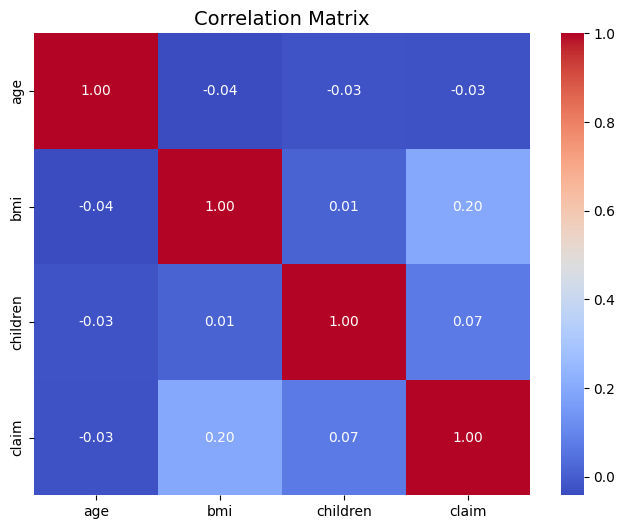

In [8]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = df[['age', 'bmi', 'children', 'claim']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix', fontsize=14)
plt.show()


Here's the correlation matrix for the numerical variables:

Age and Charges: Moderate positive correlation. Older individuals tend to have higher insurance costs.

BMI and Charges: Moderate positive correlation. Higher BMI values are associated with higher costs.

Children and Charges: Weak positive correlation. Having more children slightly increases costs.

Age, BMI, and Children: Low correlations among them, indicating minimal direct relationships.


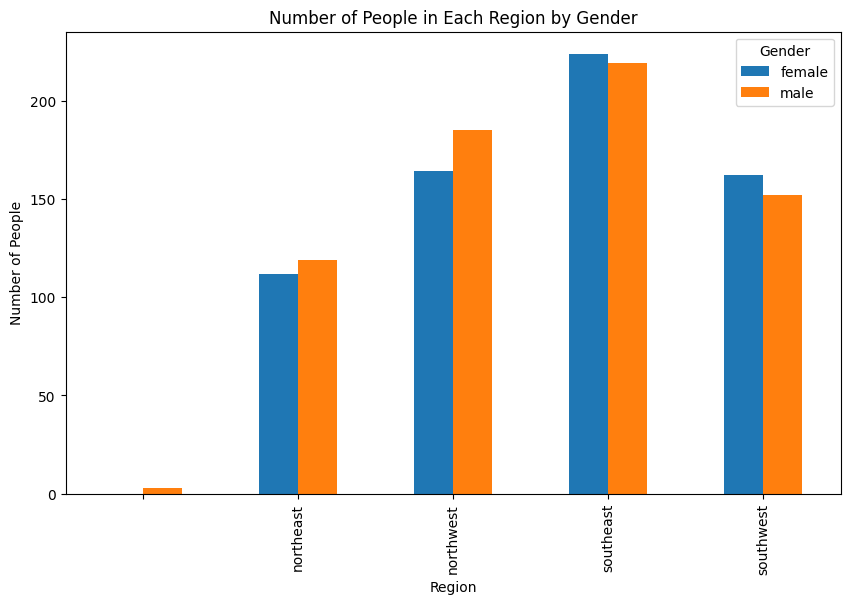

In [30]:
region_gender_counts = df.groupby(['region', 'gender'])['gender'].count().unstack()

ax = region_gender_counts.plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Region')
ax.set_ylabel('Number of People')
ax.set_title('Number of People in Each Region by Gender')
ax.legend(title='Gender')

plt.show()


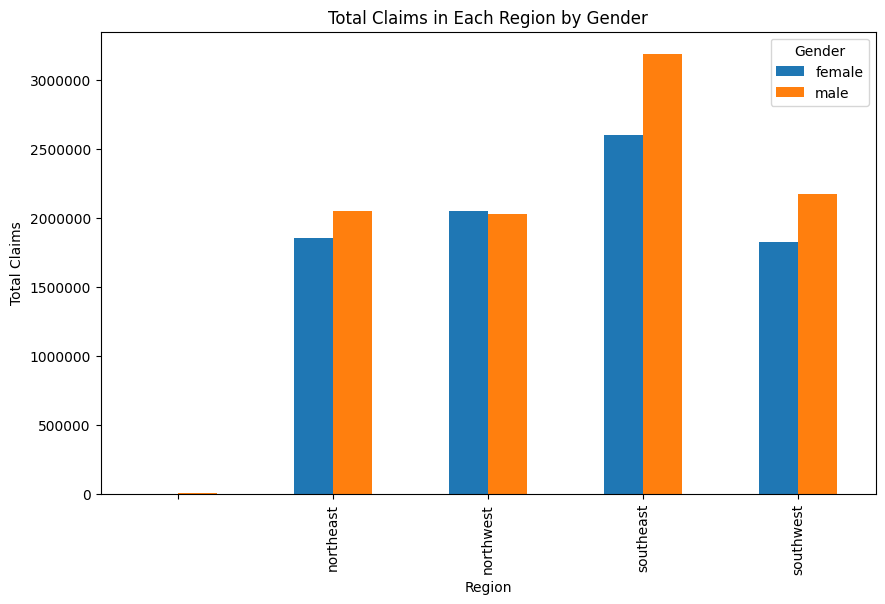

In [33]:
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)

region_total_claim = df.groupby(['region', 'gender'])['claim'].sum().unstack()

ax = region_total_claim.plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Region')
ax.set_ylabel('Total Claims')
ax.set_title('Total Claims in Each Region by Gender')
ax.legend(title='Gender')
ax.yaxis.set_major_formatter(formatter)

plt.show()

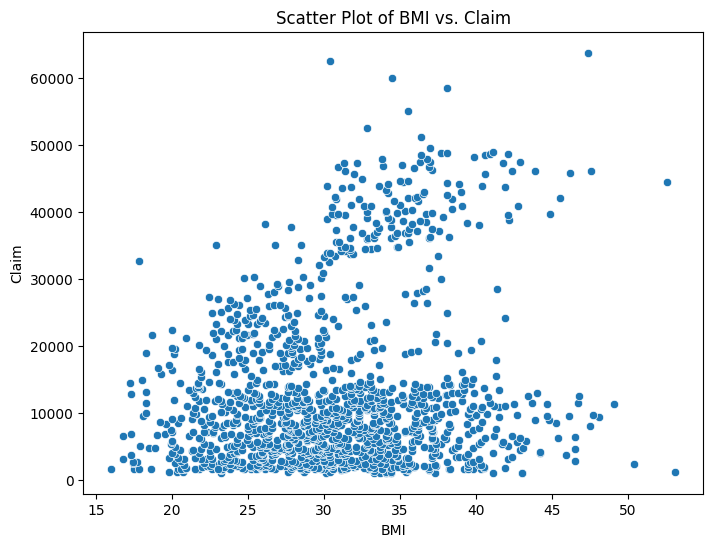

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='claim', data=df)
plt.xlabel('BMI')
plt.ylabel('Claim')
plt.title('Scatter Plot of BMI vs. Claim')
plt.show()


In [9]:
# Define the features (X) and target variable (y)
target = 'claim'
X = df.drop(target, axis=1)  # Features
y = df[target]  # Target

# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Display the sizes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1206, 8), (134, 8), (1206,), (134,))

In [10]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='mean',),
    Ridge()
)

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [12]:
# Make predictions on the test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [13]:
# Calculate R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
# Calculate Mean Squared Error (MSE)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print the metrics
print("R-squared 'training':", r2_train)
print("R-squared 'test':", r2_test)
print("Mean Absolute Error 'training':", mae_train)
print("Mean Absolute Error 'test':", mae_test)

R-squared 'training': 0.8106066720685491
R-squared 'test': 0.6705348560381066
Mean Absolute Error 'training': 3976.5008832992776
Mean Absolute Error 'test': 5021.718678756279


A model accuracy of 81.5% is very good and also a mean absolute error of 3872.84 is not too high or too low. This tells us that this model is performing well for the training data. However it is doing bad with our test data giving us 66.3% and a mean absolute error of 5607.39, but honestly what did we expect when we saw earlier that there's no correlation in our columns but we used a linear model anyway. So let's use another algorithm maybe say random forest regressor.

In [14]:
depth_hyperparams = range(1, 25)

In [15]:
training_acc = []
test_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OneHotEncoder(handle_unknown='ignore', sparse_output=False), # Set sparse=False in OneHotEncoder
        StandardScaler(),
        SimpleImputer(strategy='mean',),
        RandomForestRegressor(max_depth=d) #Added max_depth=d to change depth of Random Forest
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    test_acc.append(test_model.score(X_test, y_test))


print("Training Accuracy Scores:", training_acc[:3])
print("Test Accuracy Scores:", test_acc[:3])

Training Accuracy Scores: [0.6174787209476382, 0.6402294278157759, 0.6576020971931347]
Test Accuracy Scores: [0.6418464353177642, 0.653619222314016, 0.6560168450091646]


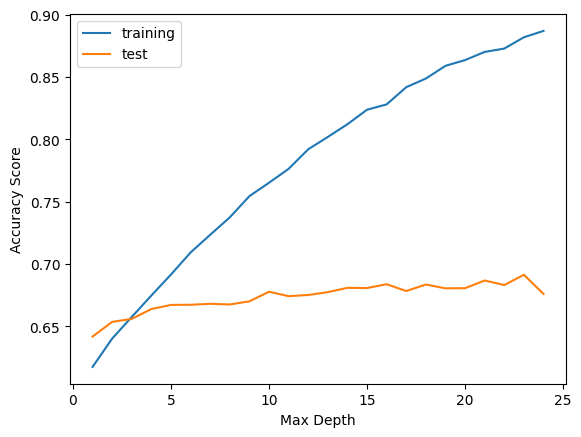

In [16]:
plt.plot(depth_hyperparams, training_acc, label='training')
plt.plot(depth_hyperparams, test_acc, label='test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend();

In [21]:
test_acc = test_model.score(X_test, y_test)
test_acc

0.6760914529319971

In [27]:
final_model = make_pipeline(
        OneHotEncoder(handle_unknown='ignore', sparse_output=False), # Set sparse=False in OneHotEncoder
        StandardScaler(),
        SimpleImputer(strategy='mean',),
        RandomForestRegressor(max_depth=5) #Added max_depth=d to change depth of Random Forest
    )
final_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor', RandomForestRegressor(max_depth=5))])

In [29]:
training_acc = final_model.score(X_train, y_train)
test_acc = final_model.score(X_test, y_test)
print(f'Training accuracy is:{training_acc}  and test accuracy is:{test_acc}')

Training accuracy is:0.6935238042967857  and test accuracy is:0.6640941570938798


Not much changes from our last model, this may be because of the size of our dataset is small thus putting us in this situation.

In [18]:
# Create a new DataFrame with hypothetical values for the features
new_data = pd.DataFrame({
    'age': [25, 35, 45, 55],
    'gender': ['male', 'female', 'male', 'female'],
    'bmi': [25, 30, 28, 32],
    'bloodpressure': [89.5, 70.4, 100.2, 94.1],
    'diabetic': ['no', 'yes', 'no', 'yes'],
    'children': [0, 2, 1, 3],
    'smoker': ['no', 'no', 'yes', 'yes'],
    'region': ['southwest', 'southeast', 'northwest', 'northeast']
})
pred_df = pd.DataFrame(new_data)
pred_df

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region
0,25,male,25,89.5,no,0,no,southwest
1,35,female,30,70.4,yes,2,no,southeast
2,45,male,28,100.2,no,1,yes,northwest
3,55,female,32,94.1,yes,3,yes,northeast


In [19]:
# Use the trained model to predict the claim amount for these hypothetical individuals
predicted_claim = model.predict(pred_df)

# Add the predicted claim amount to the new DataFrame
pred_df['predicted_claim'] = predicted_claim

# Display the DataFrame with the predicted claim amounts
pred_df

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,predicted_claim
0,25,male,25,89.5,no,0,no,southwest,24802.523792
1,35,female,30,70.4,yes,2,no,southeast,25346.180994
2,45,male,28,100.2,no,1,yes,northwest,20924.755485
3,55,female,32,94.1,yes,3,yes,northeast,30008.396801
